# seg_lambda=0.3, alpha=0.5000
# use_eca=True, use_seg_guided=False

## 1. Paths & Training Hyperparameters

In [1]:
import os, sys, math, time, random, itertools
from typing import Tuple, List, Dict
import timm

IMG_ROOT = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images"
TRAIN_CSV = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv"
TEST_CSV  = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv"
MASK_ROOT = IMG_ROOT.replace("png_images", "png_masks")  

OUT_DIR   = "./Baseline+ECA(7000,256)_Output"

IMG_SIZE  = 256 
EPOCHS    = 120       
BATCH     = 16        
LR        = 2e-4
SEED      = 42
VAL_RATIO = 0.20       
SAMPLER   = "off"  
   
TTA_MODES = ("none", "hflip") 

print("IMG_ROOT:", IMG_ROOT)
print("TRAIN_CSV:", TRAIN_CSV)
print("TEST_CSV:", TEST_CSV)
print("OUT_DIR:", OUT_DIR)
print("EPOCHS/BATCH/LR:", EPOCHS, BATCH, LR)
print("VAL_RATIO/SAMPLER:", VAL_RATIO, SAMPLER)

IMG_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images
TRAIN_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv
TEST_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv
OUT_DIR: ./Baseline+ECA(7000,256)_Output
EPOCHS/BATCH/LR: 120 16 0.0002
VAL_RATIO/SAMPLER: 0.2 off


## 2. Imports & Device

In [2]:
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchvision.transforms import InterpolationMode
import torchvision

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"figure.dpi": 110})

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(SEED)
print(f"Using device: {device} | AMP: {'on' if device.type=='cuda' else 'off'}")

Using device: cuda | AMP: on


## 3. Read CSVs & Quick Preview

In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

display(train_df.head(8))
display(test_df.head(8))

print("Train shape:", train_df.shape, "Columns:", list(train_df.columns))
print("Test  shape:", test_df.shape, "Columns:", list(test_df.columns))

print("Train label distribution:", train_df["has_pneumo"].value_counts().to_dict())
print("Test  label distribution:", test_df["has_pneumo"].value_counts().to_dict())

new_filename                                            ImageId  \
0  0_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.5597.151787518...   
1  1_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.12515.15178752...   
2  2_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...   
3  3_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   
4  4_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.1314.151787516...   
5  5_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.11364.15178752...   
6  6_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.4541.151787518...   
7  7_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.4440.151787518...   

   has_pneumo  
0           0  
1           0  
2           1  
3           1  
4           1  
5           0  
6           0  
7           1

new_filename                                            ImageId  \
0  0_test_1_.png  1.2.276.0.7230010.3.1.4.8323329.5797.151787519...   
1  1_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5798.151787519...   
2  2_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5799.151787519...   
3  3_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.580.1517875163...   
4  4_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5800.151787519...   
5  5_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5801.151787519...   
6  6_test_1_.png  1.2.276.0.7230010.3.1.4.8323329.5802.151787519...   
7  7_test_1_.png  1.2.276.0.7230010.3.1.4.8323329.5803.151787519...   

   has_pneumo  
0           1  
1           0  
2           0  
3           0  
4           0  
5           0  
6           1  
7           1

Train shape: (10675, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Test  shape: (1372, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Train label distribution: {0: 8296, 1: 2379}
Test  label distribution: {0: 1082, 1: 290}


## 4. Full-path Resolution & Dataset 

In [4]:
IMG_MEAN = 0.4843
IMG_STD  = 0.2486

def resolve_full_paths(df: pd.DataFrame, img_root: str) -> pd.DataFrame:
    df = df.copy()
    def _resolve(row):
        name = str(row["new_filename"])
        name_png = name if name.lower().endswith(".png") else f"{name}.png"
        p1 = os.path.join(img_root, name_png)
        if os.path.exists(p1):
            return p1
        # fallback: ImageId.png
        alt = os.path.join(img_root, f"{row['ImageId']}.png")
        return alt if os.path.exists(alt) else p1
    df["full_path"] = df.apply(_resolve, axis=1)
    return df

train_df = resolve_full_paths(train_df, IMG_ROOT)
test_df  = resolve_full_paths(test_df,  IMG_ROOT)

missing_train = (~train_df["full_path"].apply(os.path.exists)).sum()
missing_test  = (~test_df["full_path"].apply(os.path.exists)).sum()
print(f"Missing files — Train: {missing_train} | Test: {missing_test}")

class PandasImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["full_path"]).convert("L")
        if self.transform: img = self.transform(img)
        y = int(row["has_pneumo"])
        return img, y
    
class JointImageMaskTransform:
    def __init__(self, out_size=IMG_SIZE):
        self.out_size = out_size

    def __call__(self, img, mask):
        # Resize + RandomResizedCrop + RandomHorizontalFlip + ToTensor + Normalize
        resize_to = int(self.out_size * 1.1)
        img  = TF.resize(img,  (resize_to, resize_to), interpolation=InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (resize_to, resize_to), interpolation=InterpolationMode.NEAREST)

        i, j, h, w = torchvision.transforms.RandomResizedCrop.get_params(
            img,
            scale=(0.8, 1.0),
            ratio=(0.9, 1.1)
        )
        img  = TF.resized_crop(img,  i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.BILINEAR)
        mask = TF.resized_crop(mask, i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.NEAREST)

        if random.random() < 0.5:
            img  = TF.hflip(img)
            mask = TF.hflip(mask)

        if random.random() < 0.5:
            angle = random.uniform(-7, 7)
            img  = TF.rotate(img, angle, interpolation=InterpolationMode.BILINEAR)
            mask = TF.rotate(mask, angle, interpolation=InterpolationMode.NEAREST)

        if random.random() < 0.5:
            b_factor = 1.0 + random.uniform(-0.15, 0.15)
            c_factor = 1.0 + random.uniform(-0.15, 0.15)
            img = TF.adjust_brightness(img, b_factor)
            img = TF.adjust_contrast(img, c_factor)

        img  = TF.to_tensor(img)               # [1,H,W], [0,1]
        img  = TF.normalize(img, [IMG_MEAN], [IMG_STD])

        mask = TF.to_tensor(mask)              # [1,H,W], [0,1]
        mask = (mask > 0.5).float()            # Binarize

        return img, mask

class PandasImageMaskDataset(Dataset):
    def __init__(self, df: pd.DataFrame, mask_root: str, joint_transform: JointImageMaskTransform):
        self.df = df.reset_index(drop=True)
        self.mask_root = mask_root
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Images come from full_path
        img_path = row["full_path"]
        img = Image.open(img_path).convert("L")

        # Masks come from mask_root + basename
        basename = os.path.basename(img_path)
        mask_path = os.path.join(self.mask_root, basename)

        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask not found for {img_path} -> {mask_path}")

        mask = Image.open(mask_path).convert("L")

        img, mask = self.joint_transform(img, mask)

        y = float(row["has_pneumo"])
        return img, y, mask

Missing files — Train: 0 | Test: 0


## 5. Data visulization definition

### 5.1 Class distribution

In [5]:
os.makedirs(OUT_DIR, exist_ok=True)
EDA_DIR = os.path.join(OUT_DIR, "eda"); os.makedirs(EDA_DIR, exist_ok=True)

def eda_class_distribution(df: pd.DataFrame, label_col: str, out_path: str, title: str):
    counts = df[label_col].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    xs = [str(int(x)) for x in counts.index.tolist()]
    ys = counts.values.astype(int)
    plt.bar(xs, ys)
    for i, y in enumerate(ys):
        plt.text(i, y, str(y), ha="center", va="bottom", fontsize=9)
    plt.title(f"Class Distribution — {title}")
    plt.xlabel("Label"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(out_path); plt.show()

def eda_missing_files(df: pd.DataFrame, out_txt: str, title: str):
    missing_mask = ~df["full_path"].apply(os.path.exists)
    total = len(df); missing = missing_mask.sum()
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write(f"Total rows: {total}\nMissing files: {missing}\n")
        if missing:
            f.write("First 50 missing examples:\n")
            f.write("\n".join(df.loc[missing_mask, "full_path"].head(50).tolist()))
    print(f"[{title}] Missing: {missing}/{total} — saved to {out_txt}")

def eda_sample_grid(df: pd.DataFrame, out_path: str, title: str, n_per_class: int = 8, size: int = 128):
    labels = sorted(df["has_pneumo"].unique().tolist())
    panels = []
    for lab in labels:
        subset = df[df["has_pneumo"] == lab]
        sample = subset.sample(min(n_per_class, len(subset)), random_state=0)
        panels.append(sample)

    cols = n_per_class; rows = len(labels)
    plt.figure(figsize=(cols*2, rows*2))
    idx = 1
    for r, panel in enumerate(panels):
        for _, row in panel.iterrows():
            fp = row["full_path"]
            plt.subplot(rows, cols, idx)
            try:
                img = Image.open(fp).convert("L").resize((size,size))
                plt.imshow(img, cmap="gray"); plt.axis("off")
            except Exception:
                plt.text(0.5,0.5,"missing",ha="center",va="center"); plt.axis("off")
            idx += 1
    plt.suptitle(f"Sample Grid — {title}", y=0.98)
    plt.tight_layout(); plt.savefig(out_path); plt.show()

### 5.2 Sample visulization

In [6]:
from pathlib import Path

def eda_sample_grid(df, out_path, split_name, n_per_class=6, size=128):
    label_col = "has_pneumo"
    path_col = "full_path" if "full_path" in df.columns else "filepath"

    classes = sorted(df[label_col].dropna().unique().tolist())
    nrows, ncols = len(classes), n_per_class
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.2, nrows*2.4))
    if nrows == 1:
        axes = np.array([axes])

    for r, c in enumerate(classes):
        sub = df[df[label_col] == c]
        sampled = sub.sample(n=min(n_per_class, len(sub)), random_state=42) if len(sub) > 0 else sub
        sampled = sampled.reset_index(drop=True)

        for i in range(ncols):
            ax = axes[r, i]
            ax.set_axis_off()

            if i < len(sampled):
                row = sampled.iloc[i]
                img_path = str(Path(row[path_col]))
                try:
                    im = Image.open(img_path).convert("L")
                    if size:
                        im = im.resize((size, size))
                    ax.imshow(im, cmap="gray")
                except Exception:
                    ax.imshow(np.zeros((size, size)), cmap="gray")

                ax.text(0.5, -0.08, str(row[label_col]),
                        transform=ax.transAxes, ha="center", va="top", fontsize=9)
            else:
                ax.imshow(np.zeros((size, size)), cmap="gray")

    plt.subplots_adjust(hspace=0.6, wspace=0.05)
    plt.show()
    Path(os.path.dirname(out_path)).mkdir(parents=True, exist_ok=True)
    # fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

## 6. Data split (8:1:1)

In [7]:
# Combine train + test for splitting
full_df = pd.concat([train_df, test_df], ignore_index=True)

print("Original full size:", len(full_df))
print("Label distribution (full):", full_df["has_pneumo"].value_counts().to_dict())

# 20% of the data for val + test
from sklearn.model_selection import train_test_split

train_tmp, temp_df = train_test_split(
    full_df,
    test_size=0.2,
    stratify=full_df["has_pneumo"],
    random_state=SEED,
)

# 10% val, 10% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["has_pneumo"],
    random_state=SEED,
)

# raw train (before rebalancing)
tr_df = train_tmp

print("8:1:1 split sizes ->",
      "Train:", len(tr_df),
      "Val:",   len(val_df),
      "Test:",  len(test_df))

print("Train label dist (before rebalance):", tr_df["has_pneumo"].value_counts().to_dict())
print("Val   label dist:", val_df["has_pneumo"].value_counts().to_dict())
print("Test  label dist:", test_df["has_pneumo"].value_counts().to_dict())

# ------------------------------------------------------------------
# Class imbalance handling:
#   - oversample positive class (has_pneumo == 1) to 4000 samples
#   - downsample negative class (has_pneumo == 0) to 4000 samples
# ------------------------------------------------------------------
TARGET_POS = 3500
TARGET_NEG = 3500

pos_df = tr_df[tr_df["has_pneumo"] == 1]
neg_df = tr_df[tr_df["has_pneumo"] == 0]

n_pos = len(pos_df)
n_neg = len(neg_df)

print(f"Original Train counts -> pos: {n_pos}, neg: {n_neg}")

# 1) Positive class: oversample to TARGET_POS
if n_pos == 0:
    raise ValueError("No positive samples found in training set!")
elif n_pos >= TARGET_POS:
    pos_bal = pos_df.sample(TARGET_POS, replace=False, random_state=SEED)
else:
    factor_pos = TARGET_POS // n_pos
    rem_pos    = TARGET_POS % n_pos
    pos_bal = pd.concat(
        [pos_df] * factor_pos + [pos_df.sample(rem_pos, replace=True, random_state=SEED)],
        ignore_index=True,
    )

# 2) Negative class: downsample to TARGET_NEG
if n_neg == 0:
    raise ValueError("No negative samples found in training set!")
elif n_neg >= TARGET_NEG:
    neg_bal = neg_df.sample(TARGET_NEG, replace=False, random_state=SEED)
else:
    factor_neg = TARGET_NEG // n_neg
    rem_neg    = TARGET_NEG % n_neg
    neg_bal = pd.concat(
        [neg_df] * factor_neg + [neg_df.sample(rem_neg, replace=True, random_state=SEED)],
        ignore_index=True,
    )

# 3) Merge and shuffle
tr_df_bal = pd.concat([pos_bal, neg_bal], ignore_index=True)
tr_df_bal = tr_df_bal.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("After rebalancing Train label dist:",
      tr_df_bal["has_pneumo"].value_counts().to_dict())
print("Final Train size:", len(tr_df_bal))

# final training DataFrame to use downstream
tr_df = tr_df_bal

Original full size: 12047
Label distribution (full): {0: 9378, 1: 2669}
8:1:1 split sizes -> Train: 9637 Val: 1205 Test: 1205
Train label dist (before rebalance): {0: 7502, 1: 2135}
Val   label dist: {0: 938, 1: 267}
Test  label dist: {0: 938, 1: 267}
Original Train counts -> pos: 2135, neg: 7502
After rebalancing Train label dist: {0: 3500, 1: 3500}
Final Train size: 7000


## 7. Data augmentation

In [8]:
# Transforms
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[IMG_MEAN], std=[IMG_STD]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[IMG_MEAN], std=[IMG_STD]),
])

# Joint transforms for image + mask (training set)
joint_train_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

# Datasets
ds_train = PandasImageMaskDataset(tr_df, mask_root=MASK_ROOT, joint_transform=joint_train_tfms)
ds_val   = PandasImageDataset(val_df, transform=eval_tfms)
ds_test  = PandasImageDataset(test_df, transform=eval_tfms)

def make_weights_for_balancing(df: pd.DataFrame) -> np.ndarray:
    counts = df["has_pneumo"].value_counts().to_dict()
    return df["has_pneumo"].map(lambda y: 1.0 / counts[int(y)]).values.astype(np.float32)


if SAMPLER == "on":
    weights = make_weights_for_balancing(tr_df)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    shuffle = False
else:
    sampler = None; shuffle = True

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, shuffle=shuffle,
                      num_workers=0, pin_memory=True)
dl_val   = DataLoader(ds_val, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test  = DataLoader(ds_test, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Use eval dataset for train_eval
ds_train_eval = PandasImageDataset(tr_df, transform=eval_tfms)
dl_train_eval = DataLoader(
    ds_train_eval, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True
)


len(ds_train), len(ds_val), len(ds_test)

(7000, 1205, 1205)

## 8. Comparison of before & after Standardizatin

In [9]:
# from torchvision import transforms
# from torch.utils.data import DataLoader

# raw_tf = transforms.ToTensor()

# ds_train_raw = PandasImageDataset(tr_df,  transform=raw_tf)
# ds_val_raw   = PandasImageDataset(val_df, transform=raw_tf)
# ds_test_raw  = PandasImageDataset(test_df, transform=raw_tf)

# dl_train_raw = DataLoader(ds_train_raw, batch_size=BATCH, shuffle=False,
#                           num_workers=0, pin_memory=True)
# dl_val_raw   = DataLoader(ds_val_raw,   batch_size=BATCH, shuffle=False,
#                           num_workers=0, pin_memory=True)
# dl_test_raw  = DataLoader(ds_test_raw,  batch_size=BATCH, shuffle=False,
#                           num_workers=0, pin_memory=True)


### 8.1 Calculate mean & std from dataloader

In [10]:
# import torch

# def compute_mean_std_from_loader(dataloader, max_batches=None, name=""):
#     sum_ = 0.0
#     sum_sq = 0.0
#     n_pixels = 0

#     for i, batch in enumerate(dataloader):
#         if isinstance(batch, (list, tuple)):
#             imgs = batch[0]
#         else:
#             imgs = batch
        
#         imgs = imgs.float()
#         b, c, h, w = imgs.shape
#         imgs = imgs.view(b, c, -1)   # [B, C, H*W]

#         sum_    += imgs.sum(dim=[0, 2])          # [C]
#         sum_sq  += (imgs ** 2).sum(dim=[0, 2])   # [C]
#         n_pixels += b * h * w

#         if (max_batches is not None) and (i + 1 >= max_batches):
#             break

#     mean = sum_ / n_pixels
#     std  = torch.sqrt(sum_sq / n_pixels - mean ** 2)

#     print(f"{name} mean:", mean)
#     print(f"{name} std :", std)
#     print("-" * 60)
#     return mean, std

### 8.2 Standardization checking

In [11]:
# print("========== BEFORE standardization (0-1, ToTensor only) ==========")
# train_raw_mean, train_raw_std = compute_mean_std_from_loader(dl_train_raw, name="Train raw")
# val_raw_mean,   val_raw_std   = compute_mean_std_from_loader(dl_val_raw,   name="Val raw")
# test_raw_mean,  test_raw_std  = compute_mean_std_from_loader(dl_test_raw,  name="Test raw")

# print("\n========== AFTER standardization (using current pipeline) ==========")
# train_std_mean, train_std_std = compute_mean_std_from_loader(dl_train, name="Train standardized")
# val_std_mean,   val_std_std   = compute_mean_std_from_loader(dl_val,   name="Val standardized")
# test_std_mean,  test_std_std  = compute_mean_std_from_loader(dl_test,  name="Test standardized")


### 8.3 Data visualization after standardization

In [12]:
# import numpy as np
# import matplotlib.pyplot as plt

# def collect_pixels(dataloader, max_batches=200):
#     all_pixels = []

#     for i, batch in enumerate(dataloader):
#         if isinstance(batch, (list, tuple)):
#             imgs = batch[0]
#         else:
#             imgs = batch

#         imgs = imgs.float().cpu()
#         all_pixels.append(imgs.view(-1).numpy())

#         if (max_batches is not None) and (i + 1 >= max_batches):
#             break

#     if len(all_pixels) == 0:
#         return np.array([])
#     return np.concatenate(all_pixels, axis=0)
# train_pixels_raw  = collect_pixels(dl_train_raw, max_batches=200) 
# train_pixels_std  = collect_pixels(dl_train,      max_batches=200) 

# print("Train pixels (raw)  shape:", train_pixels_raw.shape)
# print("Train pixels (std)  shape:", train_pixels_std.shape)

# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.title("Train — Before standardization (0-1)")
# plt.hist(train_pixels_raw, bins=50)
# plt.xlabel("Pixel value (0-1)")
# plt.ylabel("Count")

# plt.subplot(1, 2, 2)
# plt.title("Train — After standardization")
# plt.hist(train_pixels_std, bins=50)
# plt.xlabel("Pixel value (standardized)")
# plt.ylabel("Count")

# plt.tight_layout()
# plt.show()


In [13]:
import os
import numpy as np
from PIL import Image

first_pos_idx = 1  

row = tr_df.iloc[first_pos_idx]
img_path = row["full_path"]
basename = os.path.basename(img_path)

print("img_path:", img_path)
print("basename:", basename)

print("MASK_ROOT:", MASK_ROOT)
mask_path = os.path.join(MASK_ROOT, basename)
print("mask_path:", mask_path, "exists:", os.path.exists(mask_path))

mask_raw = Image.open(mask_path).convert("L")
mask_np = np.array(mask_raw)

print("raw mask shape:", mask_np.shape)
print("raw mask min/max:", mask_np.min(), mask_np.max())
print("raw mask positive pixels (>0):", (mask_np > 0).sum())


img_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images\1926_train_1_.png
basename: 1926_train_1_.png
MASK_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks
mask_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks\1926_train_1_.png exists: True
raw mask shape: (1024, 1024)
raw mask min/max: 0 255
raw mask positive pixels (>0): 18335


In [14]:
pos_indices = [i for i, v in enumerate(tr_df["has_pneumo"].values) if v == 1]
print("Positive sample number:", len(pos_indices))
first_pos_idx = pos_indices[0]

img, y, mask = ds_train[first_pos_idx]
print("index:", first_pos_idx)
print("label:", y)
print("mask shape:", mask.shape)
print("mask min/max:", mask.min().item(), mask.max().item())
print("mask positive pixels:", mask.sum().item())

Positive sample number: 3500
index: 1
label: 1.0
mask shape: torch.Size([1, 256, 256])
mask min/max: 0.0 1.0
mask positive pixels: 1349.0


## 9. ConvNeXt_V2

### 9.1 DropPath (Random Depth)

In [15]:
def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1.0 - drop_prob
    # Only sample along batch dimension, broadcast others
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    return x * random_tensor / keep_prob

class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

### 9.2 GRN

In [16]:
class GRN(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        gx = torch.norm(x, p=2, dim=(1, 2), keepdim=True)                # [N,1,1,C]
        nx = gx / (gx.mean(dim=-1, keepdim=True) + 1e-6)                 # [N,1,1,C]
        return self.gamma * (x * nx) + self.beta + x                     # [N,H,W,C]

### 9.3 LayerNorm2d

In [17]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = (x - mean).pow(2).mean(dim=1, keepdim=True)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight.view(1, -1, 1, 1) * x + self.bias.view(1, -1, 1, 1)

### 9.4 ECA

In [18]:
class ECALayer(nn.Module):
    def __init__(self, channels: int, k_size: int = 3):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(
            in_channels=1,
            out_channels=1,
            kernel_size=k_size,
            padding=(k_size - 1) // 2,
            bias=False,
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: [B, C, H, W]
        y = self.avg_pool(x)                    # [B, C, 1, 1]
        y = y.squeeze(-1).transpose(-1, -2)     # [B, 1, C]
        y = self.conv(y)                        # [B, 1, C]
        y = self.sigmoid(y)
        y = y.transpose(-1, -2).unsqueeze(-1)   # [B, C, 1, 1]
        return x * y


### 9.5 ConvNeXt_V2 block

In [19]:
class ConvNeXtV2Block(nn.Module):
    def __init__(
        self,
        dim: int,
        mlp_ratio: float = 4.0,
        drop_path: float = 0.0,
        layer_scale_init_value: float = 0.0,  
    ):
        super().__init__()
        # 7x7 depthwise convolution
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

        # Do LayerNorm in channels_last format
        self.norm = nn.LayerNorm(dim, eps=1e-6)

        hidden_dim = int(dim * mlp_ratio)
        self.pwconv1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.grn = GRN(hidden_dim)
        self.pwconv2 = nn.Linear(hidden_dim, dim)

        # LayerScale
        if layer_scale_init_value > 0:
            self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim))
        else:
            self.gamma = None

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        shortcut = x  # [N, C, H, W]

        x = self.dwconv(x)

        # NCHW -> NHWC
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)

        if self.gamma is not None:
            x = self.gamma.view(1, 1, 1, -1) * x

        # NHWC -> NCHW
        x = x.permute(0, 3, 1, 2)

        x = shortcut + self.drop_path(x)
        return x

## 10. U-Net Decoder Block

In [20]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int):
        super().__init__()
        self.has_skip = skip_ch > 0

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        self.conv1 = nn.Conv2d(in_ch + (skip_ch if skip_ch > 0 else 0),
                               out_ch, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.act   = nn.ReLU(inplace=True)

    def forward(self, x, skip=None):
        # Oversample
        x = self.upsample(x)

        if self.has_skip and skip is not None:
            if skip.shape[-2:] != x.shape[-2:]:
                skip = F.interpolate(skip, size=x.shape[-2:], mode="bilinear", align_corners=False)
            x = torch.cat([x, skip], dim=1)

        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        return x


## 11. ConvNeXt_V2 tiny

In [21]:
class ConvNeXtV2Tiny(nn.Module):
    def __init__(
        self,
        in_chans: int = 3,
        num_classes: int = 1000,
        drop_path_rate: float = 0.0,
        layer_scale_init_value: float = 0.0, 
    ):
        super().__init__()

        # 4 deepths and dims for each stage
        depths = [3, 3, 9, 3]
        dims = [96, 192, 384, 768]

        self.downsample_layers = nn.ModuleList()
        self.stages = nn.ModuleList()

        # Constructing the stem: patch embedding with stride=4
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm2d(dims[0]),
        )
        self.downsample_layers.append(stem)

        # Constructing the blocks and downsampling layers for each stage
        total_blocks = sum(depths)
        dpr_values = torch.linspace(0, drop_path_rate, total_blocks).tolist()
        block_idx = 0

        for stage_idx in range(4):
            depth = depths[stage_idx]
            dim = dims[stage_idx]

            # Every stage begins with a downsampling layer (except the first)
            if stage_idx > 0:
                down = nn.Sequential(
                    LayerNorm2d(dims[stage_idx - 1]),
                    nn.Conv2d(dims[stage_idx - 1], dim, kernel_size=2, stride=2),
                )
                self.downsample_layers.append(down)

            blocks = []
            for i in range(depth):
                blocks.append(
                    ConvNeXtV2Block(
                        dim=dim,
                        mlp_ratio=4.0,
                        drop_path=dpr_values[block_idx + i],
                        layer_scale_init_value=layer_scale_init_value,
                    )
                )
            block_idx += depth

            self.stages.append(nn.Sequential(*blocks))

        # The last classification head: LN + Linear
        self.norm_head = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = (
            nn.Linear(dims[-1], num_classes) if num_classes > 0 else nn.Identity()
        )

    def forward_features(self, x):
        # Downsampling through stages
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)

        # Global average pooling and normalization
        x = x.mean(dim=[2, 3])
        x = self.norm_head(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)  # [N, num_classes]
        return x
    
class ConvNeXtV2TinyScratch(nn.Module):
    def __init__(
        self,
        in_chans: int = 1,
        n_classes: int = 1,
        drop_path_rate: float = 0.1,
        use_seg_guided: bool = True,  
    ):
        super().__init__()

        self.backbone = ConvNeXtV2Tiny(
            in_chans=in_chans,
            num_classes=n_classes,
            drop_path_rate=drop_path_rate,
            layer_scale_init_value=0.0,
        )

        # Channel dims at each stage of ConvNeXtV2Tiny
        dims = [96, 192, 384, 768]
        last_dim = dims[-1]   # The deepest 768

        # ===== ECA on deepest feature map =====
        self.eca4 = ECALayer(last_dim, k_size=3)

        # ===== Segmentation guidance =====
        self.use_seg_guided  = use_seg_guided   # ★ 改成用入参
        self.seg_guided_scale = 0.5             

        # ===== Classification head =====
        self.cls_head = nn.Linear(last_dim, n_classes)

        # ===== U-Net decoder =====
        # encoder output: x1(1/4, 96), x2(1/8, 192), x3(1/16,384), x4(1/32,768)
        self.dec3 = DecoderBlock(in_ch=dims[3], skip_ch=dims[2], out_ch=dims[2])   # 1/32 -> 1/16
        self.dec2 = DecoderBlock(in_ch=dims[2], skip_ch=dims[1], out_ch=dims[1])   # 1/16 -> 1/8
        self.dec1 = DecoderBlock(in_ch=dims[1], skip_ch=dims[0], out_ch=dims[0])   # 1/8  -> 1/4
        self.dec0 = DecoderBlock(in_ch=dims[0], skip_ch=0,        out_ch=max(dims[0] // 2, 32))  # 1/4 -> 1/2

        # Segmentation head：convalution to 1 channel
        self.seg_head = nn.Conv2d(max(dims[0] // 2, 32), 1, kernel_size=1)



    def forward_backbone_pyramid(self, x):
        """
        Return feature pyramid from backbone
        x1: 1/4,  x2: 1/8,  x3: 1/16, x4: 1/32
        """
        feats = []
        for i in range(4):
            x = self.backbone.downsample_layers[i](x)
            x = self.backbone.stages[i](x)

            if i == 3:
                x = self.eca4(x)    # x4: [B, 768, H/32, W/32]

            feats.append(x)
        return feats  # [x1, x2, x3, x4]


    def forward(self, x):
        # ---- Encoder ----
        x1, x2, x3, x4 = self.forward_backbone_pyramid(x)

        # ---- U-Net Decoder + Segmentation head ----
        d3 = self.dec3(x4, x3)    # 1/32 -> 1/16
        d2 = self.dec2(d3, x2)    # 1/16 -> 1/8
        d1 = self.dec1(d2, x1)    # 1/8  -> 1/4
        d0 = self.dec0(d1, None)  # 1/4  -> 1/2

        seg_logits = self.seg_head(d0)  # [B,1,H_dec,W_dec]

        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        # ---- Segmentation-guided Classification ----
        x4_for_cls = x4 

        if self.use_seg_guided:
            seg_prob = torch.sigmoid(seg_logits)

            seg_down = F.adaptive_avg_pool2d(seg_prob, output_size=x4.shape[-2:])

            x4_for_cls = x4 * (1.0 + self.seg_guided_scale * seg_down)

        # ---- Classification branch ----
        gap = x4_for_cls.mean(dim=[2, 3])          # [B, C4]
        gap = self.backbone.norm_head(gap)
        cls_logits = self.cls_head(gap)           # [B, 1]
        cls_logits = cls_logits.squeeze(1)        # [B]

        return cls_logits, seg_logits


model = ConvNeXtV2TinyScratch(
    in_chans=1,
    n_classes=1,
    drop_path_rate=0.1,
    use_seg_guided=False, 
).to(device)


## 12. Model loading

In [22]:
# import torch
# import os

# model = ConvNeXtV2TinyScratch(
#     in_chans=1,
#     n_classes=1,
#     drop_path_rate=0.1,
#     use_seg_guided=False, 
# ).to(device)

# ckpt_path = os.path.join("./Baseline+ECA(7000,256)_Output", "best_cnn.pt")
# print("Loading checkpoint from:", ckpt_path)

# state = torch.load(ckpt_path, map_location=device)

# missing, unexpected = model.load_state_dict(state, strict=False)
# print("Missing keys:", missing)
# print("Unexpected keys:", unexpected)

# model.eval()


## 13. Parameter counts

In [23]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total params:      {total:,}")
    print(f"Trainable params:  {trainable:,}")
    print(f"Total params (M):  {total / 1e6:.2f} M")
    print(f"Trainable (M):     {trainable / 1e6:.2f} M")

count_parameters(model)


Total params:      34,898,838
Trainable params:  34,898,838
Total params (M):  34.90 M
Trainable (M):     34.90 M


## 14. Loss：Tversky + Focal

### 14.1 Tversky Loss

In [24]:
# Weights initialization
LAMBDA_SEG = 0.3

class TverskyLoss(nn.Module):
    def __init__(self, alpha: float = 0.3, beta: float = 0.7,
                 smooth: float = 1e-6, pos_only: bool = True):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
        self.pos_only = pos_only

    def forward(self, logits, targets):
        """
        logits: [B,1,H,W]
        targets: [B,1,H,W] (0/1)
        """
        probs = torch.sigmoid(logits)
        targets = targets.float()

        B = probs.size(0)
        probs_flat   = probs.view(B, -1)
        targets_flat = targets.view(B, -1)

        # Only calculate positive sample using Tversky
        if self.pos_only:
            pos_mask = (targets_flat.sum(dim=1) > 0)
            if pos_mask.any():
                probs_flat   = probs_flat[pos_mask]
                targets_flat = targets_flat[pos_mask]
            else:
                return logits.new_tensor(0.0)

        TP = (probs_flat * targets_flat).sum(dim=1)
        FP = (probs_flat * (1.0 - targets_flat)).sum(dim=1)
        FN = ((1.0 - probs_flat) * targets_flat).sum(dim=1)

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        loss = 1.0 - tversky
        return loss.mean()

### 14.2 Focal Loss

In [25]:
# Calculate class weights for Focal Loss
pos = (np.array(tr_df["has_pneumo"]) == 1).sum()
neg = (np.array(tr_df["has_pneumo"]) == 0).sum()

alpha = neg / (pos + neg + 1e-8)  

print(f"Train pos={pos}, neg={neg}, alpha={alpha:.4f}")

# Define Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        if logits.dim() > targets.dim():
            targets = targets.view_as(logits)
        targets = targets.float()

        # Probabilities for the true class
        prob = torch.sigmoid(logits)
        pt = prob * targets + (1 - prob) * (1 - targets)  

        # Weighted alpha factor
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # Focal weight
        focal_weight = alpha_t * (1 - pt).pow(self.gamma)

        # Basic BCE with logits
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction="none"
        )
        loss = focal_weight * bce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Create criterion, optimizer, scheduler, scaler
criterion_cls  = BinaryFocalLoss(alpha=alpha, gamma=2.0)   # clf
criterion_segF = BinaryFocalLoss(alpha=0.5,   gamma=2.0)   # seg
criterion_segT = TverskyLoss(alpha=0.3, beta=0.7, pos_only=True)

# Optimizer / Scheduler / AMP
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


Train pos=3500, neg=3500, alpha=0.5000


C:\Users\Steven\AppData\Local\Temp\ipykernel_47436\3234299231.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


## 15. Model eval function

### 15.1 TTA

In [26]:
import torch

def apply_tta_to_images(xb: torch.Tensor, mode: str) -> torch.Tensor:
    if mode == "none":
        return xb
    elif mode == "hflip":
        return torch.flip(xb, dims=[3])
    elif mode == "vflip":
        return torch.flip(xb, dims=[2])
    elif mode == "rot90":
        return torch.rot90(xb, k=1, dims=(2, 3))
    elif mode == "rot270":
        return torch.rot90(xb, k=3, dims=(2, 3))
    else:
        raise ValueError(f"Unknown TTA mode: {mode}")

def invert_tta_for_segmentation(seg_logits: torch.Tensor, mode: str) -> torch.Tensor:
    if seg_logits is None:
        return None

    if mode == "none":
        return seg_logits
    elif mode == "hflip":
        return torch.flip(seg_logits, dims=[3])
    elif mode == "vflip":
        return torch.flip(seg_logits, dims=[2])
    elif mode == "rot90":
        return torch.rot90(seg_logits, k=3, dims=(2, 3))
    elif mode == "rot270":
        return torch.rot90(seg_logits, k=1, dims=(2, 3))
    else:
        raise ValueError(f"Unknown TTA mode: {mode}")

def forward_with_tta_logits(
    model: torch.nn.Module,
    xb: torch.Tensor,
    device: torch.device,
    tta_modes=None,
):
    if tta_modes is None:
        tta_modes = TTA_MODES

    model.eval()
    xb = xb.to(device, non_blocking=True)

    cls_logits_list = []
    seg_logits_list = []

    for mode in tta_modes:
        xb_aug = apply_tta_to_images(xb, mode)

        out = model(xb_aug)
        if isinstance(out, tuple):
            cls_logits, seg_logits = out
        else:
            cls_logits, seg_logits = out, None

        cls_logits_list.append(cls_logits)

        if seg_logits is not None:
            seg_logits_orig = invert_tta_for_segmentation(seg_logits, mode)
            seg_logits_list.append(seg_logits_orig)

    cls_logits_mean = torch.stack(cls_logits_list, dim=0).mean(dim=0)

    if len(seg_logits_list) > 0:
        seg_logits_mean = torch.stack(seg_logits_list, dim=0).mean(dim=0)
    else:
        seg_logits_mean = None

    return cls_logits_mean, seg_logits_mean

### 15.2 Calibration function

In [27]:
from tqdm.auto import tqdm

@torch.no_grad()
def collect_logits_and_labels(
    model,
    loader,
    device,
    use_tta: bool = False,
    desc: str = "Collect logits",
):
    model.eval()
    all_logits, all_labels = [], []

    for xb, yb in tqdm(loader, desc=desc, leave=False):
        yb = yb.to(device, non_blocking=True).float()

        if use_tta:
            logits, _ = forward_with_tta_logits(
                model, xb, device, tta_modes=TTA_MODES
            )
        else:
            xb = xb.to(device, non_blocking=True)
            out = model(xb)
            if isinstance(out, tuple):
                logits, _ = out
            else:
                logits = out

        all_logits.append(logits.detach())
        all_labels.append(yb.detach())

    logits = torch.cat(all_logits, dim=0)
    labels = torch.cat(all_labels, dim=0)
    return logits, labels


def tune_temperature(model, loader, device,
                     init_temp: float = 1.0,
                     max_iter: int = 50,
                     lr: float = 0.01):

    logits, labels = collect_logits_and_labels(model, loader, device)
    logits = logits.to(device)
    labels = labels.to(device)

    # Initialize temperature parameter
    temperature = torch.ones(1, device=device) * init_temp
    temperature = torch.nn.Parameter(temperature)

    optimizer = torch.optim.LBFGS([temperature], lr=lr, max_iter=max_iter)

    def closure():
        optimizer.zero_grad()
        temp = torch.clamp(temperature, min=1e-3)
        loss = F.binary_cross_entropy_with_logits(logits / temp, labels)
        loss.backward()
        return loss

    optimizer.step(closure)
    temp_final = torch.clamp(temperature.detach(), min=1e-3)
    print(f"[Calib] Optimal temperature T = {temp_final.item():.4f}")
    return float(temp_final.item())


def compute_calibration_metrics(y_true, y_prob, n_bins: int = 10):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_prob = np.asarray(y_prob).ravel()
    assert y_true.shape == y_prob.shape

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1

    total = len(y_true)
    ece = 0.0
    mce = 0.0
    bin_acc = []
    bin_conf = []
    bin_centers = []
    bin_counts = []

    for i in range(n_bins):
        idx = binids == i
        if not np.any(idx):
            bin_acc.append(np.nan)
            bin_conf.append(np.nan)
            bin_centers.append(0.5 * (bins[i] + bins[i+1]))
            bin_counts.append(0)
            continue

        p = y_prob[idx]
        t = y_true[idx]
        acc = t.mean()
        conf = p.mean()
        w = len(t) / total

        ece += w * abs(acc - conf)
        mce = max(mce, abs(acc - conf))

        bin_acc.append(acc)
        bin_conf.append(conf)
        bin_centers.append(0.5 * (bins[i] + bins[i+1]))
        bin_counts.append(len(t))

    brier = np.mean((y_prob - y_true) ** 2)

    return {
        "ece": float(ece),
        "mce": float(mce),
        "brier": float(brier),
        "bin_acc": np.array(bin_acc),
        "bin_conf": np.array(bin_conf),
        "bin_centers": np.array(bin_centers),
        "bin_counts": np.array(bin_counts),
    }


def plot_reliability_diagram(y_true, y_prob, out_path,
                             n_bins: int = 10,
                             title: str = "Reliability diagram"):
    res = compute_calibration_metrics(y_true, y_prob, n_bins=n_bins)
    centers = res["bin_centers"]
    acc = res["bin_acc"]
    conf = res["bin_conf"]

    mask = ~np.isnan(acc)

    plt.figure(figsize=(5, 4))
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect")
    plt.bar(centers[mask],
            acc[mask],
            width=1.0 / n_bins,
            edgecolor="k",
            alpha=0.6,
            label="Empirical")
    plt.plot(centers[mask],
             conf[mask],
             marker="o",
             linestyle="-",
             label="Mean conf")

    plt.xlabel("Predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(title + f"\n(ECE={res['ece']:.3f}, Brier={res['brier']:.3f})")
    plt.legend()
    plt.tight_layout()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=300)
    plt.show()
    return res

### 15.3 Evaluate function

In [28]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

@torch.no_grad()
def evaluate(
    model,
    loader,
    device,
    cls_threshold: float = 0.5,
    temperature: float = None,
    desc: str = "Eval",
    use_tta: bool = False, 
):
    model.eval()
    ys, preds, scores = [], [], []

    for xb, yb in tqdm(loader, desc=desc, leave=False):
        yb = yb.to(device, non_blocking=True)

        if use_tta:
            logits, _ = forward_with_tta_logits(
                model, xb, device, tta_modes=TTA_MODES
            )
        else:
            xb = xb.to(device, non_blocking=True)
            out = model(xb)
            if isinstance(out, tuple):
                logits, _ = out          # (cls_logits, seg_logits)
            else:
                logits = out

        if temperature is not None:
            logits = logits / float(temperature)

        probs = torch.sigmoid(logits)   # [B]
        pred  = (probs >= cls_threshold).long()

        ys.extend(yb.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())
        scores.extend(probs.cpu().numpy().tolist())

    y_true  = np.asarray(ys).astype(int).ravel()
    y_pred  = np.asarray(preds).astype(int).ravel()
    y_score = np.asarray(scores).ravel()

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    try:
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")
    except Exception:
        spec = float("nan")

    try:
        roc = roc_auc_score(y_true, y_score)
    except Exception:
        roc = float("nan")

    try:
        pr  = average_precision_score(y_true, y_score)
    except Exception:
        pr  = float("nan")

    metrics = {
        "acc":    acc,
        "prec":   prec,
        "rec":    rec,
        "f1":     f1,
        "spec":   spec,
        "roc_auc": roc,
        "pr_auc":  pr,
    }
    return metrics, y_true, y_pred, y_score
    
def plot_confusion_matrix(y_true, y_pred, out_path, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['0','1']); plt.yticks(ticks, ['0','1'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.ylabel("Actual"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()

def plot_roc_pr(y_true, y_score, out_dir, prefix="eval",
                roc_auc=None, pr_auc=None):
    os.makedirs(out_dir, exist_ok=True)

    # ROC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})" if roc_auc is not None else "ROC")
        plt.plot([0,1],[0,1], linestyle="--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_roc.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("ROC failed:", e)

    # PR
    try:
        prec, rec, _ = precision_recall_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(rec, prec, label=f"PR (AP={pr_auc:.3f})" if pr_auc is not None else "PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision–Recall Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_pr.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("PR failed:", e)

def plot_roc_compare_splits(
    y_train, s_train,
    y_val,   s_val,
    y_test,  s_test,
    out_dir,
    prefix="convnextv2_tiny_focal",
):
    os.makedirs(out_dir, exist_ok=True)

    plt.figure(figsize=(6, 5))
    for y, s, name in [
        (y_train, s_train, "Train"),
        (y_val,   s_val,   "Val"),
        (y_test,  s_test,  "Test"),
    ]:
        try:
            fpr, tpr, _ = roc_curve(y, s)
            auc = roc_auc_score(y, s)
            plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        except Exception as e:
            print(f"ROC for {name} failed:", e)

    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC: Train vs Val vs Test")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_roc_train_val_test.png"), dpi=300)
    plt.show()

def plot_pr_compare_splits(
    y_train, s_train,
    y_val,   s_val,
    y_test,  s_test,
    out_dir,
    prefix="convnextv2_tiny_focal",
):
    os.makedirs(out_dir, exist_ok=True)

    plt.figure(figsize=(6, 5))
    for y, s, name in [
        (y_train, s_train, "Train"),
        (y_val,   s_val,   "Val"),
        (y_test,  s_test,  "Test"),
    ]:
        try:
            prec, rec, _ = precision_recall_curve(y, s)
            ap = average_precision_score(y, s)
            plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
        except Exception as e:
            print(f"PR for {name} failed:", e)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall: Train vs Val vs Test")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_pr_train_val_test.png"), dpi=300)
    plt.show()


def plot_learning_curves(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    epochs = np.arange(1, best_epoch + 1)

    train_loss = history["train_loss"][:best_epoch]
    val_loss   = history["val_loss"][:best_epoch]
    val_f1     = np.array(history["val_f1"][:best_epoch]) * 100.0

    # --- Loss Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning Curve (Loss, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_loss_best.png"), dpi=300)
    plt.show()

    # --- F1 Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_f1, marker="o", label="Val F1 (macro)")
    plt.xlabel("Epoch")
    plt.ylabel("Val F1 (%)")
    plt.title(f"Learning Curve (Val F1, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_f1_best.png"), dpi=300)
    plt.show()

def plot_accuracy_curve(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    epochs  = np.arange(1, best_epoch + 1)
    val_acc = np.array(history["val_acc"][:best_epoch]) * 100.0

    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_acc, marker="o", label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Val Accuracy (%)")
    plt.title(f"Learning Curve (Val Accuracy, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_acc_best.png"), dpi=300)
    plt.show()

def plot_split_metrics_bar(train_metrics, val_metrics, test_metrics,
                           out_dir, prefix="convnextv2_tiny_focal"):
    os.makedirs(out_dir, exist_ok=True)

    metric_keys = ["acc", "prec", "rec", "f1", "spec", "roc_auc", "pr_auc"]
    metric_names = [
        "Accuracy", "Precision", "Recall", "F1-score",
        "Specificity", "ROC-AUC", "PR-AUC"
    ]

    x = np.arange(len(metric_keys))
    width = 0.25

    train_vals = [train_metrics[k] * 100.0 for k in metric_keys]
    val_vals   = [val_metrics[k]   * 100.0 for k in metric_keys]
    test_vals  = [test_metrics[k]  * 100.0 for k in metric_keys]

    plt.figure(figsize=(10, 5))
    plt.bar(x - width, train_vals, width, label="Train")
    plt.bar(x,         val_vals,   width, label="Val")
    plt.bar(x + width, test_vals,  width, label="Test")

    plt.xticks(x, metric_names, rotation=25)
    plt.ylabel("Score (%)")
    plt.title("Chart of metrics: Train vs Val vs Test")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_metrics_train_val_test.png"), dpi=300)
    plt.show()


In [29]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

backbone.downsample_layers.0.0.weight
backbone.downsample_layers.0.0.bias
backbone.downsample_layers.0.1.weight
backbone.downsample_layers.0.1.bias
backbone.downsample_layers.1.0.weight
backbone.downsample_layers.1.0.bias
backbone.downsample_layers.1.1.weight
backbone.downsample_layers.1.1.bias
backbone.downsample_layers.2.0.weight
backbone.downsample_layers.2.0.bias
backbone.downsample_layers.2.1.weight
backbone.downsample_layers.2.1.bias
backbone.downsample_layers.3.0.weight
backbone.downsample_layers.3.0.bias
backbone.downsample_layers.3.1.weight
backbone.downsample_layers.3.1.bias
backbone.stages.0.0.dwconv.weight
backbone.stages.0.0.dwconv.bias
backbone.stages.0.0.norm.weight
backbone.stages.0.0.norm.bias
backbone.stages.0.0.pwconv1.weight
backbone.stages.0.0.pwconv1.bias
backbone.stages.0.0.grn.gamma
backbone.stages.0.0.grn.beta
backbone.stages.0.0.pwconv2.weight
backbone.stages.0.0.pwconv2.bias
backbone.stages.0.1.dwconv.weight
backbone.stages.0.1.dwconv.bias
backbone.stages.0.1

## 16. Model training

In [30]:
from tqdm.auto import tqdm

# Early Stopping parameters
MONITOR    = "pr_auc" 
MODE       = "max"
PATIENCE   = 8
MIN_EPOCHS = 10
DELTA      = 1e-4

best_score   = -float('inf')
best_epoch   = 0
epochs_bad   = 0
BEST_STATE   = None

history = {
    "train_loss": [],
    "val_loss":   [],
    "val_acc":    [],
    "val_prec":   [],
    "val_rec":    [],
    "val_f1":     [],
    "val_spec":   [],
    "val_roc":    [],
    "val_pr":     [],
}

print("[Info] Start training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running, running_cls, running_seg, nb = 0.0, 0.0, 0.0, 0 
    bar = tqdm(total=len(dl_train), leave=True, desc=f"Epoch {epoch}/{EPOCHS}")

    for xb, yb, mb in dl_train:   # clf + seg
        xb = xb.to(device, non_blocking=True)         # [B, 1, H, W]
        yb = yb.to(device, non_blocking=True).float() # [B]
        mb = mb.to(device, non_blocking=True).float() # [B, 1, H, W]

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision
        with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
            cls_logits, seg_logits = model(xb)   # cls_logits: [B], seg_logits: [B,1,H,W]

            # Classification branch：Focal Loss
            cls_loss = criterion_cls(cls_logits, yb)

            # Segmentation branch：Focal Loss + Tversky Loss
            seg_loss_focal   = criterion_segF(seg_logits, mb)
            seg_loss_tversky = criterion_segT(seg_logits, mb)
            seg_loss = seg_loss_focal + seg_loss_tversky

            # Total loss
            loss = cls_loss + LAMBDA_SEG * seg_loss



        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Sum of three losses
        running      += loss.item()
        running_cls  += cls_loss.item()
        running_seg  += seg_loss.item()
        nb           += 1

        try:
            curr_lr = scheduler.get_last_lr()[0]
        except Exception:
            curr_lr = optimizer.param_groups[0]["lr"]

        bar.set_postfix(
            loss=f"{running / max(nb, 1):.4f}",
            cls=f"{running_cls / max(nb, 1):.4f}",
            seg=f"{running_seg / max(nb, 1):.8f}",
            lr=f"{curr_lr:.2e}",
        )
        bar.update(1)

    scheduler.step()
    bar.close()

    # Calculate train and val loss for the epoch
    train_loss_epoch = running / max(nb, 1)

    model.eval()
    val_running, val_nb = 0.0, 0
    with torch.no_grad():
        for xb, yb in dl_val:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True).float()

            with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
                out = model(xb)
                if isinstance(out, tuple):
                    logits, _ = out
                else:
                    logits = out
                loss_val = criterion_cls(logits, yb)

            val_running += loss_val.item()
            val_nb += 1
    val_loss_epoch = val_running / max(val_nb, 1)

    metrics, yv, pv, sv = evaluate(model, dl_val, device)
    score = float(metrics.get(MONITOR, float('nan')))
    improved = score > (best_score + DELTA)

    history["train_loss"].append(train_loss_epoch)
    history["val_loss"].append(val_loss_epoch)
    history["val_acc"].append(metrics["acc"])
    history["val_prec"].append(metrics["prec"])
    history["val_rec"].append(metrics["rec"])
    history["val_f1"].append(metrics["f1"])
    history["val_spec"].append(metrics["spec"])
    history["val_roc"].append(metrics["roc_auc"])
    history["val_pr"].append(metrics["pr_auc"])

    if improved:
        best_score = score
        best_epoch = epoch
        BEST_STATE = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_bad = 0
    else:
        epochs_bad += 1

    tqdm.write(
        f"Epoch {epoch:02d}/{EPOCHS} "
        f"train_loss={train_loss_epoch:.4f} val_loss={val_loss_epoch:.4f} "
        f"val_acc={metrics['acc']:.4f} val_prec={metrics['prec']:.4f} "
        f"val_rec={metrics['rec']:.4f} val_f1={metrics['f1']:.4f} "
        f"val_spec={metrics['spec']:.4f} "
        f"val_roc={metrics['roc_auc']:.4f} val_pr={metrics['pr_auc']:.4f} "
        f"| val_{MONITOR}={score:.4f} best_{MONITOR}={best_score:.4f} (epoch {best_epoch})"
    )

    if epoch >= MIN_EPOCHS and epochs_bad >= PATIENCE:
        tqdm.write(f"[EarlyStop] Stop at epoch {epoch}. Best {MONITOR}={best_score:.4f} @ epoch {best_epoch}.")
        break

# Save best model
if BEST_STATE is not None:
    torch.save(BEST_STATE, os.path.join(OUT_DIR, "best_cnn.pt"))
    model.load_state_dict(BEST_STATE)

[Info] Start training...


Epoch 1/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 01/120 train_loss=0.3942 val_loss=0.0988 val_acc=0.2216 val_prec=0.2216 val_rec=1.0000 val_f1=0.3628 val_spec=0.0000 val_roc=0.6433 val_pr=0.3050 | val_pr_auc=0.3050 best_pr_auc=0.3050 (epoch 1)


Epoch 2/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 02/120 train_loss=0.3421 val_loss=0.0815 val_acc=0.7021 val_prec=0.3067 val_rec=0.2734 val_f1=0.2891 val_spec=0.8241 val_roc=0.6439 val_pr=0.2977 | val_pr_auc=0.2977 best_pr_auc=0.3050 (epoch 1)


Epoch 3/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 03/120 train_loss=0.3093 val_loss=0.0936 val_acc=0.3876 val_prec=0.2560 val_rec=0.9251 val_f1=0.4010 val_spec=0.2345 val_roc=0.6750 val_pr=0.3271 | val_pr_auc=0.3271 best_pr_auc=0.3271 (epoch 3)


Epoch 4/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 04/120 train_loss=0.2919 val_loss=0.0761 val_acc=0.6979 val_prec=0.3992 val_rec=0.7191 val_f1=0.5134 val_spec=0.6919 val_roc=0.7752 val_pr=0.4696 | val_pr_auc=0.4696 best_pr_auc=0.4696 (epoch 4)


Epoch 5/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 05/120 train_loss=0.2763 val_loss=0.0881 val_acc=0.5950 val_prec=0.3401 val_rec=0.8801 val_f1=0.4906 val_spec=0.5139 val_roc=0.7892 val_pr=0.4932 | val_pr_auc=0.4932 best_pr_auc=0.4932 (epoch 5)


Epoch 6/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 06/120 train_loss=0.2656 val_loss=0.0851 val_acc=0.6473 val_prec=0.3705 val_rec=0.8464 val_f1=0.5154 val_spec=0.5906 val_roc=0.7895 val_pr=0.4927 | val_pr_auc=0.4927 best_pr_auc=0.4932 (epoch 5)


Epoch 7/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 07/120 train_loss=0.2588 val_loss=0.0682 val_acc=0.7386 val_prec=0.4481 val_rec=0.7753 val_f1=0.5679 val_spec=0.7281 val_roc=0.8287 val_pr=0.5574 | val_pr_auc=0.5574 best_pr_auc=0.5574 (epoch 7)


Epoch 8/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 08/120 train_loss=0.2543 val_loss=0.0775 val_acc=0.7129 val_prec=0.4283 val_rec=0.8839 val_f1=0.5770 val_spec=0.6642 val_roc=0.8451 val_pr=0.5735 | val_pr_auc=0.5735 best_pr_auc=0.5735 (epoch 8)


Epoch 9/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 09/120 train_loss=0.2507 val_loss=0.0792 val_acc=0.6697 val_prec=0.3938 val_rec=0.9101 val_f1=0.5498 val_spec=0.6013 val_roc=0.8436 val_pr=0.5622 | val_pr_auc=0.5622 best_pr_auc=0.5735 (epoch 8)


Epoch 10/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 10/120 train_loss=0.2447 val_loss=0.0678 val_acc=0.7618 val_prec=0.4792 val_rec=0.8614 val_f1=0.6158 val_spec=0.7335 val_roc=0.8552 val_pr=0.5888 | val_pr_auc=0.5888 best_pr_auc=0.5888 (epoch 10)


Epoch 11/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 11/120 train_loss=0.2413 val_loss=0.0658 val_acc=0.7452 val_prec=0.4587 val_rec=0.8315 val_f1=0.5912 val_spec=0.7207 val_roc=0.8415 val_pr=0.5546 | val_pr_auc=0.5546 best_pr_auc=0.5888 (epoch 10)


Epoch 12/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 12/120 train_loss=0.2380 val_loss=0.0592 val_acc=0.7876 val_prec=0.5131 val_rec=0.8090 val_f1=0.6279 val_spec=0.7814 val_roc=0.8587 val_pr=0.5953 | val_pr_auc=0.5953 best_pr_auc=0.5953 (epoch 12)


Epoch 13/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 13/120 train_loss=0.2341 val_loss=0.0575 val_acc=0.7967 val_prec=0.5311 val_rec=0.7041 val_f1=0.6055 val_spec=0.8230 val_roc=0.8404 val_pr=0.5615 | val_pr_auc=0.5615 best_pr_auc=0.5953 (epoch 12)


Epoch 14/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 14/120 train_loss=0.2326 val_loss=0.0679 val_acc=0.7593 val_prec=0.4756 val_rec=0.8390 val_f1=0.6070 val_spec=0.7367 val_roc=0.8541 val_pr=0.5798 | val_pr_auc=0.5798 best_pr_auc=0.5953 (epoch 12)


Epoch 15/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 15/120 train_loss=0.2296 val_loss=0.0622 val_acc=0.7743 val_prec=0.4943 val_rec=0.8165 val_f1=0.6158 val_spec=0.7623 val_roc=0.8532 val_pr=0.5858 | val_pr_auc=0.5858 best_pr_auc=0.5953 (epoch 12)


Epoch 16/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 16/120 train_loss=0.2253 val_loss=0.0613 val_acc=0.7759 val_prec=0.4967 val_rec=0.8577 val_f1=0.6291 val_spec=0.7527 val_roc=0.8702 val_pr=0.6151 | val_pr_auc=0.6151 best_pr_auc=0.6151 (epoch 16)


Epoch 17/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 17/120 train_loss=0.2247 val_loss=0.0605 val_acc=0.7718 val_prec=0.4909 val_rec=0.8052 val_f1=0.6099 val_spec=0.7623 val_roc=0.8591 val_pr=0.6153 | val_pr_auc=0.6153 best_pr_auc=0.6153 (epoch 17)


Epoch 18/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 18/120 train_loss=0.2208 val_loss=0.0741 val_acc=0.7095 val_prec=0.4265 val_rec=0.9026 val_f1=0.5793 val_spec=0.6546 val_roc=0.8705 val_pr=0.6150 | val_pr_auc=0.6150 best_pr_auc=0.6153 (epoch 17)


Epoch 19/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 19/120 train_loss=0.2158 val_loss=0.0721 val_acc=0.7378 val_prec=0.4519 val_rec=0.8614 val_f1=0.5928 val_spec=0.7026 val_roc=0.8674 val_pr=0.6023 | val_pr_auc=0.6023 best_pr_auc=0.6153 (epoch 17)


Epoch 20/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 20/120 train_loss=0.2133 val_loss=0.0588 val_acc=0.7992 val_prec=0.5306 val_rec=0.8127 val_f1=0.6420 val_spec=0.7953 val_roc=0.8716 val_pr=0.6269 | val_pr_auc=0.6269 best_pr_auc=0.6269 (epoch 20)


Epoch 21/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 21/120 train_loss=0.2121 val_loss=0.0531 val_acc=0.8216 val_prec=0.5765 val_rec=0.7341 val_f1=0.6458 val_spec=0.8465 val_roc=0.8725 val_pr=0.6388 | val_pr_auc=0.6388 best_pr_auc=0.6388 (epoch 21)


Epoch 22/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 22/120 train_loss=0.2086 val_loss=0.0664 val_acc=0.7444 val_prec=0.4591 val_rec=0.8614 val_f1=0.5990 val_spec=0.7111 val_roc=0.8512 val_pr=0.6058 | val_pr_auc=0.6058 best_pr_auc=0.6388 (epoch 21)


Epoch 23/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 23/120 train_loss=0.2051 val_loss=0.0579 val_acc=0.8033 val_prec=0.5391 val_rec=0.7753 val_f1=0.6359 val_spec=0.8113 val_roc=0.8742 val_pr=0.6266 | val_pr_auc=0.6266 best_pr_auc=0.6388 (epoch 21)


Epoch 24/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 24/120 train_loss=0.2037 val_loss=0.0533 val_acc=0.8257 val_prec=0.5973 val_rec=0.6554 val_f1=0.6250 val_spec=0.8742 val_roc=0.8512 val_pr=0.6114 | val_pr_auc=0.6114 best_pr_auc=0.6388 (epoch 21)


Epoch 25/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 25/120 train_loss=0.2003 val_loss=0.0496 val_acc=0.8315 val_prec=0.5964 val_rec=0.7416 val_f1=0.6611 val_spec=0.8571 val_roc=0.8775 val_pr=0.6582 | val_pr_auc=0.6582 best_pr_auc=0.6582 (epoch 25)


Epoch 26/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 26/120 train_loss=0.1967 val_loss=0.0580 val_acc=0.7834 val_prec=0.5070 val_rec=0.8165 val_f1=0.6255 val_spec=0.7740 val_roc=0.8799 val_pr=0.6649 | val_pr_auc=0.6649 best_pr_auc=0.6649 (epoch 26)


Epoch 27/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 27/120 train_loss=0.1957 val_loss=0.0619 val_acc=0.7925 val_prec=0.5222 val_rec=0.7491 val_f1=0.6154 val_spec=0.8049 val_roc=0.8686 val_pr=0.6331 | val_pr_auc=0.6331 best_pr_auc=0.6649 (epoch 26)


Epoch 28/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 28/120 train_loss=0.1892 val_loss=0.0713 val_acc=0.7676 val_prec=0.4858 val_rec=0.8352 val_f1=0.6143 val_spec=0.7484 val_roc=0.8591 val_pr=0.6258 | val_pr_auc=0.6258 best_pr_auc=0.6649 (epoch 26)


Epoch 29/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 29/120 train_loss=0.1885 val_loss=0.0596 val_acc=0.7967 val_prec=0.5261 val_rec=0.8315 val_f1=0.6444 val_spec=0.7868 val_roc=0.8807 val_pr=0.6649 | val_pr_auc=0.6649 best_pr_auc=0.6649 (epoch 26)


Epoch 30/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 30/120 train_loss=0.1853 val_loss=0.0547 val_acc=0.8390 val_prec=0.6159 val_rec=0.7266 val_f1=0.6667 val_spec=0.8710 val_roc=0.8796 val_pr=0.6691 | val_pr_auc=0.6691 best_pr_auc=0.6691 (epoch 30)


Epoch 31/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 31/120 train_loss=0.1798 val_loss=0.0632 val_acc=0.7801 val_prec=0.5022 val_rec=0.8390 val_f1=0.6283 val_spec=0.7633 val_roc=0.8794 val_pr=0.6760 | val_pr_auc=0.6760 best_pr_auc=0.6760 (epoch 31)


Epoch 32/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 32/120 train_loss=0.1791 val_loss=0.0592 val_acc=0.8166 val_prec=0.5714 val_rec=0.6891 val_f1=0.6248 val_spec=0.8529 val_roc=0.8649 val_pr=0.6384 | val_pr_auc=0.6384 best_pr_auc=0.6760 (epoch 31)


Epoch 33/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 33/120 train_loss=0.1735 val_loss=0.0633 val_acc=0.8041 val_prec=0.5418 val_rec=0.7528 val_f1=0.6301 val_spec=0.8188 val_roc=0.8751 val_pr=0.6550 | val_pr_auc=0.6550 best_pr_auc=0.6760 (epoch 31)


Epoch 34/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 34/120 train_loss=0.1729 val_loss=0.0533 val_acc=0.8324 val_prec=0.6032 val_rec=0.7116 val_f1=0.6529 val_spec=0.8667 val_roc=0.8848 val_pr=0.6928 | val_pr_auc=0.6928 best_pr_auc=0.6928 (epoch 34)


Epoch 35/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 35/120 train_loss=0.1709 val_loss=0.0577 val_acc=0.8191 val_prec=0.5650 val_rec=0.7978 val_f1=0.6615 val_spec=0.8252 val_roc=0.8899 val_pr=0.7070 | val_pr_auc=0.7070 best_pr_auc=0.7070 (epoch 35)


Epoch 36/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 36/120 train_loss=0.1669 val_loss=0.0559 val_acc=0.8108 val_prec=0.5501 val_rec=0.8015 val_f1=0.6524 val_spec=0.8134 val_roc=0.8836 val_pr=0.6865 | val_pr_auc=0.6865 best_pr_auc=0.7070 (epoch 35)


Epoch 37/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 37/120 train_loss=0.1630 val_loss=0.0676 val_acc=0.8083 val_prec=0.5455 val_rec=0.8090 val_f1=0.6516 val_spec=0.8081 val_roc=0.8774 val_pr=0.6836 | val_pr_auc=0.6836 best_pr_auc=0.7070 (epoch 35)


Epoch 38/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 38/120 train_loss=0.1592 val_loss=0.0729 val_acc=0.7701 val_prec=0.4890 val_rec=0.8315 val_f1=0.6158 val_spec=0.7527 val_roc=0.8677 val_pr=0.6599 | val_pr_auc=0.6599 best_pr_auc=0.7070 (epoch 35)


Epoch 39/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 39/120 train_loss=0.1578 val_loss=0.0718 val_acc=0.7983 val_prec=0.5283 val_rec=0.8390 val_f1=0.6483 val_spec=0.7868 val_roc=0.8896 val_pr=0.7122 | val_pr_auc=0.7122 best_pr_auc=0.7122 (epoch 39)


Epoch 40/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 40/120 train_loss=0.1550 val_loss=0.0775 val_acc=0.7817 val_prec=0.5046 val_rec=0.8165 val_f1=0.6237 val_spec=0.7719 val_roc=0.8772 val_pr=0.6580 | val_pr_auc=0.6580 best_pr_auc=0.7122 (epoch 39)


Epoch 41/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 41/120 train_loss=0.1505 val_loss=0.0923 val_acc=0.7867 val_prec=0.5110 val_rec=0.8689 val_f1=0.6436 val_spec=0.7633 val_roc=0.8987 val_pr=0.7216 | val_pr_auc=0.7216 best_pr_auc=0.7216 (epoch 41)


Epoch 42/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 42/120 train_loss=0.1486 val_loss=0.0723 val_acc=0.8224 val_prec=0.5699 val_rec=0.8090 val_f1=0.6687 val_spec=0.8262 val_roc=0.8900 val_pr=0.6991 | val_pr_auc=0.6991 best_pr_auc=0.7216 (epoch 41)


Epoch 43/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 43/120 train_loss=0.1454 val_loss=0.0616 val_acc=0.8390 val_prec=0.6174 val_rec=0.7191 val_f1=0.6644 val_spec=0.8731 val_roc=0.8897 val_pr=0.7049 | val_pr_auc=0.7049 best_pr_auc=0.7216 (epoch 41)


Epoch 44/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 44/120 train_loss=0.1431 val_loss=0.0685 val_acc=0.8398 val_prec=0.6186 val_rec=0.7228 val_f1=0.6667 val_spec=0.8731 val_roc=0.8898 val_pr=0.6973 | val_pr_auc=0.6973 best_pr_auc=0.7216 (epoch 41)


Epoch 45/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 45/120 train_loss=0.1402 val_loss=0.0757 val_acc=0.8091 val_prec=0.5478 val_rec=0.7940 val_f1=0.6483 val_spec=0.8134 val_roc=0.8812 val_pr=0.6884 | val_pr_auc=0.6884 best_pr_auc=0.7216 (epoch 41)


Epoch 46/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 46/120 train_loss=0.1391 val_loss=0.0902 val_acc=0.7934 val_prec=0.5214 val_rec=0.8202 val_f1=0.6376 val_spec=0.7857 val_roc=0.8867 val_pr=0.6906 | val_pr_auc=0.6906 best_pr_auc=0.7216 (epoch 41)


Epoch 47/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 47/120 train_loss=0.1353 val_loss=0.0819 val_acc=0.8100 val_prec=0.5540 val_rec=0.7303 val_f1=0.6300 val_spec=0.8326 val_roc=0.8747 val_pr=0.6614 | val_pr_auc=0.6614 best_pr_auc=0.7216 (epoch 41)


Epoch 48/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 48/120 train_loss=0.1361 val_loss=0.0838 val_acc=0.8108 val_prec=0.5512 val_rec=0.7865 val_f1=0.6481 val_spec=0.8177 val_roc=0.8842 val_pr=0.6859 | val_pr_auc=0.6859 best_pr_auc=0.7216 (epoch 41)


Epoch 49/120:   0%|          | 0/438 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 49/120 train_loss=0.1321 val_loss=0.0671 val_acc=0.8340 val_prec=0.6167 val_rec=0.6629 val_f1=0.6390 val_spec=0.8827 val_roc=0.8798 val_pr=0.6776 | val_pr_auc=0.6776 best_pr_auc=0.7216 (epoch 41)
[EarlyStop] Stop at epoch 49. Best pr_auc=0.7216 @ epoch 41.


## 17. Save & load history

In [31]:
# import json

# history_path = os.path.join(OUT_DIR, "history_convnextv2_tiny_focal.json")
# with open(history_path, "w") as f:
#     json.dump(
#         {
#             "history": history,
#             "best_epoch": best_epoch,
#         },
#         f
#     )

# print(f"[Info] Saved training history to: {history_path}")


In [32]:
# import json

# history_path = os.path.join(OUT_DIR, "history_convnextv2_tiny_focal.json")
# with open(history_path, "r") as f:
#     data = json.load(f)

# history = data["history"]
# best_epoch = data["best_epoch"]

# print(f"[Info] Loaded history from: {history_path}")
# print(f"[Info] best_epoch = {best_epoch}")


## 18. Model evaluation

### 18.1.1 Evaluation (train)

In [33]:
train_metrics_best, ytr_best, ptr_best, str_best = evaluate(
    model,
    dl_train_eval,
    device,
    desc="[Eval Train]",
    use_tta=False,         
)

train_pct = {k: round(v * 100, 3) for k, v in train_metrics_best.items()}

print("\n[Best model @ Train]")
print("Accuracy (%)        :", train_pct["acc"])
print("Precision (%)       :", train_pct["prec"])
print("Recall (%)          :", train_pct["rec"])
print("F1-Score (%)        :", train_pct["f1"])
print("Specificity (%)     :", train_pct["spec"])
print("ROC-AUC (%)         :", train_pct["roc_auc"])
print("Precision-recall (%):", train_pct["pr_auc"])

[Eval Train]:   0%|          | 0/438 [00:00<?, ?it/s]


[Best model @ Train]
Accuracy (%)        : 94.143
Precision (%)       : 90.297
Recall (%)          : 98.914
F1-Score (%)        : 94.41
Specificity (%)     : 89.371
ROC-AUC (%)         : 99.203
Precision-recall (%): 99.143


### 18.1.2 Evaluation (val/test) notta

In [34]:
val_metrics_notta, yv_notta, pv_notta, sv_notta = evaluate(
    model,
    dl_val,
    device,
    desc="[Eval Val noTTA]",
    use_tta=False,      
)

test_metrics_notta, yt_notta, pt_notta, st_notta = evaluate(
    model,
    dl_test,
    device,
    desc="[Eval Test noTTA]",
    use_tta=False,
)

val_pct   = {k: round(v * 100, 3) for k, v in val_metrics_notta.items()}
test_pct  = {k: round(v * 100, 3) for k, v in test_metrics_notta.items()}

print("\n[No TTA model @ Val]")
print("Accuracy (%)        :", val_pct["acc"])
print("Precision (%)       :", val_pct["prec"])
print("Recall (%)          :", val_pct["rec"])
print("F1-Score (%)        :", val_pct["f1"])
print("Specificity (%)     :", val_pct["spec"])
print("ROC-AUC (%)         :", val_pct["roc_auc"])
print("Precision-recall (%):", val_pct["pr_auc"])

print("\n[No TTA model @ Test]")
print("Accuracy (%)        :", test_pct["acc"])
print("Precision (%)       :", test_pct["prec"])
print("Recall (%)          :", test_pct["rec"])
print("F1-Score (%)        :", test_pct["f1"])
print("Specificity (%)     :", test_pct["spec"])
print("ROC-AUC (%)         :", test_pct["roc_auc"])
print("Precision-recall (%):", test_pct["pr_auc"])

[Eval Val noTTA]:   0%|          | 0/76 [00:00<?, ?it/s]

[Eval Test noTTA]:   0%|          | 0/76 [00:00<?, ?it/s]


[No TTA model @ Val]
Accuracy (%)        : 78.672
Precision (%)       : 51.101
Recall (%)          : 86.891
F1-Score (%)        : 64.355
Specificity (%)     : 76.333
ROC-AUC (%)         : 89.872
Precision-recall (%): 72.157

[No TTA model @ Test]
Accuracy (%)        : 78.008
Precision (%)       : 50.22
Recall (%)          : 85.393
F1-Score (%)        : 63.245
Specificity (%)     : 75.906
ROC-AUC (%)         : 88.376
Precision-recall (%): 70.393


### 18.1.3 Evaluation (val/test)

In [35]:
val_metrics_tta,   yv_tta,  pv_tta,  sv_tta  = evaluate(
    model,
    dl_val,
    device,
    desc="[Eval Val TTA]",
    use_tta=True,        
)

test_metrics_tta,   yt_tta,  pt_tta,  st_tta  = evaluate(
    model,
    dl_test,
    device,
    desc="[Eval Test TTA]",
    use_tta=True,
)

val_pct_TTA   = {k: round(v * 100, 3) for k, v in val_metrics_tta.items()}
test_pct_TTA  = {k: round(v * 100, 3) for k, v in test_metrics_tta.items()}

print("\n[TTA model @ Val]")
print("Accuracy (%)        :", val_pct_TTA["acc"])
print("Precision (%)       :", val_pct_TTA["prec"])
print("Recall (%)          :", val_pct_TTA["rec"])
print("F1-Score (%)        :", val_pct_TTA["f1"])
print("Specificity (%)     :", val_pct_TTA["spec"])
print("ROC-AUC (%)         :", val_pct_TTA["roc_auc"])
print("Precision-recall (%):", val_pct_TTA["pr_auc"])

print("\n[TTA model @ Test]")
print("Accuracy (%)        :", test_pct_TTA["acc"])
print("Precision (%)       :", test_pct_TTA["prec"])
print("Recall (%)          :", test_pct_TTA["rec"])
print("F1-Score (%)        :", test_pct_TTA["f1"])
print("Specificity (%)     :", test_pct_TTA["spec"])
print("ROC-AUC (%)         :", test_pct_TTA["roc_auc"])
print("Precision-recall (%):", test_pct_TTA["pr_auc"])

[Eval Val TTA]:   0%|          | 0/76 [00:00<?, ?it/s]

[Eval Test TTA]:   0%|          | 0/76 [00:00<?, ?it/s]


[TTA model @ Val]
Accuracy (%)        : 79.336
Precision (%)       : 52.0
Recall (%)          : 87.64
F1-Score (%)        : 65.272
Specificity (%)     : 76.972
ROC-AUC (%)         : 90.478
Precision-recall (%): 72.76

[TTA model @ Test]
Accuracy (%)        : 79.004
Precision (%)       : 51.606
Recall (%)          : 84.27
F1-Score (%)        : 64.011
Specificity (%)     : 77.505
ROC-AUC (%)         : 88.914
Precision-recall (%): 71.029


In [36]:
def print_compare(split, m_no, m_tta, label1="noTTA", label2="TTA"):
    print(f"\n[{split}] {label1} vs {label2}")
    for k in ["acc", "prec", "rec", "f1", "spec", "roc_auc", "pr_auc"]:
        v1 = m_no[k]
        v2 = m_tta[k]
        print(f"{k:10s}: {label1} = {v1:.4f},  {label2} = {v2:.4f},  Δ = {v2 - v1:+.4f}")

print_compare("Val",  val_metrics_notta,  val_metrics_tta)
print_compare("Test", test_metrics_notta, test_metrics_tta)


[Val] noTTA vs TTA
acc       : noTTA = 0.7867,  TTA = 0.7934,  Δ = +0.0066
prec      : noTTA = 0.5110,  TTA = 0.5200,  Δ = +0.0090
rec       : noTTA = 0.8689,  TTA = 0.8764,  Δ = +0.0075
f1        : noTTA = 0.6436,  TTA = 0.6527,  Δ = +0.0092
spec      : noTTA = 0.7633,  TTA = 0.7697,  Δ = +0.0064
roc_auc   : noTTA = 0.8987,  TTA = 0.9048,  Δ = +0.0061
pr_auc    : noTTA = 0.7216,  TTA = 0.7276,  Δ = +0.0060

[Test] noTTA vs TTA
acc       : noTTA = 0.7801,  TTA = 0.7900,  Δ = +0.0100
prec      : noTTA = 0.5022,  TTA = 0.5161,  Δ = +0.0139
rec       : noTTA = 0.8539,  TTA = 0.8427,  Δ = -0.0112
f1        : noTTA = 0.6325,  TTA = 0.6401,  Δ = +0.0077
spec      : noTTA = 0.7591,  TTA = 0.7751,  Δ = +0.0160
roc_auc   : noTTA = 0.8838,  TTA = 0.8891,  Δ = +0.0054
pr_auc    : noTTA = 0.7039,  TTA = 0.7103,  Δ = +0.0064


### 18.2 FIt T_opt on val, getting ECE/Brier

Collect logits:   0%|          | 0/76 [00:00<?, ?it/s]

c:\Users\Steven\anaconda3\envs\pytorch-gpu\lib\site-packages\torch\optim\lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  loss = float(closure())


[Calib] Optimal temperature T = 1.0041
[Calib] Saved temperature to: ./Baseline+ECA(7000,256)_Output\best_temperature.txt


Eval:   0%|          | 0/76 [00:00<?, ?it/s]

Eval:   0%|          | 0/76 [00:00<?, ?it/s]


[Val noTTA]  before calibration: {'acc': 0.7867219917012448, 'prec': 0.5110132158590308, 'rec': 0.8689138576779026, 'f1': 0.6435506241331485, 'spec': np.float64(0.7633262260046554), 'roc_auc': np.float64(0.898716689426064), 'pr_auc': np.float64(0.7215675837037633)}
[Val noTTA]  after  calibration: {'acc': 0.7867219917012448, 'prec': 0.5110132158590308, 'rec': 0.8689138576779026, 'f1': 0.6435506241331485, 'spec': np.float64(0.7633262260046554), 'roc_auc': np.float64(0.898716689426064), 'pr_auc': np.float64(0.7215675837037633)}

[Test noTTA] before calibration: {'acc': 0.7800829875518672, 'prec': 0.5022026431718062, 'rec': 0.8539325842696629, 'f1': 0.6324549237170597, 'spec': np.float64(0.759061833680607), 'roc_auc': np.float64(0.883755380401364), 'pr_auc': np.float64(0.7039284754641285)}
[Test noTTA] after  calibration: {'acc': 0.7800829875518672, 'prec': 0.5022026431718062, 'rec': 0.8539325842696629, 'f1': 0.6324549237170597, 'spec': np.float64(0.759061833680607), 'roc_auc': np.float6

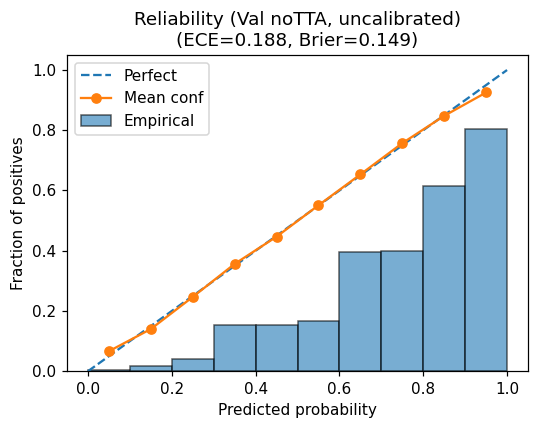

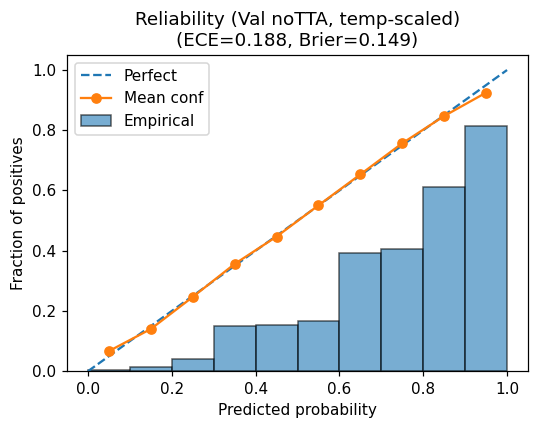

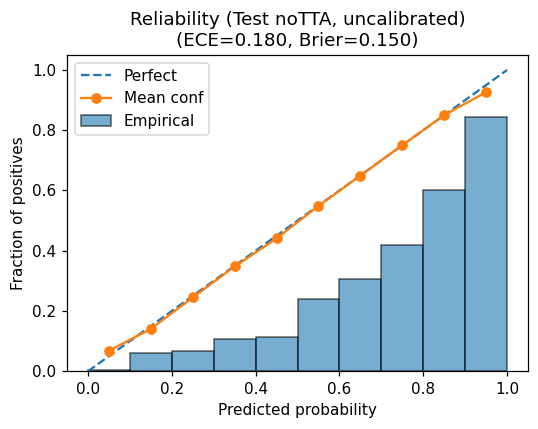

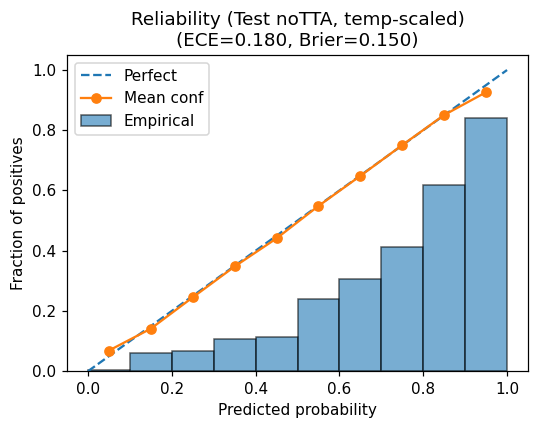


[Val TTA]  before calibration: {'acc': 0.7933609958506224, 'prec': 0.52, 'rec': 0.8764044943820225, 'f1': 0.6527196652719666, 'spec': np.float64(0.7697228144907279), 'roc_auc': np.float64(0.9047818691454446), 'pr_auc': np.float64(0.72760458965835)}
[Val TTA]  after  calibration: {'acc': 0.7933609958506224, 'prec': 0.52, 'rec': 0.8764044943820225, 'f1': 0.6527196652719666, 'spec': np.float64(0.7697228144907279), 'roc_auc': np.float64(0.9047818691454446), 'pr_auc': np.float64(0.72760458965835)}

[Test TTA] before calibration: {'acc': 0.7900414937759336, 'prec': 0.5160550458715596, 'rec': 0.8426966292134831, 'f1': 0.6401137980085349, 'spec': np.float64(0.7750533048957884), 'roc_auc': np.float64(0.8891377782036847), 'pr_auc': np.float64(0.710293584889827)}
[Test TTA] after  calibration: {'acc': 0.7900414937759336, 'prec': 0.5160550458715596, 'rec': 0.8426966292134831, 'f1': 0.6401137980085349, 'spec': np.float64(0.7750533048957884), 'roc_auc': np.float64(0.8891377782036847), 'pr_auc': np.

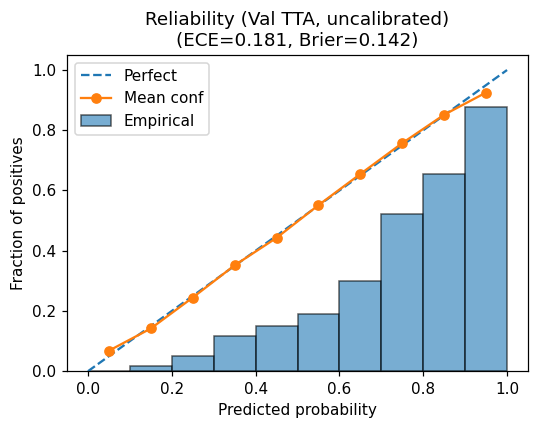

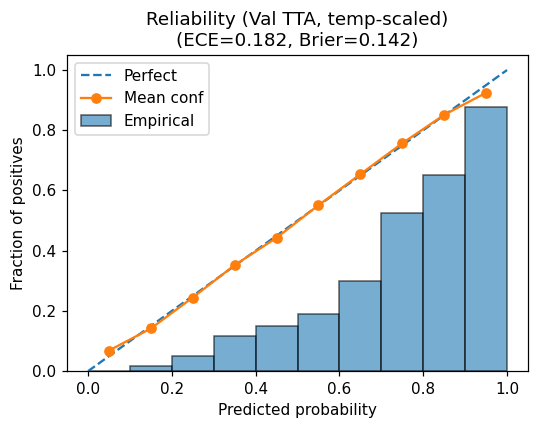

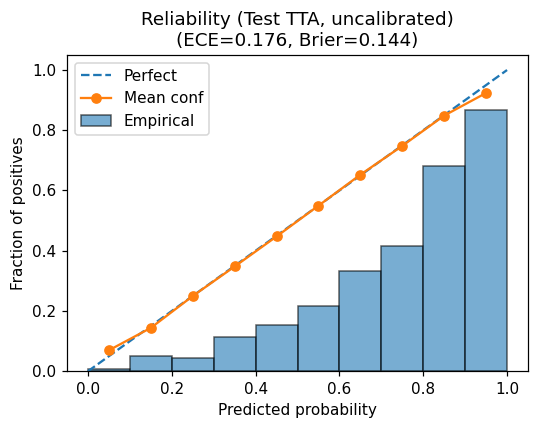

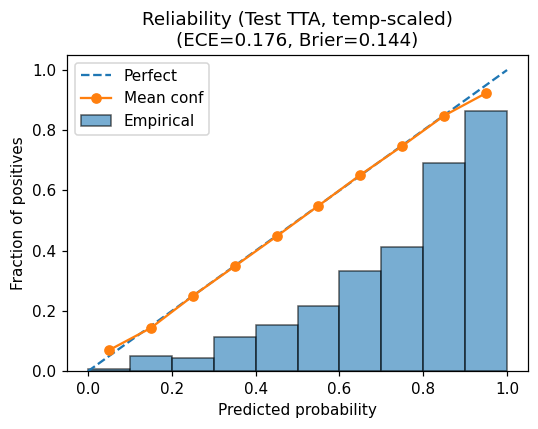

{'ece': 0.17571057965944634,
 'mce': 0.3355241152475771,
 'brier': 0.14434081125043133,
 'bin_acc': array([0.00865801, 0.04918033, 0.04273504, 0.1122449 , 0.15189873,
        0.21621622, 0.33333333, 0.41237113, 0.68965517, 0.86486486]),
 'bin_conf': array([0.06973047, 0.14361829, 0.24962417, 0.34830481, 0.44770581,
        0.54943885, 0.65179576, 0.74789525, 0.84866679, 0.9234817 ]),
 'bin_centers': array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]),
 'bin_counts': array([231, 244, 117,  98,  79,  74,  75,  97, 116,  74])}

In [37]:
T_opt = tune_temperature(model, dl_val, device)

temp_path = os.path.join(OUT_DIR, "best_temperature.txt")
with open(temp_path, "w") as f:
    f.write(f"{T_opt:.6f}\n")
print(f"[Calib] Saved temperature to: {temp_path}")

def apply_temperature_to_probs(probs, T):
    probs = np.asarray(probs, dtype=np.float64).ravel()
    eps = 1e-7
    probs = np.clip(probs, eps, 1.0 - eps)
    logits = np.log(probs / (1.0 - probs))
    logits_T = logits / float(T)
    probs_T = 1.0 / (1.0 + np.exp(-logits_T))
    return probs_T


def compute_metrics_from_probs(y_true, y_prob, threshold=0.5):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_prob = np.asarray(y_prob).ravel()
    y_pred = (y_prob >= threshold).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # specificity
    try:
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")
    except Exception:
        spec = float("nan")

    try:
        roc = roc_auc_score(y_true, y_prob)
    except Exception:
        roc = float("nan")

    try:
        pr  = average_precision_score(y_true, y_prob)
    except Exception:
        pr  = float("nan")

    return {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "spec": spec,
        "roc_auc": roc,
        "pr_auc": pr,
    }

val_metrics_cal_notta,  yv_cal_notta,  pv_cal_notta,  sv_cal_notta  = evaluate(
    model, dl_val,  device, cls_threshold=0.5, temperature=T_opt
)
test_metrics_cal_notta, yt_cal_notta, pt_cal_notta, st_cal_notta = evaluate(
    model, dl_test, device, cls_threshold=0.5, temperature=T_opt
)

print("\n[Val noTTA]  before calibration:", val_metrics_notta)
print("[Val noTTA]  after  calibration:",  val_metrics_cal_notta)

print("\n[Test noTTA] before calibration:", test_metrics_notta)
print("[Test noTTA] after  calibration:",  test_metrics_cal_notta)

# ECE / Brier
cal_val_notta_before = compute_calibration_metrics(yv_notta,      sv_notta,      n_bins=10)
cal_val_notta_after  = compute_calibration_metrics(yv_cal_notta,  sv_cal_notta,  n_bins=10)

cal_test_notta_before = compute_calibration_metrics(yt_notta,     st_notta,     n_bins=10)
cal_test_notta_after  = compute_calibration_metrics(yt_cal_notta, st_cal_notta, n_bins=10)

print("\n[Val noTTA]  ECE before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_val_notta_before["ece"], cal_val_notta_after["ece"],
    cal_val_notta_before["ece"] - cal_val_notta_after["ece"]
))
print("[Val noTTA]  Brier before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_val_notta_before["brier"], cal_val_notta_after["brier"],
    cal_val_notta_before["brier"] - cal_val_notta_after["brier"]
))

print("\n[Test noTTA] ECE before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_test_notta_before["ece"], cal_test_notta_after["ece"],
    cal_test_notta_before["ece"] - cal_test_notta_after["ece"]
))
print("[Test noTTA] Brier before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_test_notta_before["brier"], cal_test_notta_after["brier"],
    cal_test_notta_before["brier"] - cal_test_notta_after["brier"]
))

# Reliability (noTTA）
plot_reliability_diagram(
    yv_notta, sv_notta,
    out_path=os.path.join(OUT_DIR, "val_notta_reliability_before.png"),
    n_bins=10,
    title="Reliability (Val noTTA, uncalibrated)"
)

plot_reliability_diagram(
    yv_cal_notta, sv_cal_notta,
    out_path=os.path.join(OUT_DIR, "val_notta_reliability_after_temp.png"),
    n_bins=10,
    title="Reliability (Val noTTA, temp-scaled)"
)

plot_reliability_diagram(
    yt_notta, st_notta,
    out_path=os.path.join(OUT_DIR, "test_notta_reliability_before.png"),
    n_bins=10,
    title="Reliability (Test noTTA, uncalibrated)"
)

plot_reliability_diagram(
    yt_cal_notta, st_cal_notta,
    out_path=os.path.join(OUT_DIR, "test_notta_reliability_after_temp.png"),
    n_bins=10,
    title="Reliability (Test noTTA, temp-scaled)"
)

sv_val_tta_cal  = apply_temperature_to_probs(sv_tta,  T_opt)
st_test_tta_cal = apply_temperature_to_probs(st_tta, T_opt)

val_metrics_cal_tta  = compute_metrics_from_probs(yv_tta, sv_val_tta_cal,  threshold=0.5)
test_metrics_cal_tta = compute_metrics_from_probs(yt_tta, st_test_tta_cal, threshold=0.5)

print("\n[Val TTA]  before calibration:", val_metrics_tta)
print("[Val TTA]  after  calibration:",  val_metrics_cal_tta)

print("\n[Test TTA] before calibration:", test_metrics_tta)
print("[Test TTA] after  calibration:",  test_metrics_cal_tta)

# ECE / Brier（TTA）
cal_val_tta_before = compute_calibration_metrics(yv_tta,      sv_tta,         n_bins=10)
cal_val_tta_after  = compute_calibration_metrics(yv_tta,      sv_val_tta_cal, n_bins=10)

cal_test_tta_before = compute_calibration_metrics(yt_tta,     st_tta,        n_bins=10)
cal_test_tta_after  = compute_calibration_metrics(yt_tta,     st_test_tta_cal, n_bins=10)

print("\n[Val TTA]  ECE before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_val_tta_before["ece"], cal_val_tta_after["ece"],
    cal_val_tta_before["ece"] - cal_val_tta_after["ece"]
))
print("[Val TTA]  Brier before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_val_tta_before["brier"], cal_val_tta_after["brier"],
    cal_val_tta_before["brier"] - cal_val_tta_after["brier"]
))

print("\n[Test TTA] ECE before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_test_tta_before["ece"], cal_test_tta_after["ece"],
    cal_test_tta_before["ece"] - cal_test_tta_after["ece"]
))
print("[Test TTA] Brier before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_test_tta_before["brier"], cal_test_tta_after["brier"],
    cal_test_tta_before["brier"] - cal_test_tta_after["brier"]
))

# Reliability（TTA）
plot_reliability_diagram(
    yv_tta, sv_tta,
    out_path=os.path.join(OUT_DIR, "val_tta_reliability_before.png"),
    n_bins=10,
    title="Reliability (Val TTA, uncalibrated)"
)

plot_reliability_diagram(
    yv_tta, sv_val_tta_cal,
    out_path=os.path.join(OUT_DIR, "val_tta_reliability_after_temp.png"),
    n_bins=10,
    title="Reliability (Val TTA, temp-scaled)"
)

plot_reliability_diagram(
    yt_tta, st_tta,
    out_path=os.path.join(OUT_DIR, "test_tta_reliability_before.png"),
    n_bins=10,
    title="Reliability (Test TTA, uncalibrated)"
)

plot_reliability_diagram(
    yt_tta, st_test_tta_cal,
    out_path=os.path.join(OUT_DIR, "test_tta_reliability_after_temp.png"),
    n_bins=10,
    title="Reliability (Test TTA, temp-scaled)"
)

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ece_brier_comparison(
    cal_notta_before: dict,
    cal_notta_after: dict,
    cal_tta_before: dict,
    cal_tta_after: dict,
    split_name: str,
    out_dir: str,
):
    labels = ["noTTA-before", "noTTA-after", "TTA-before", "TTA-after"]

    eces = [
        cal_notta_before["ece"],
        cal_notta_after["ece"],
        cal_tta_before["ece"],
        cal_tta_after["ece"],
    ]
    briers = [
        cal_notta_before["brier"],
        cal_notta_after["brier"],
        cal_tta_before["brier"],
        cal_tta_after["brier"],
    ]

    x = np.arange(len(labels))

    # ECA comparison
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x, eces)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=20)
    ax.set_ylabel("ECE")
    ax.set_title(f"{split_name} ECE (noTTA vs TTA, before/after calibration)")
    ax.grid(axis="y", alpha=0.3)
    plt.show()
    plt.tight_layout()

    ece_path = os.path.join(out_dir, f"{split_name.lower()}_ece_notta_vs_tta.png")
    plt.savefig(ece_path, dpi=300)
    plt.show()
    plt.close(fig)
    print(f"[Plot] Saved ECE comparison to: {ece_path}")

    # Brier comparison
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x, briers)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=20)
    ax.set_ylabel("Brier score")
    ax.set_title(f"{split_name} Brier (noTTA vs TTA, before/after calibration)")
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()

    brier_path = os.path.join(out_dir, f"{split_name.lower()}_brier_notta_vs_tta.png")
    plt.savefig(brier_path, dpi=300)
    plt.show
    plt.close(fig)
    print(f"[Plot] Saved Brier comparison to: {brier_path}")

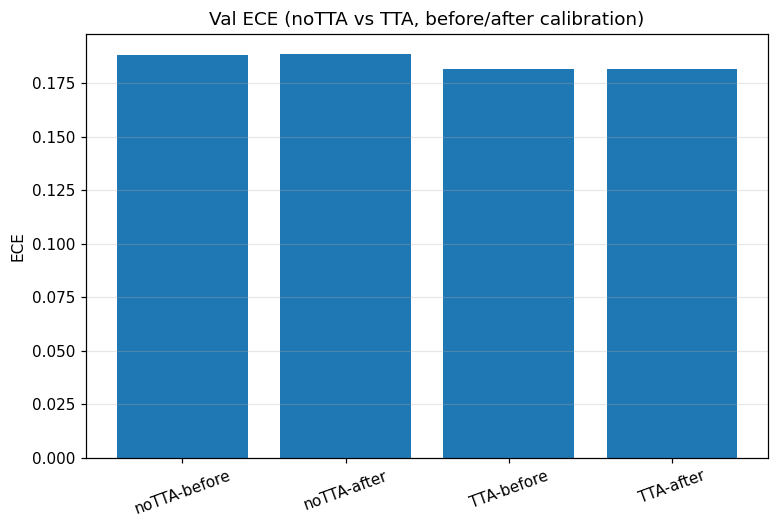

<Figure size 704x528 with 0 Axes>

[Plot] Saved ECE comparison to: ./Baseline+ECA(7000,256)_Output\val_ece_notta_vs_tta.png
[Plot] Saved Brier comparison to: ./Baseline+ECA(7000,256)_Output\val_brier_notta_vs_tta.png


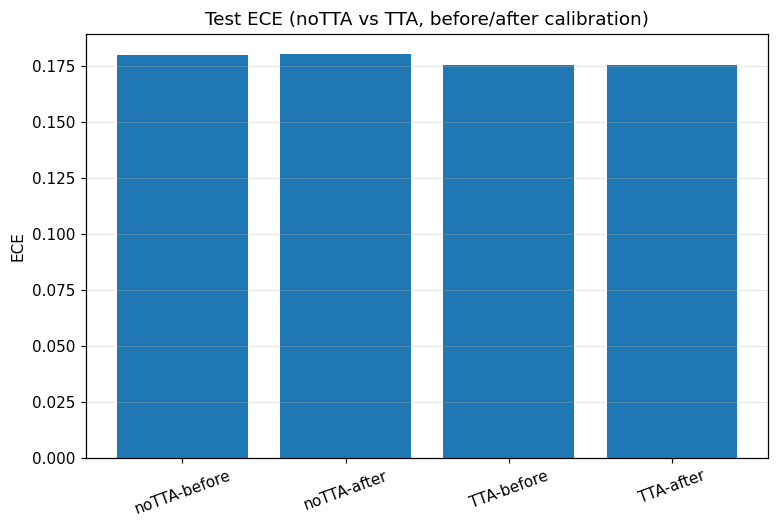

<Figure size 704x528 with 0 Axes>

[Plot] Saved ECE comparison to: ./Baseline+ECA(7000,256)_Output\test_ece_notta_vs_tta.png
[Plot] Saved Brier comparison to: ./Baseline+ECA(7000,256)_Output\test_brier_notta_vs_tta.png


In [39]:
# ECE/Brier on Val
plot_ece_brier_comparison(
    cal_notta_before=cal_val_notta_before,
    cal_notta_after=cal_val_notta_after,
    cal_tta_before=cal_val_tta_before,
    cal_tta_after=cal_val_tta_after,
    split_name="Val",
    out_dir=OUT_DIR,
)

# ECE/Brier on Test
plot_ece_brier_comparison(
    cal_notta_before=cal_test_notta_before,
    cal_notta_after=cal_test_notta_after,
    cal_tta_before=cal_test_tta_before,
    cal_tta_after=cal_test_tta_after,
    split_name="Test",
    out_dir=OUT_DIR,
)

### 18.3 Plots

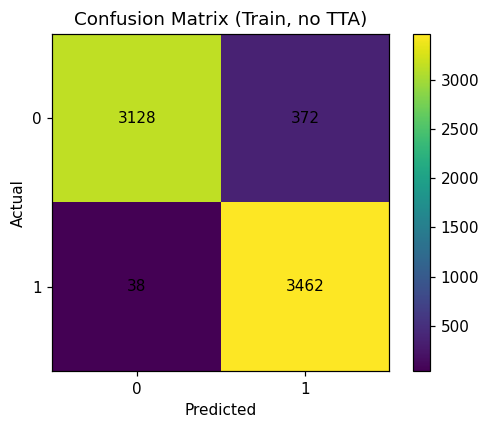

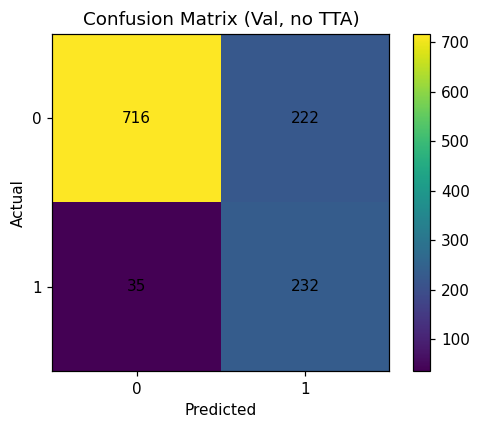

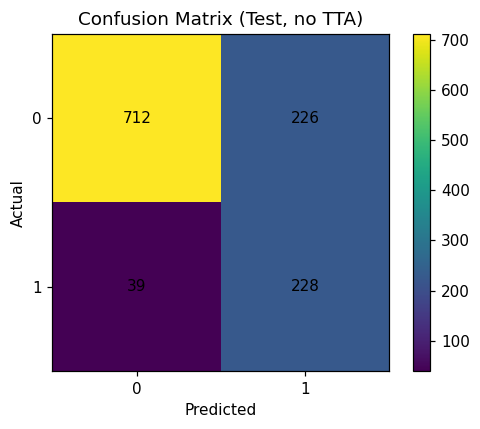

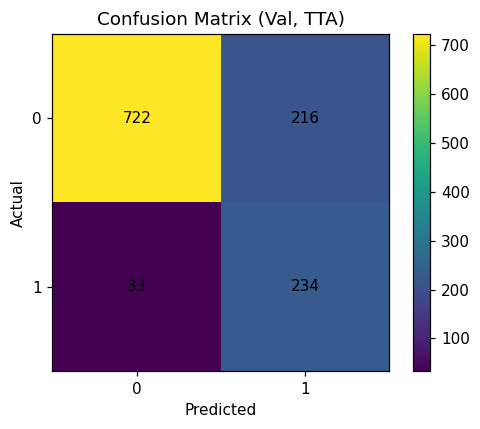

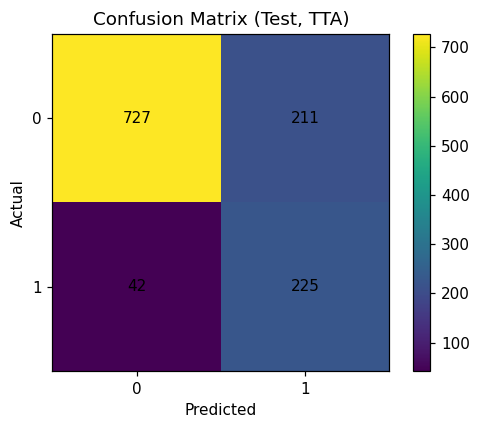

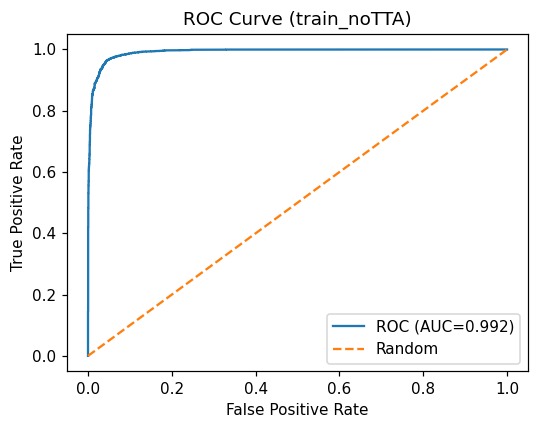

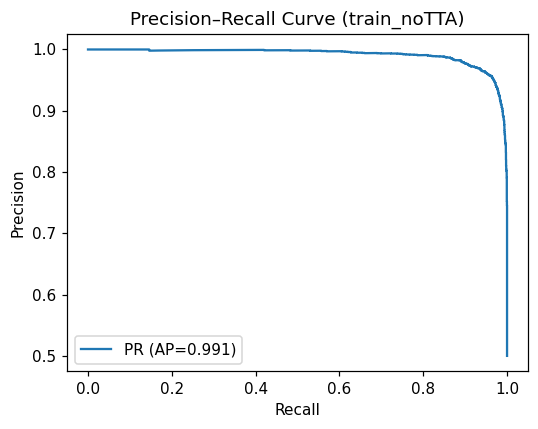

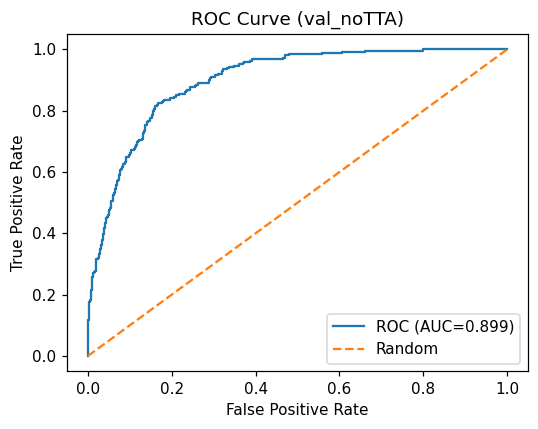

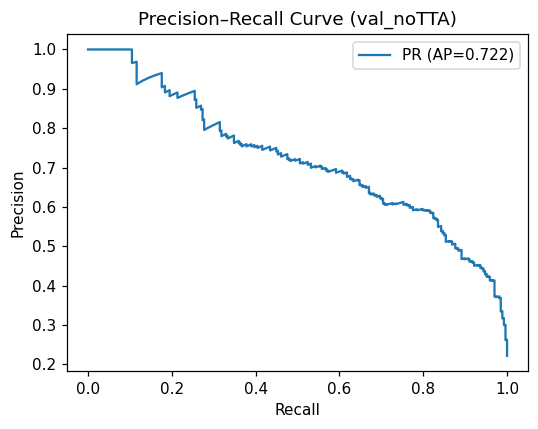

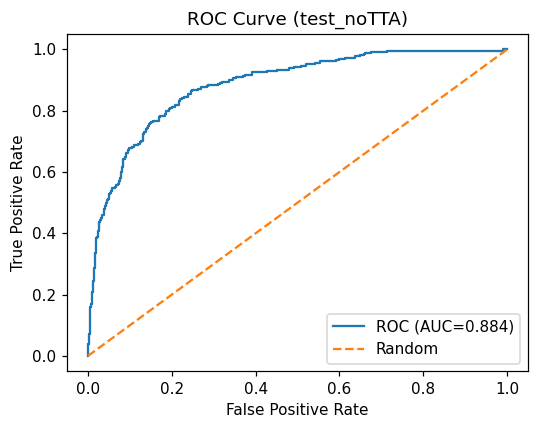

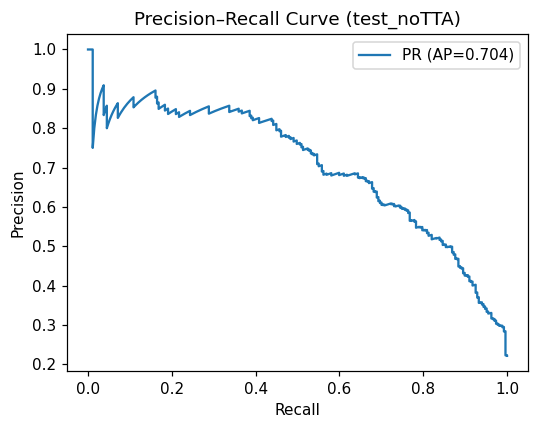

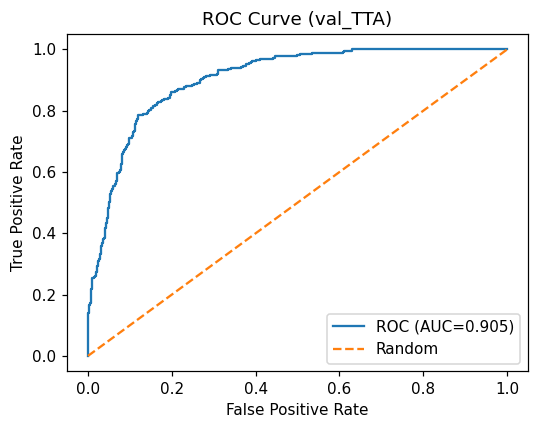

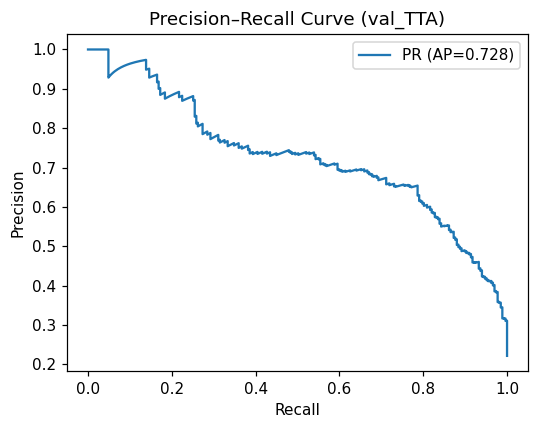

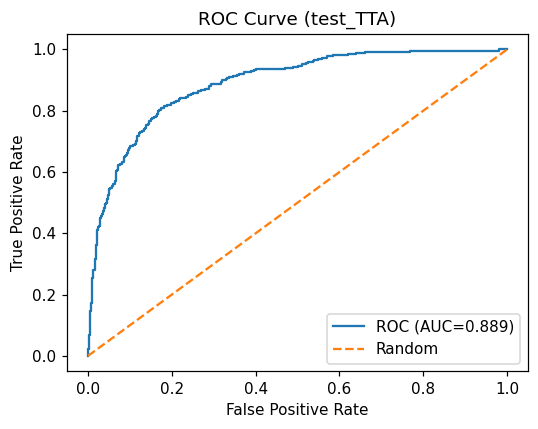

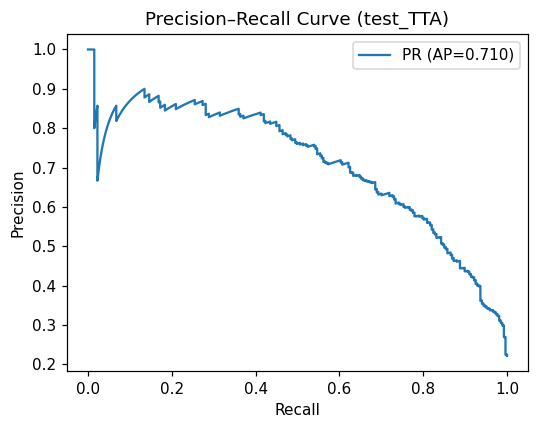

In [40]:
# ==========================
# Confusion matrices
# ==========================
plot_confusion_matrix(
    ytr_best, ptr_best,
    out_path=os.path.join(OUT_DIR, "confmat_train_notta.png"),
    title="Confusion Matrix (Train, no TTA)"
)

plot_confusion_matrix(
    yv_notta, pv_notta,
    out_path=os.path.join(OUT_DIR, "confmat_val_notta.png"),
    title="Confusion Matrix (Val, no TTA)"
)

plot_confusion_matrix(
    yt_notta, pt_notta,
    out_path=os.path.join(OUT_DIR, "confmat_test_notta.png"),
    title="Confusion Matrix (Test, no TTA)"
)

plot_confusion_matrix(
    yv_tta, pv_tta,
    out_path=os.path.join(OUT_DIR, "confmat_val_tta.png"),
    title="Confusion Matrix (Val, TTA)"
)

plot_confusion_matrix(
    yt_tta, pt_tta,
    out_path=os.path.join(OUT_DIR, "confmat_test_tta.png"),
    title="Confusion Matrix (Test, TTA)"
)

# ==========================
# ROC / PR curves
# ==========================

# 1) Train（本来就没 TTA）
plot_roc_pr(
    y_true=ytr_best,
    y_score=str_best,
    out_dir=OUT_DIR,
    prefix="train_noTTA",
    roc_auc=train_metrics_best["roc_auc"],
    pr_auc=train_metrics_best["pr_auc"],
)

# 2) Val / Test：no TTA
plot_roc_pr(
    y_true=yv_notta,
    y_score=sv_notta,
    out_dir=OUT_DIR,
    prefix="val_noTTA",
    roc_auc=val_metrics_notta["roc_auc"],
    pr_auc=val_metrics_notta["pr_auc"],
)

plot_roc_pr(
    y_true=yt_notta,
    y_score=st_notta,
    out_dir=OUT_DIR,
    prefix="test_noTTA",
    roc_auc=test_metrics_notta["roc_auc"],
    pr_auc=test_metrics_notta["pr_auc"],
)

# 3) Val / Test：TTA
plot_roc_pr(
    y_true=yv_tta,
    y_score=sv_tta,
    out_dir=OUT_DIR,
    prefix="val_TTA",
    roc_auc=val_metrics_tta["roc_auc"],
    pr_auc=val_metrics_tta["pr_auc"],
)

plot_roc_pr(
    y_true=yt_tta,
    y_score=st_tta,
    out_dir=OUT_DIR,
    prefix="test_TTA",
    roc_auc=test_metrics_tta["roc_auc"],
    pr_auc=test_metrics_tta["pr_auc"],
)


### 18.3 Train/Val/Test Comparison

[Debug] metrics_df columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
[Info] Saved metrics summary to: ./Baseline+ECA(7000,256)_Output\metrics_summary_base6.csv


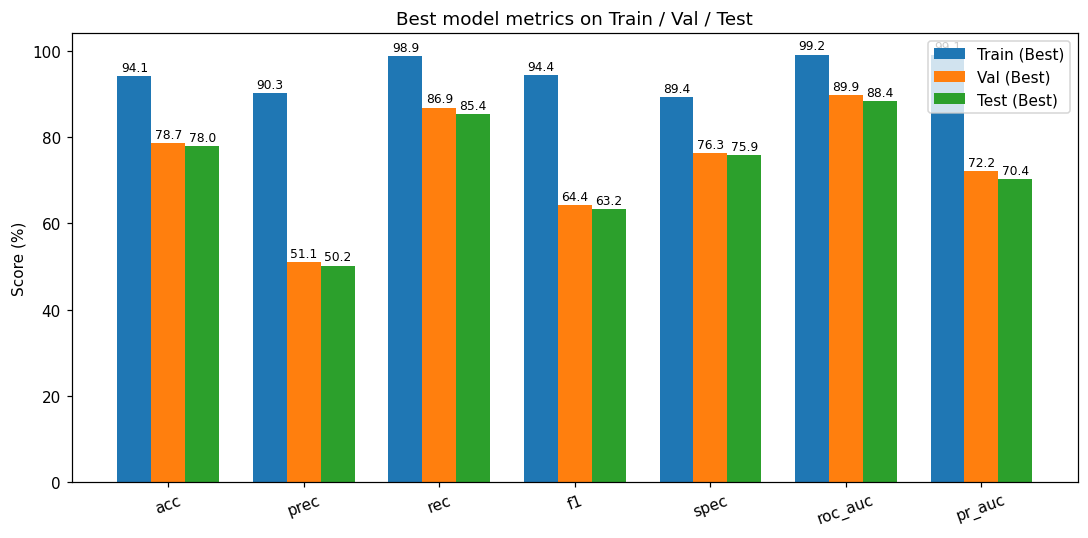

[Info] Saved: ./Baseline+ECA(7000,256)_Output\metrics_bar_train_val_test_best.png


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rows = [
    {"Split": "Train (Best)", **train_pct},
    {"Split": "Val (Best)",   **val_pct},
    {"Split": "Test (Best)",  **test_pct},
]

metrics_df = pd.DataFrame(rows)

metric_cols = [c for c in metrics_df.columns if c != "Split"]
metrics_df = metrics_df[["Split"] + metric_cols]

print("[Debug] metrics_df columns:", list(metrics_df.columns))

metrics_csv_path = os.path.join(OUT_DIR, "metrics_summary_base6.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"[Info] Saved metrics summary to: {metrics_csv_path}")

x = np.arange(len(metric_cols)) 
width = 0.25                 

plt.figure(figsize=(10, 5))

for i, split in enumerate(metrics_df["Split"]):
    values = metrics_df.loc[i, metric_cols].values.astype(float)
    offset = (i - 1) * width  
    bars = plt.bar(x + offset, values, width, label=split)

    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=8)

xtick_labels = [
    c.replace("(%)", "").replace("%", "").strip()
    for c in metric_cols
]

plt.xticks(x, xtick_labels, rotation=20)
plt.ylabel("Score (%)")
plt.title("Best model metrics on Train / Val / Test")
plt.legend()
plt.tight_layout()

bar_fig_path = os.path.join(OUT_DIR, "metrics_bar_train_val_test_best.png")
plt.savefig(bar_fig_path, dpi=300)
plt.show()
print(f"[Info] Saved: {bar_fig_path}")


### 18.4 Seg

In [42]:
def compute_dice_iou(preds: torch.Tensor, targets: torch.Tensor, eps: float = 1e-6):
    preds_f   = preds.view(preds.size(0), -1)
    targets_f = targets.view(targets.size(0), -1)

    inter = (preds_f * targets_f).sum(dim=1)
    union = preds_f.sum(dim=1) + targets_f.sum(dim=1)

    dice = (2.0 * inter + eps) / (union + eps)

    iou_den = (preds_f + targets_f - preds_f * targets_f).sum(dim=1)
    iou = (inter + eps) / (iou_den + eps)

    return dice, iou


def denormalize(img_tensor: torch.Tensor):
    img = img_tensor.detach().cpu().clone()
    img = img * 0.25 + 0.5   # x * std + mean
    img = img.clamp(0.0, 1.0)
    return img.squeeze(0).numpy()

@torch.no_grad()
def visualize_segmentation_examples(
    model,
    loader,
    device,
    threshold: float = 0.5,
    num_pos: int = 2,
    num_neg: int = 2,
    num_hard: int = 2,
    save_dir: str = None,
    prefix: str = "seg_example",
):

    model.eval()
    pos_shown = neg_shown = hard_shown = 0
    example_idx = 0 

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    for xb, yb, mb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        mb = mb.to(device, non_blocking=True)

        out = model(xb)
        if isinstance(out, tuple):
            _, seg_logits = out  # (cls_logits, seg_logits)
        else:
            raise ValueError("Model output must be (cls_logits, seg_logits)")

        # [B,1,H,W]
        probs = torch.sigmoid(seg_logits)
        preds = (probs >= threshold).float()

        dice_batch, iou_batch = compute_dice_iou(preds, mb)

        for i in range(xb.size(0)):
            dice_val = float(dice_batch[i].cpu().item())
            iou_val  = float(iou_batch[i].cpu().item())
            label    = int(yb[i].cpu().item())

            category = None
            title_suffix = ""

            if label == 1 and dice_val >= 0.8 and pos_shown < num_pos:
                category = "pos"
                title_suffix = f"Positive, easy (Dice={dice_val:.2f}, IoU={iou_val:.2f})"

            elif label == 0 and dice_val >= 0.95 and neg_shown < num_neg:
                category = "neg"
                title_suffix = f"Negative (Dice={dice_val:.2f}, IoU={iou_val:.2f})"

            elif label == 1 and 0.3 <= dice_val <= 0.7 and hard_shown < num_hard:
                category = "hard"
                title_suffix = f"Positive, hard (Dice={dice_val:.2f}, IoU={iou_val:.2f})"

            if category is None:
                continue

            img_np  = denormalize(xb[i])                # [H,W]
            gt_mask = mb[i].detach().cpu().numpy().squeeze()   # [H,W]
            pr_mask = preds[i].detach().cpu().numpy().squeeze() # [H,W]

            fig, axes = plt.subplots(1, 3, figsize=(12, 4))

            axes[0].imshow(img_np, cmap="gray")
            axes[0].set_title(f"Image (label={label})")
            axes[0].axis("off")

            axes[1].imshow(img_np, cmap="gray")
            axes[1].imshow(gt_mask, cmap="jet", alpha=0.4)
            axes[1].set_title("Ground Truth mask (overlay)")
            axes[1].axis("off")

            axes[2].imshow(img_np, cmap="gray")
            axes[2].imshow(pr_mask, cmap="jet", alpha=0.4)
            axes[2].set_title(f"Predicted mask\nDice={dice_val:.2f}, IoU={iou_val:.2f}")
            axes[2].axis("off")

            plt.suptitle(title_suffix)
            plt.tight_layout()

            if save_dir is not None:
                fname = f"{prefix}_{category}_{example_idx}.png"
                fig.savefig(os.path.join(save_dir, fname), dpi=300)

            plt.show()
            example_idx += 1

            if category == "pos":
                pos_shown += 1
            elif category == "neg":
                neg_shown += 1
            elif category == "hard":
                hard_shown += 1

            if pos_shown >= num_pos and neg_shown >= num_neg and hard_shown >= num_hard:
                return

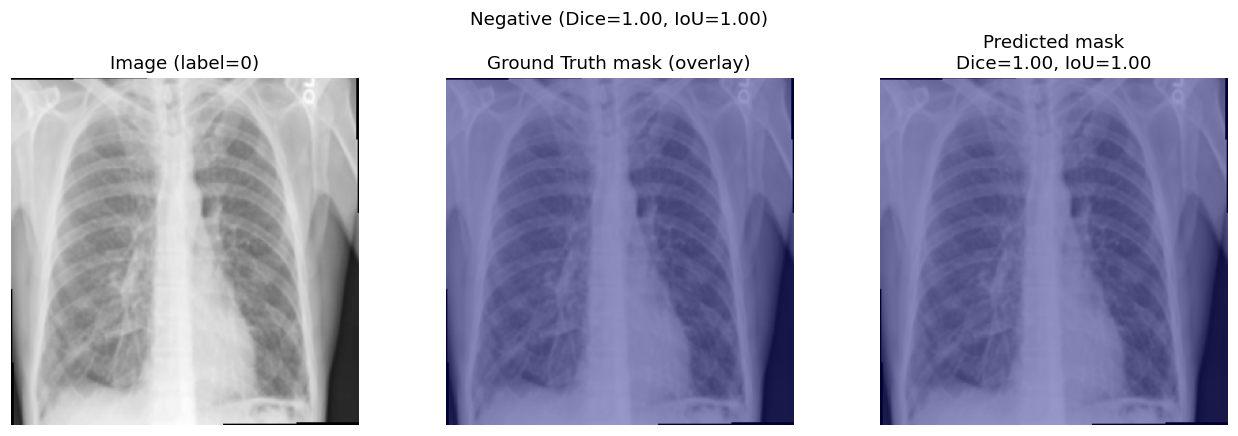

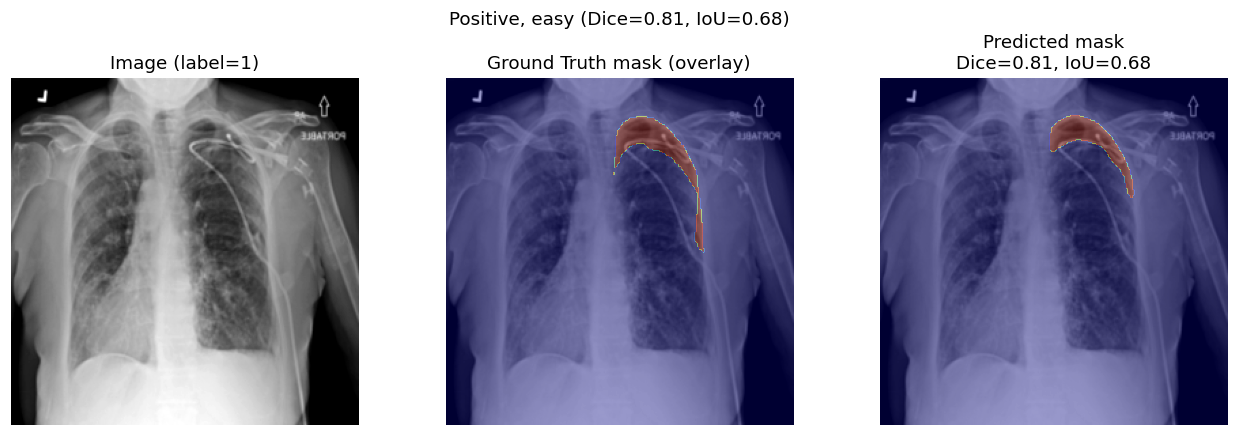

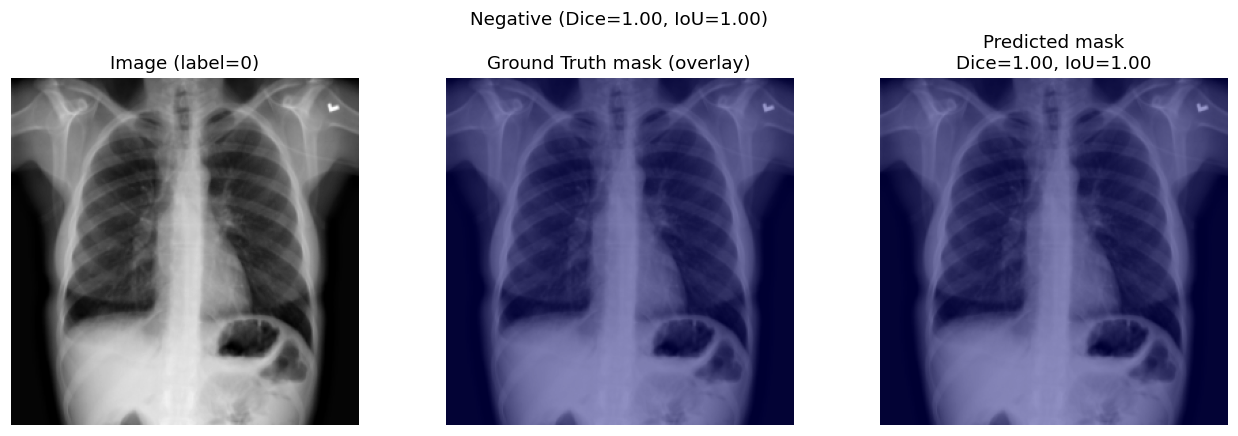

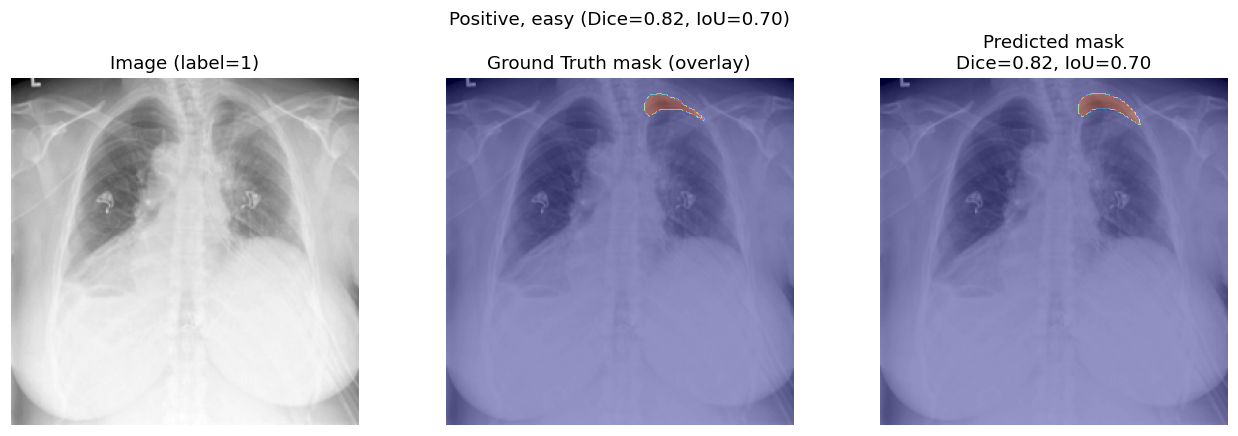

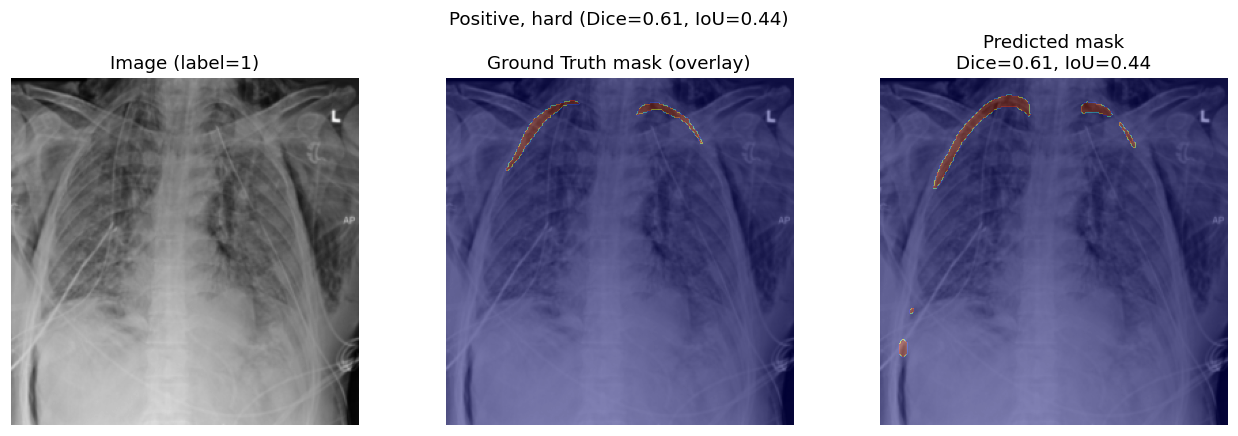

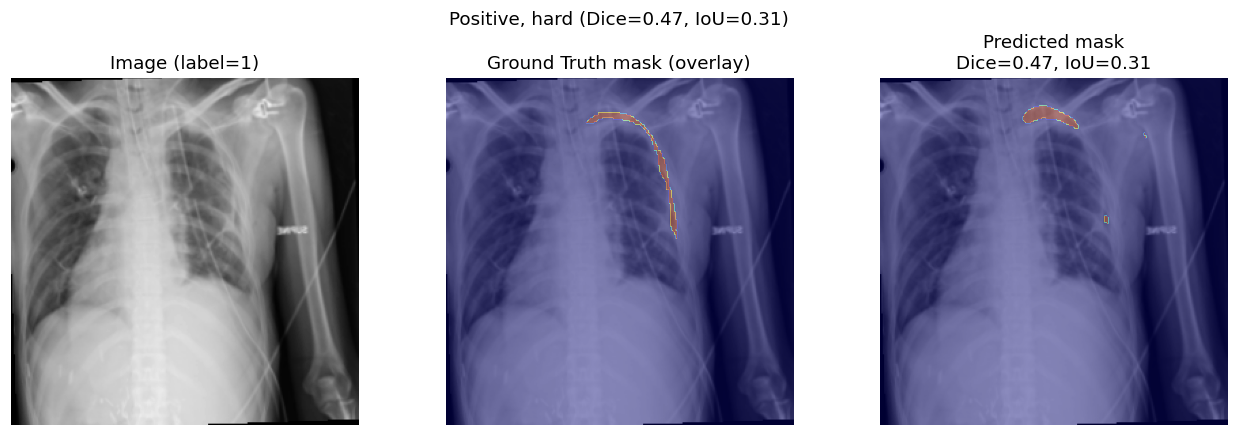

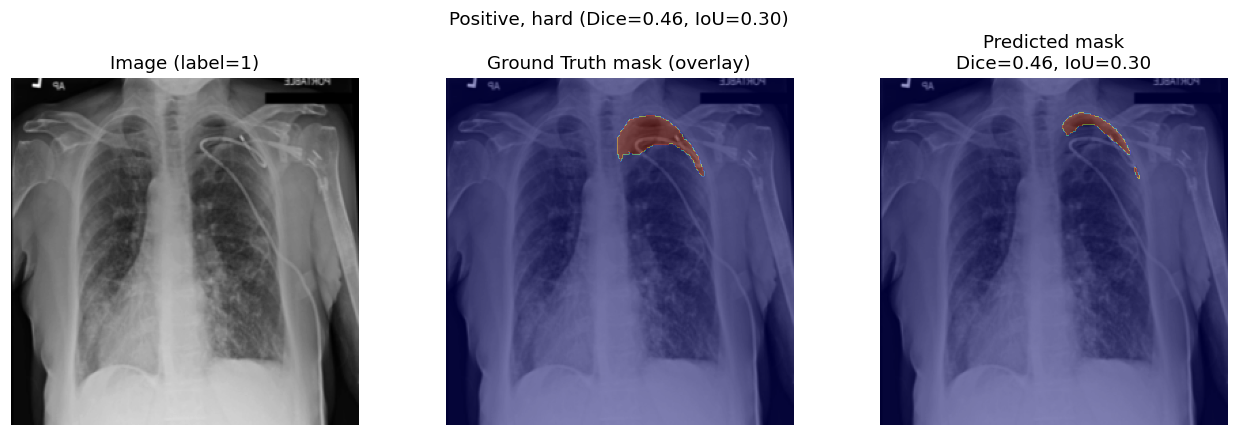

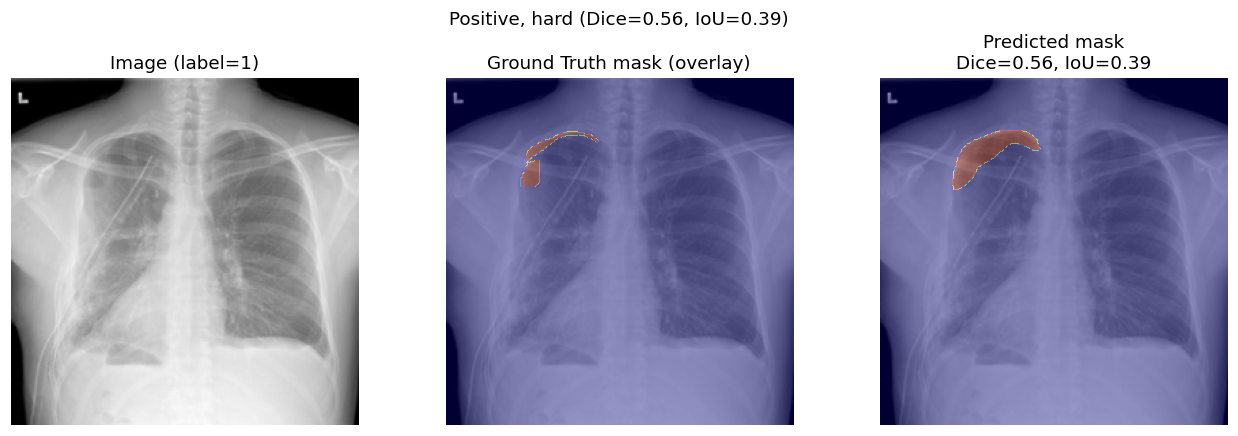

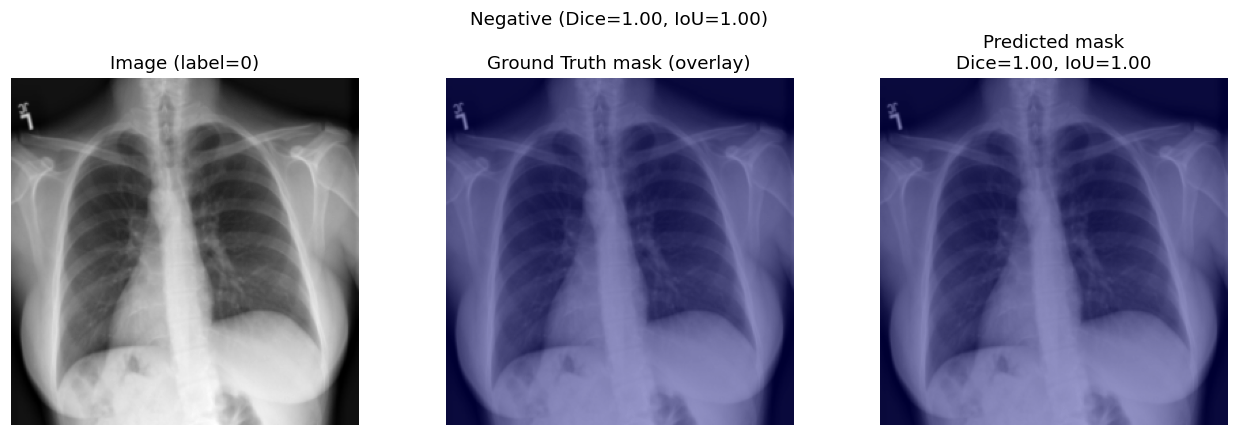

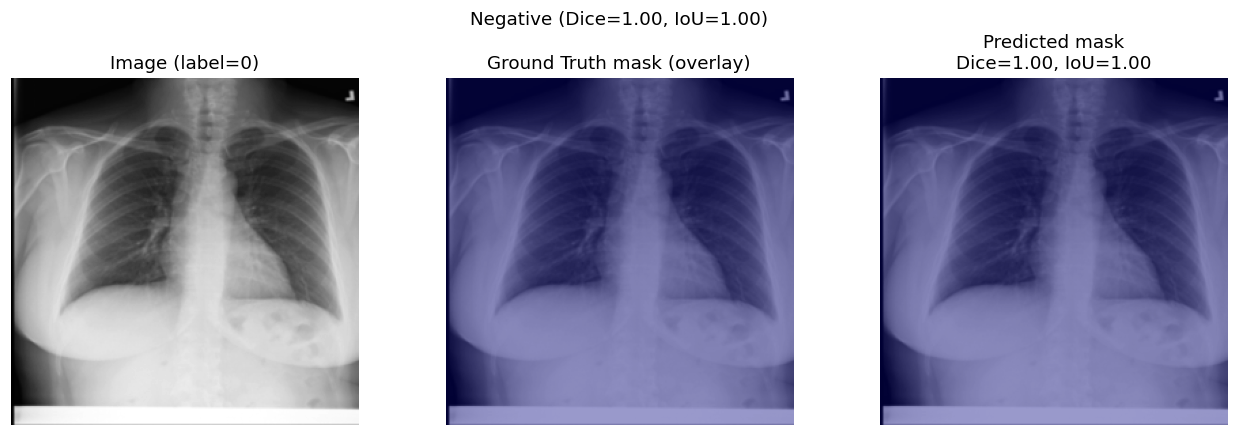

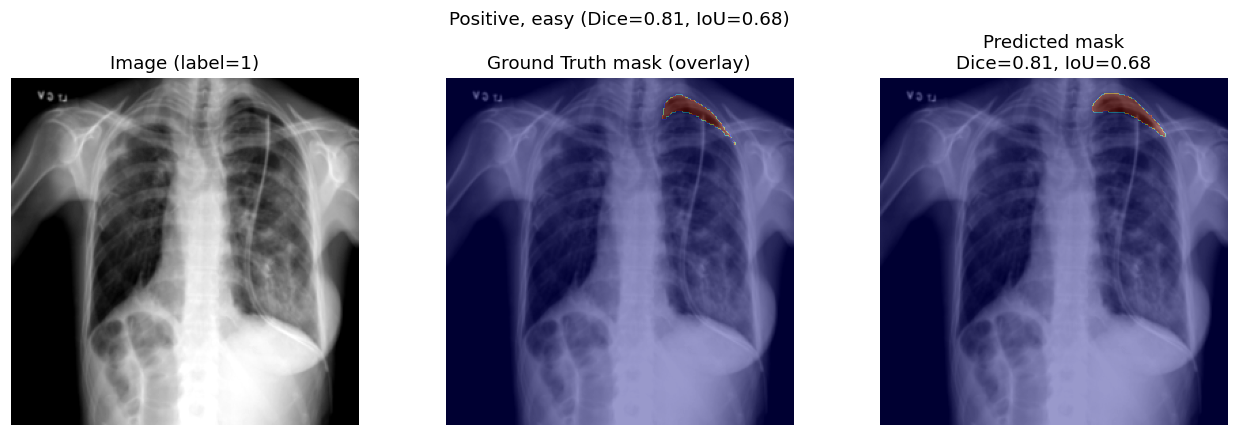

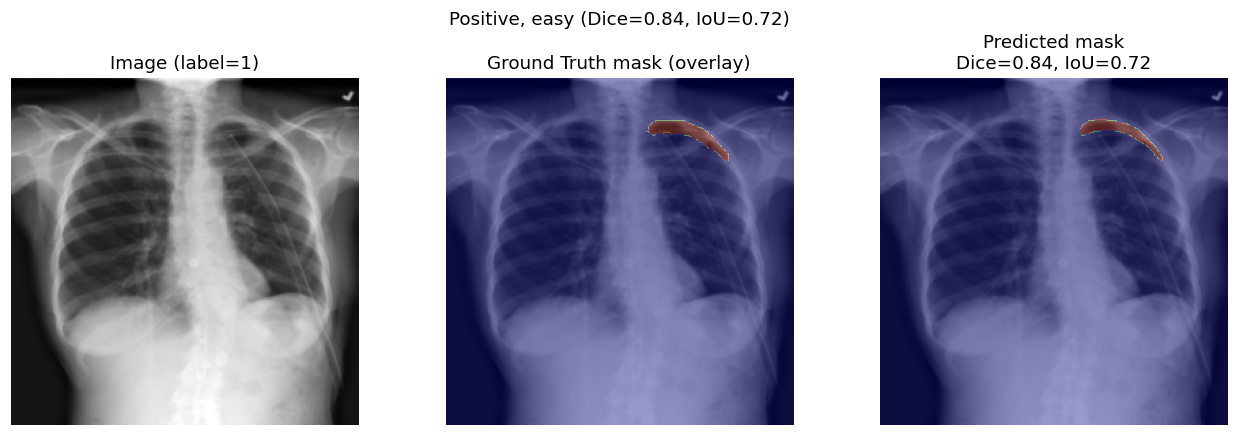

In [43]:
visualize_segmentation_examples(
    model=model,        
    loader=dl_train,    
    device=device,
    threshold=0.5,   
    num_pos=2,
    num_neg=2,
    num_hard=2,
    save_dir=OUT_DIR, 
    prefix="seg_train_examples"
)

eval_mask_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

ds_test_seg = PandasImageMaskDataset(test_df, mask_root=MASK_ROOT, joint_transform=eval_mask_tfms)
dl_test_seg = DataLoader(ds_test_seg, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

visualize_segmentation_examples(
    model=model,
    loader=dl_test_seg,
    device=device,
    threshold=0.5,
    num_pos=2,
    num_neg=2,
    num_hard=2,
    save_dir=OUT_DIR,
    prefix="seg_test_examples"
)


### 18.5 Segmentation metrics on Test set (Dice / IoU + hist) test

Seg Eval (Test):   0%|          | 0/76 [00:00<?, ?it/s]

[Seg @ Test, positive masks only]
Dice: mean=0.4498, median=0.4670
IoU : mean=0.3239, median=0.3047
Num positive masks: 266


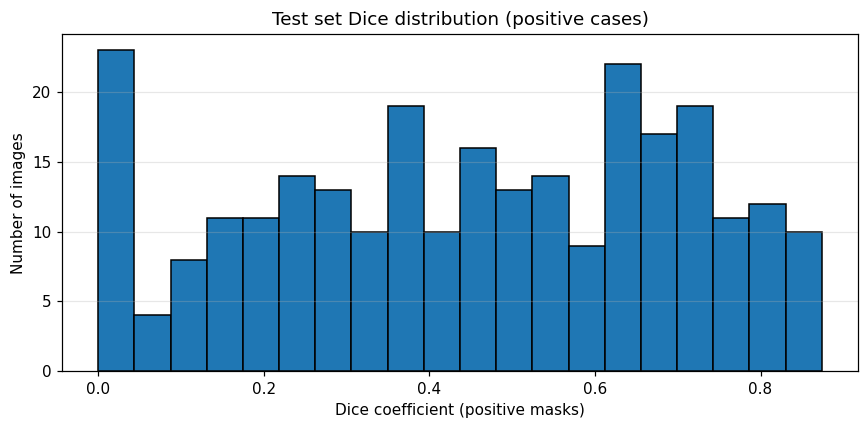

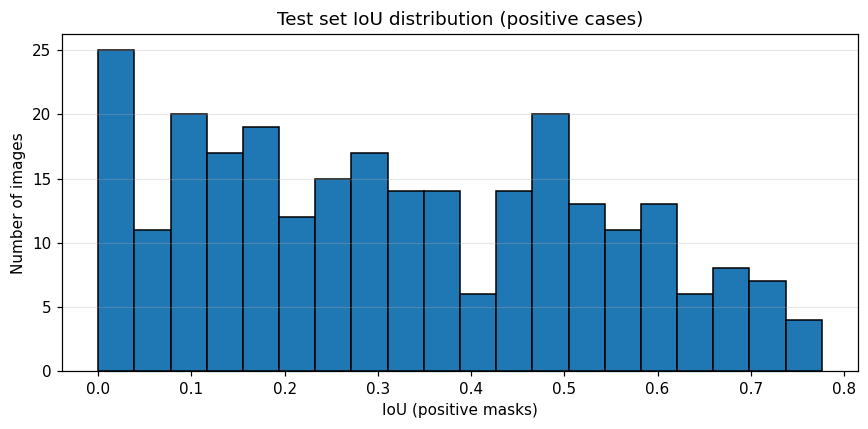

In [44]:
from tqdm.auto import tqdm
model.eval()

all_dice_pos = []
all_iou_pos  = []

with torch.no_grad():
    for xb, yb, mb in tqdm(dl_test_seg, desc="Seg Eval (Test)"):
        xb = xb.to(device)          
        mb = mb.to(device)          # GT mask, [B,1,H,W], 0/1

        cls_logits, seg_logits = model(xb)   # seg_logits: [B,1,H,W]

        seg_probs = torch.sigmoid(seg_logits)
        seg_pred  = (seg_probs > 0.5).float()

        dice_batch, iou_batch = compute_dice_iou(seg_pred, mb) 
        pos_mask = (mb.view(mb.size(0), -1).sum(dim=1) > 0)

        if pos_mask.any():
            all_dice_pos.extend(dice_batch[pos_mask].cpu().numpy().tolist())
            all_iou_pos.extend(iou_batch[pos_mask].cpu().numpy().tolist())

all_dice_pos = np.array(all_dice_pos)
all_iou_pos  = np.array(all_iou_pos)

print(f"[Seg @ Test, positive masks only]")
print(f"Dice: mean={all_dice_pos.mean():.4f}, median={np.median(all_dice_pos):.4f}")
print(f"IoU : mean={all_iou_pos .mean():.4f}, median={np.median(all_iou_pos ):.4f}")
print(f"Num positive masks: {len(all_dice_pos)}")

# np.save(os.path.join(OUT_DIR, "test_seg_dice_pos.npy"), all_dice_pos)
# np.save(os.path.join(OUT_DIR, "test_seg_iou_pos.npy"),  all_iou_pos)

plt.figure(figsize=(8, 4))
plt.hist(all_dice_pos, bins=20, edgecolor="black")
plt.xlabel("Dice coefficient (positive masks)")
plt.ylabel("Number of images")
plt.title("Test set Dice distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "test_seg_dice_hist_pos.png"), dpi=300)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(all_iou_pos, bins=20, edgecolor="black")
plt.xlabel("IoU (positive masks)")
plt.ylabel("Number of images")
plt.title("Test set IoU distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "test_seg_iou_hist_pos.png"), dpi=300)
plt.show()


### 18.6 Segmentation metrics on Test set (Dice / IoU + hist) test

Seg Eval (Train):   0%|          | 0/668 [00:00<?, ?it/s]

[Seg @ Train, positive masks only]
Dice: mean=0.5212, median=0.5651
IoU : mean=0.3891, median=0.3938
Num positive masks: 2376


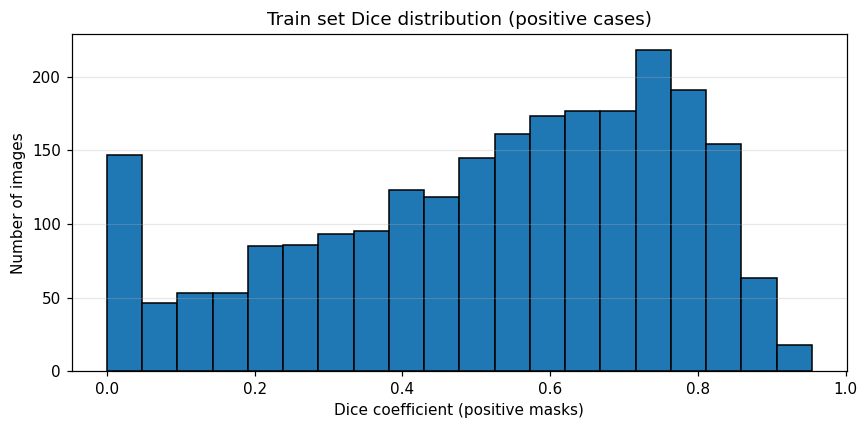

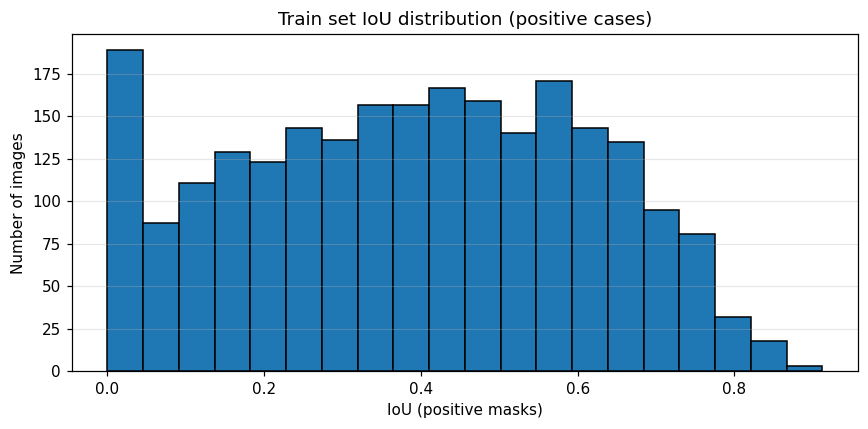

In [45]:
from tqdm.auto import tqdm
model.eval()

eval_train_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

ds_train_seg = PandasImageMaskDataset(train_df, mask_root=MASK_ROOT, joint_transform=eval_train_tfms)
dl_train_seg = DataLoader(ds_train_seg, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

all_dice_pos = []
all_iou_pos  = []

with torch.no_grad():
    for xb, yb, mb in tqdm(dl_train_seg, desc="Seg Eval (Train)"):
        xb = xb.to(device)          
        mb = mb.to(device)          # GT mask, [B,1,H,W], 0/1

        cls_logits, seg_logits = model(xb)   # seg_logits: [B,1,H,W]

        seg_probs = torch.sigmoid(seg_logits)
        seg_pred  = (seg_probs > 0.5).float()

        dice_batch, iou_batch = compute_dice_iou(seg_pred, mb) 
        pos_mask = (mb.view(mb.size(0), -1).sum(dim=1) > 0)

        if pos_mask.any():
            all_dice_pos.extend(dice_batch[pos_mask].cpu().numpy().tolist())
            all_iou_pos.extend(iou_batch[pos_mask].cpu().numpy().tolist())

all_dice_pos = np.array(all_dice_pos)
all_iou_pos  = np.array(all_iou_pos)

print(f"[Seg @ Train, positive masks only]")
print(f"Dice: mean={all_dice_pos.mean():.4f}, median={np.median(all_dice_pos):.4f}")
print(f"IoU : mean={all_iou_pos .mean():.4f}, median={np.median(all_iou_pos ):.4f}")
print(f"Num positive masks: {len(all_dice_pos)}")

# np.save(os.path.join(OUT_DIR, "train_seg_dice_pos.npy"), all_dice_pos)
# np.save(os.path.join(OUT_DIR, "train_seg_iou_pos.npy"),  all_iou_pos)

plt.figure(figsize=(8, 4))
plt.hist(all_dice_pos, bins=20, edgecolor="black")
plt.xlabel("Dice coefficient (positive masks)")
plt.ylabel("Number of images")
plt.title("Train set Dice distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "train_seg_dice_hist_pos.png"), dpi=300)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(all_iou_pos, bins=20, edgecolor="black")
plt.xlabel("IoU (positive masks)")
plt.ylabel("Number of images")
plt.title("Train set IoU distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "train_seg_iou_hist_pos.png"), dpi=300)
plt.show()


### 18.7 Segmentation metrics on Test set (Dice / IoU + hist) val

Seg Eval (Val):   0%|          | 0/76 [00:00<?, ?it/s]

[Seg @ Val, positive masks only]
Dice: mean=0.4196, median=0.4381
IoU : mean=0.3053, median=0.2805
Num positive masks: 267


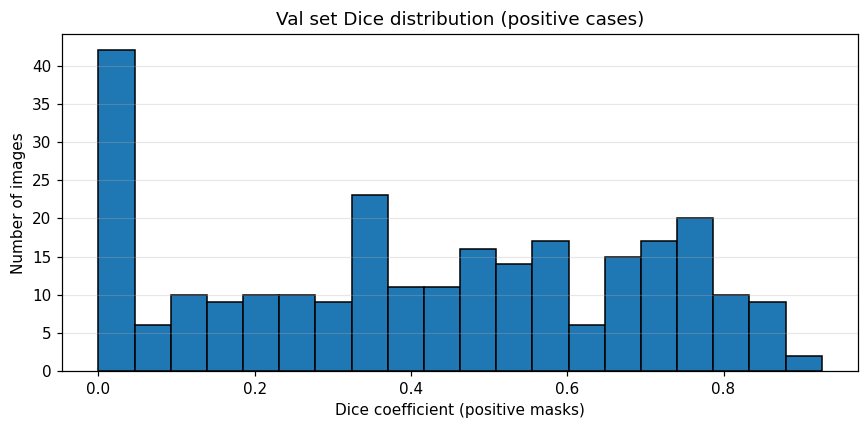

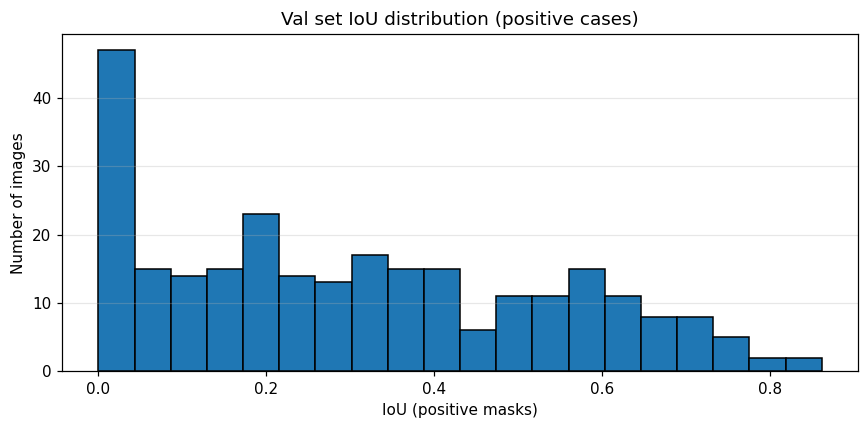

In [46]:
from tqdm.auto import tqdm
model.eval()

eval_val_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

ds_val_seg = PandasImageMaskDataset(val_df, mask_root=MASK_ROOT, joint_transform=eval_val_tfms)
dl_val_seg = DataLoader(ds_val_seg, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

all_dice_pos = []
all_iou_pos  = []

with torch.no_grad():
    for xb, yb, mb in tqdm(dl_val_seg, desc="Seg Eval (Val)"):
        xb = xb.to(device)          
        mb = mb.to(device)          # GT mask, [B,1,H,W], 0/1

        cls_logits, seg_logits = model(xb)   # seg_logits: [B,1,H,W]

        seg_probs = torch.sigmoid(seg_logits)
        seg_pred  = (seg_probs > 0.5).float()

        dice_batch, iou_batch = compute_dice_iou(seg_pred, mb) 
        pos_mask = (mb.view(mb.size(0), -1).sum(dim=1) > 0)

        if pos_mask.any():
            all_dice_pos.extend(dice_batch[pos_mask].cpu().numpy().tolist())
            all_iou_pos.extend(iou_batch[pos_mask].cpu().numpy().tolist())

all_dice_pos = np.array(all_dice_pos)
all_iou_pos  = np.array(all_iou_pos)

print(f"[Seg @ Val, positive masks only]")
print(f"Dice: mean={all_dice_pos.mean():.4f}, median={np.median(all_dice_pos):.4f}")
print(f"IoU : mean={all_iou_pos .mean():.4f}, median={np.median(all_iou_pos ):.4f}")
print(f"Num positive masks: {len(all_dice_pos)}")

# np.save(os.path.join(OUT_DIR, "val_seg_dice_pos.npy"), all_dice_pos)
# np.save(os.path.join(OUT_DIR, "val_seg_iou_pos.npy"),  all_iou_pos)

plt.figure(figsize=(8, 4))
plt.hist(all_dice_pos, bins=20, edgecolor="black")
plt.xlabel("Dice coefficient (positive masks)")
plt.ylabel("Number of images")
plt.title("Val set Dice distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "val_seg_dice_hist_pos.png"), dpi=300)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(all_iou_pos, bins=20, edgecolor="black")
plt.xlabel("IoU (positive masks)")
plt.ylabel("Number of images")
plt.title("Val set IoU distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "val_seg_iou_hist_pos.png"), dpi=300)
plt.show()


## 19. Threshold tunning

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def sweep_thresholds(y_true, y_score, thresholds=None, sort_by="f1", verbose=True):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_score = np.asarray(y_score).ravel()

    if thresholds is None:
        thresholds = np.linspace(0.01, 0.95, 19)

    results = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)

        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)

        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")

        results.append({
            "threshold": t,
            "acc": acc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "spec": spec,
        })

    df_thr = pd.DataFrame(results)
    df_thr_sorted = df_thr.sort_values(sort_by, ascending=False).reset_index(drop=True)

    if verbose:
        print(f"\n=== Top 10 thresholds on val (sorted by {sort_by}) ===")
        tmp = df_thr_sorted.copy()
        for col in ["acc", "prec", "rec", "f1", "spec"]:
            tmp[col] = tmp[col] * 100.0
        print(tmp.head(10).to_string(
            index=False, 
            formatters={
                "threshold": "{:.3f}".format,
                "acc": "{:.3f}".format,
                "prec": "{:.3f}".format,
                "rec": "{:.3f}".format,
                "f1": "{:.3f}".format,
                "spec": "{:.3f}".format
            }
        ))

        best_row = df_thr_sorted.iloc[0]
        print("\nBest threshold on validation set (by {}):".format(sort_by))
        print(
            f"t = {best_row['threshold']:.3f}, "
            f"Acc={best_row['acc']*100:.3f}%, "
            f"Prec={best_row['prec']*100:.3f}%, "
            f"Rec={best_row['rec']*100:.3f}%, "
            f"F1={best_row['f1']*100:.3f}%, "
            f"Spec={best_row['spec']*100:.3f}%"
        )

    return df_thr_sorted


In [48]:
def plot_threshold_metrics(df_thr, out_dir, prefix="val_thr"):
    os.makedirs(out_dir, exist_ok=True)

    thr = df_thr["threshold"].values

    plt.figure(figsize=(6,4))
    for key, label in [
        ("acc",  "Acc"),
        ("f1",   "F1"),
        ("rec",  "Recall"),
        ("spec", "Specificity"),
    ]:
        if key in df_thr.columns:
            plt.plot(thr, df_thr[key].values * 100.0, marker="o", label=label)

    plt.xlabel("Threshold")
    plt.ylabel("Metric (%)")
    plt.title("Metrics vs Threshold (Validation)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_metrics_vs_threshold.png"), dpi=300)
    plt.show()

### 19.1 Find best threshold without calibration


=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.637 83.320 59.066 80.524 68.146 84.115
    0.689 83.734 60.725 75.281 67.224 86.141
    0.584 81.826 56.030 83.521 67.068 81.343
    0.741 84.066 62.799 68.914 65.714 88.380
    0.532 79.751 52.656 85.393 65.143 78.145
    0.793 85.145 68.966 59.925 64.128 92.324
    0.480 78.091 50.323 87.640 63.934 75.373
    0.428 74.855 46.552 91.011 61.597 70.256
    0.376 72.365 44.211 94.382 60.215 66.098
    0.323 69.876 42.105 95.880 58.514 62.473

Best threshold on validation set (by f1):
t = 0.637, Acc=83.320%, Prec=59.066%, Rec=80.524%, F1=68.146%, Spec=84.115%


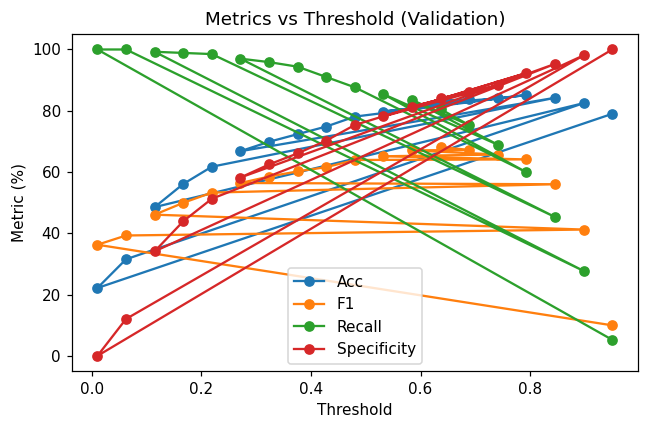


>>> The best threshold on validation set (noTTA): best_t_notta = 0.637
[Info] Saved best noTTA threshold to: ./Baseline+ECA(7000,256)_Output\best_threshold_noTTA.txt

=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.689 85.892 65.495 76.779 70.690 88.486
    0.637 83.817 60.000 80.899 68.900 84.648
    0.741 85.726 67.790 67.790 67.790 90.832
    0.584 82.324 56.888 83.521 67.678 81.983
    0.532 80.664 53.972 86.517 66.475 78.998
    0.480 78.755 51.198 88.015 64.738 76.119
    0.428 76.515 48.394 90.262 63.007 72.601
    0.793 85.477 73.469 53.933 62.203 94.456
    0.376 73.610 45.355 93.258 61.029 68.017
    0.323 70.124 42.237 94.757 58.430 63.113

Best threshold on validation set (by f1):
t = 0.689, Acc=85.892%, Prec=65.495%, Rec=76.779%, F1=70.690%, Spec=88.486%


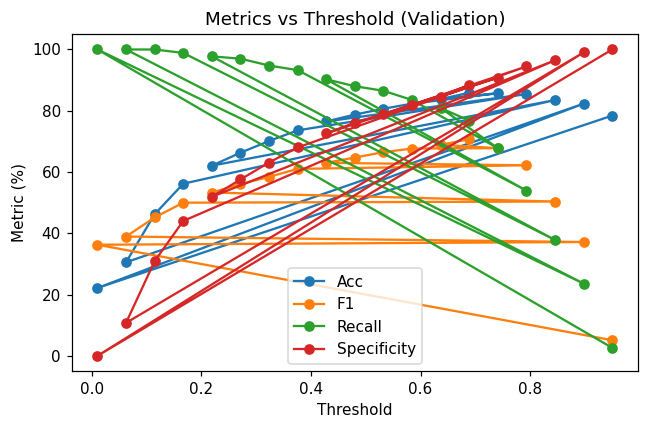


>>> The best threshold on validation set (TTA): best_t_tta = 0.689
[Info] Saved best TTA threshold to: ./Baseline+ECA(7000,256)_Output\best_threshold_TTA.txt

=== Summary: best thresholds on validation set ===
noTTA best_t = 0.637
TTA   best_t = 0.689


In [49]:
# ==========================
# 阈值扫描：noTTA
# ==========================
df_thr_val_notta = sweep_thresholds(
    yv_notta,
    sv_notta,
    sort_by="f1",
    verbose=True,
)
plot_threshold_metrics(
    df_thr_val_notta,
    OUT_DIR,
    prefix="val_thr_noTTA",
)

best_t_notta = float(df_thr_val_notta.iloc[0]["threshold"])
print(f"\n>>> The best threshold on validation set (noTTA): best_t_notta = {best_t_notta:.3f}")

thr_path_notta = os.path.join(OUT_DIR, "best_threshold_noTTA.txt")
with open(thr_path_notta, "w") as f:
    f.write(f"{best_t_notta:.6f}\n")
print(f"[Info] Saved best noTTA threshold to: {thr_path_notta}")


# ==========================
# 阈值扫描：TTA
# ==========================
df_thr_val_tta = sweep_thresholds(
    yv_tta,
    sv_tta,
    sort_by="f1",
    verbose=True,
)
plot_threshold_metrics(
    df_thr_val_tta,
    OUT_DIR,
    prefix="val_thr_TTA",
)

best_t_tta = float(df_thr_val_tta.iloc[0]["threshold"])
print(f"\n>>> The best threshold on validation set (TTA): best_t_tta = {best_t_tta:.3f}")

thr_path_tta = os.path.join(OUT_DIR, "best_threshold_TTA.txt")
with open(thr_path_tta, "w") as f:
    f.write(f"{best_t_tta:.6f}\n")
print(f"[Info] Saved best TTA threshold to: {thr_path_tta}")


# （可选）顺便打印一个对比，方便你写论文
print("\n=== Summary: best thresholds on validation set ===")
print(f"noTTA best_t = {best_t_notta:.3f}")
print(f"TTA   best_t = {best_t_tta:.3f}")


### 19.2 Re-evaluate using best threshold


[Best threshold model noTTA @ Test (t=0.637)]
Accuracy (%)        : 82.158
Precision (%)       : 57.263
Recall (%)          : 76.779
F1-Score (%)        : 65.600
Specificity (%)     : 83.689
ROC-AUC (%)         : 88.376
Precision-recall (%): 70.393

[Best threshold model noTTA @ Val (t=0.637)]
Accuracy (%)        : 83.320
Precision (%)       : 59.066
Recall (%)          : 80.524
F1-Score (%)        : 68.146
Specificity (%)     : 84.115
ROC-AUC (%)         : 89.872
Precision-recall (%): 72.157


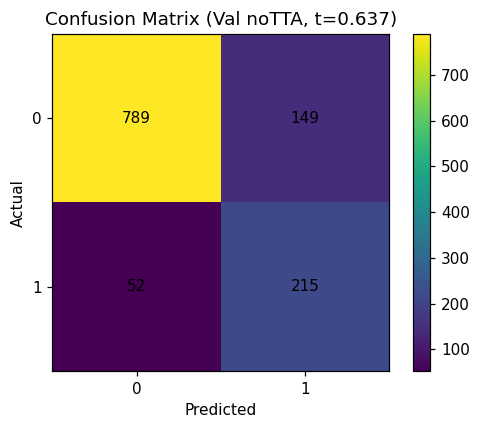

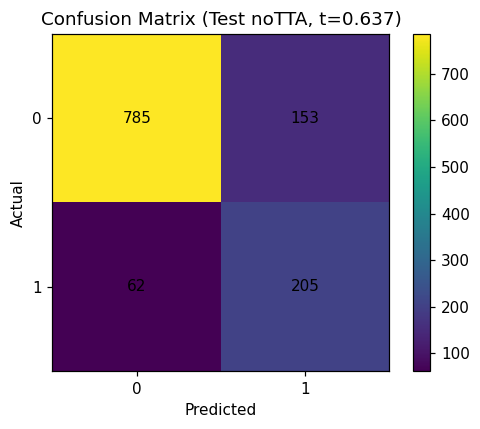


[Best threshold model TTA @ Test (t=0.689)]
Accuracy (%)        : 84.398
Precision (%)       : 63.211
Recall (%)          : 70.787
F1-Score (%)        : 66.784
Specificity (%)     : 88.273
ROC-AUC (%)         : 88.914
Precision-recall (%): 71.029

[Best threshold model TTA @ Val (t=0.689)]
Accuracy (%)        : 85.892
Precision (%)       : 65.495
Recall (%)          : 76.779
F1-Score (%)        : 70.690
Specificity (%)     : 88.486
ROC-AUC (%)         : 90.478
Precision-recall (%): 72.760


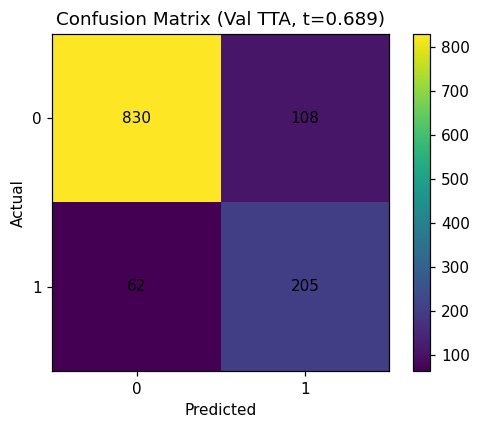

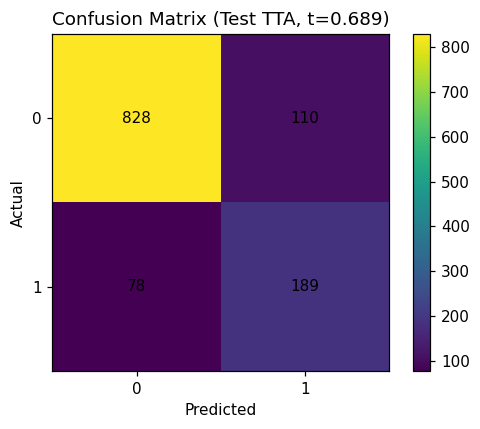


=== Summary: Val/Test @ best threshold (noTTA vs TTA) ===
Val  F1: noTTA = 68.146%,  TTA = 70.690%
Val  PR: noTTA = 72.157%,  TTA = 72.760%
Test F1: noTTA = 65.600%, TTA = 66.784%
Test PR: noTTA = 70.393%, TTA = 71.029%


In [50]:
# ==========================
# Best threshold 对比：noTTA vs TTA
# ==========================

# ---------- 1) noTTA：Val/Test @ best_t_notta ----------
yt_n = np.asarray(yt_notta).astype(int).ravel()
st_n = np.asarray(st_notta).ravel()

y_test_pred_notta = (st_n >= best_t_notta).astype(int)

test_acc_n  = accuracy_score(yt_n, y_test_pred_notta)
test_prec_n = precision_score(yt_n, y_test_pred_notta, zero_division=0)
test_rec_n  = recall_score(yt_n, y_test_pred_notta, zero_division=0)
test_f1_n   = f1_score(yt_n, y_test_pred_notta, zero_division=0)

cm_test_n = confusion_matrix(yt_n, y_test_pred_notta)
if cm_test_n.shape == (2, 2):
    tn, fp, fn, tp = cm_test_n.ravel()
    test_spec_n = tn / (tn + fp + 1e-8)
else:
    test_spec_n = float("nan")

test_roc_n = roc_auc_score(yt_n, st_n)
test_pr_n  = average_precision_score(yt_n, st_n)

print(f"\n[Best threshold model noTTA @ Test (t={best_t_notta:.3f})]")
print(f"Accuracy (%)        : {test_acc_n*100:.3f}")
print(f"Precision (%)       : {test_prec_n*100:.3f}")
print(f"Recall (%)          : {test_rec_n*100:.3f}")
print(f"F1-Score (%)        : {test_f1_n*100:.3f}")
print(f"Specificity (%)     : {test_spec_n*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc_n*100:.3f}")
print(f"Precision-recall (%): {test_pr_n*100:.3f}")

y_val_pred_notta = (np.asarray(sv_notta) >= best_t_notta).astype(int)
val_acc_n  = accuracy_score(yv_notta, y_val_pred_notta)
val_prec_n = precision_score(yv_notta, y_val_pred_notta, zero_division=0)
val_rec_n  = recall_score(yv_notta, y_val_pred_notta, zero_division=0)
val_f1_n   = f1_score(yv_notta, y_val_pred_notta, zero_division=0)

cm_val_n = confusion_matrix(yv_notta, y_val_pred_notta)
if cm_val_n.shape == (2, 2):
    tn, fp, fn, tp = cm_val_n.ravel()
    val_spec_n = tn / (tn + fp + 1e-8)
else:
    val_spec_n = float("nan")

val_roc_n = roc_auc_score(yv_notta, sv_notta)
val_pr_n  = average_precision_score(yv_notta, sv_notta)

print(f"\n[Best threshold model noTTA @ Val (t={best_t_notta:.3f})]")
print(f"Accuracy (%)        : {val_acc_n*100:.3f}")
print(f"Precision (%)       : {val_prec_n*100:.3f}")
print(f"Recall (%)          : {val_rec_n*100:.3f}")
print(f"F1-Score (%)        : {val_f1_n*100:.3f}")
print(f"Specificity (%)     : {val_spec_n*100:.3f}")
print(f"ROC-AUC (%)         : {val_roc_n*100:.3f}")
print(f"Precision-recall (%): {val_pr_n*100:.3f}")

plot_confusion_matrix(
    y_true=yv_notta,
    y_pred=y_val_pred_notta,
    out_path=os.path.join(OUT_DIR, f"confmat_val_best_t_notta_{best_t_notta:.3f}.png"),
    title=f"Confusion Matrix (Val noTTA, t={best_t_notta:.3f})"
)

plot_confusion_matrix(
    y_true=yt_n,
    y_pred=y_test_pred_notta,
    out_path=os.path.join(OUT_DIR, f"confmat_test_best_t_notta_{best_t_notta:.3f}.png"),
    title=f"Confusion Matrix (Test noTTA, t={best_t_notta:.3f})"
)


# ---------- 2) TTA：Val/Test @ best_t_tta ----------
yt_t = np.asarray(yt_tta).astype(int).ravel()
st_t = np.asarray(st_tta).ravel()

y_test_pred_tta = (st_t >= best_t_tta).astype(int)

test_acc_t  = accuracy_score(yt_t, y_test_pred_tta)
test_prec_t = precision_score(yt_t, y_test_pred_tta, zero_division=0)
test_rec_t  = recall_score(yt_t, y_test_pred_tta, zero_division=0)
test_f1_t   = f1_score(yt_t, y_test_pred_tta, zero_division=0)

cm_test_t = confusion_matrix(yt_t, y_test_pred_tta)
if cm_test_t.shape == (2, 2):
    tn, fp, fn, tp = cm_test_t.ravel()
    test_spec_t = tn / (tn + fp + 1e-8)
else:
    test_spec_t = float("nan")

test_roc_t = roc_auc_score(yt_t, st_t)
test_pr_t  = average_precision_score(yt_t, st_t)

print(f"\n[Best threshold model TTA @ Test (t={best_t_tta:.3f})]")
print(f"Accuracy (%)        : {test_acc_t*100:.3f}")
print(f"Precision (%)       : {test_prec_t*100:.3f}")
print(f"Recall (%)          : {test_rec_t*100:.3f}")
print(f"F1-Score (%)        : {test_f1_t*100:.3f}")
print(f"Specificity (%)     : {test_spec_t*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc_t*100:.3f}")
print(f"Precision-recall (%): {test_pr_t*100:.3f}")

y_val_pred_tta = (np.asarray(sv_tta) >= best_t_tta).astype(int)
val_acc_t  = accuracy_score(yv_tta, y_val_pred_tta)
val_prec_t = precision_score(yv_tta, y_val_pred_tta, zero_division=0)
val_rec_t  = recall_score(yv_tta, y_val_pred_tta, zero_division=0)
val_f1_t   = f1_score(yv_tta, y_val_pred_tta, zero_division=0)

cm_val_t = confusion_matrix(yv_tta, y_val_pred_tta)
if cm_val_t.shape == (2, 2):
    tn, fp, fn, tp = cm_val_t.ravel()
    val_spec_t = tn / (tn + fp + 1e-8)
else:
    val_spec_t = float("nan")

val_roc_t = roc_auc_score(yv_tta, sv_tta)
val_pr_t  = average_precision_score(yv_tta, sv_tta)

print(f"\n[Best threshold model TTA @ Val (t={best_t_tta:.3f})]")
print(f"Accuracy (%)        : {val_acc_t*100:.3f}")
print(f"Precision (%)       : {val_prec_t*100:.3f}")
print(f"Recall (%)          : {val_rec_t*100:.3f}")
print(f"F1-Score (%)        : {val_f1_t*100:.3f}")
print(f"Specificity (%)     : {val_spec_t*100:.3f}")
print(f"ROC-AUC (%)         : {val_roc_t*100:.3f}")
print(f"Precision-recall (%): {val_pr_t*100:.3f}")

plot_confusion_matrix(
    y_true=yv_tta,
    y_pred=y_val_pred_tta,
    out_path=os.path.join(OUT_DIR, f"confmat_val_best_t_tta_{best_t_tta:.3f}.png"),
    title=f"Confusion Matrix (Val TTA, t={best_t_tta:.3f})"
)

plot_confusion_matrix(
    y_true=yt_t,
    y_pred=y_test_pred_tta,
    out_path=os.path.join(OUT_DIR, f"confmat_test_best_t_tta_{best_t_tta:.3f}.png"),
    title=f"Confusion Matrix (Test TTA, t={best_t_tta:.3f})"
)


# ---------- 3) （可选）打印一个汇总对比，方便写论文 ----------
print("\n=== Summary: Val/Test @ best threshold (noTTA vs TTA) ===")
print(f"Val  F1: noTTA = {val_f1_n*100:.3f}%,  TTA = {val_f1_t*100:.3f}%")
print(f"Val  PR: noTTA = {val_pr_n*100:.3f}%,  TTA = {val_pr_t*100:.3f}%")
print(f"Test F1: noTTA = {test_f1_n*100:.3f}%, TTA = {test_f1_t*100:.3f}%")
print(f"Test PR: noTTA = {test_pr_n*100:.3f}%, TTA = {test_pr_t*100:.3f}%")


### 19.1.2 Train/Val/Test Comparison after threshold tunning

[Debug] metrics_df_overall columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
                    Split     acc    prec     rec      f1    spec  roc_auc  \
0      Train (noTTA @0.5)  94.143  90.297  98.914  94.410  89.371   99.203   
1      Val   (noTTA @0.5)  78.672  51.101  86.891  64.355  76.333   89.872   
2      Test  (noTTA @0.5)  78.008  50.220  85.393  63.245  75.906   88.376   
3  Val   (noTTA @t=0.637)  83.320  59.066  80.524  68.146  84.115   89.872   
4  Test  (noTTA @t=0.637)  82.158  57.263  76.779  65.600  83.689   88.376   

   pr_auc  
0  99.143  
1  72.157  
2  70.393  
3  72.157  
4  70.393  
[Info] Saved overall metrics summary to: ./Baseline+ECA(7000,256)_Output\metrics_summary_overall_notta_bestt.csv


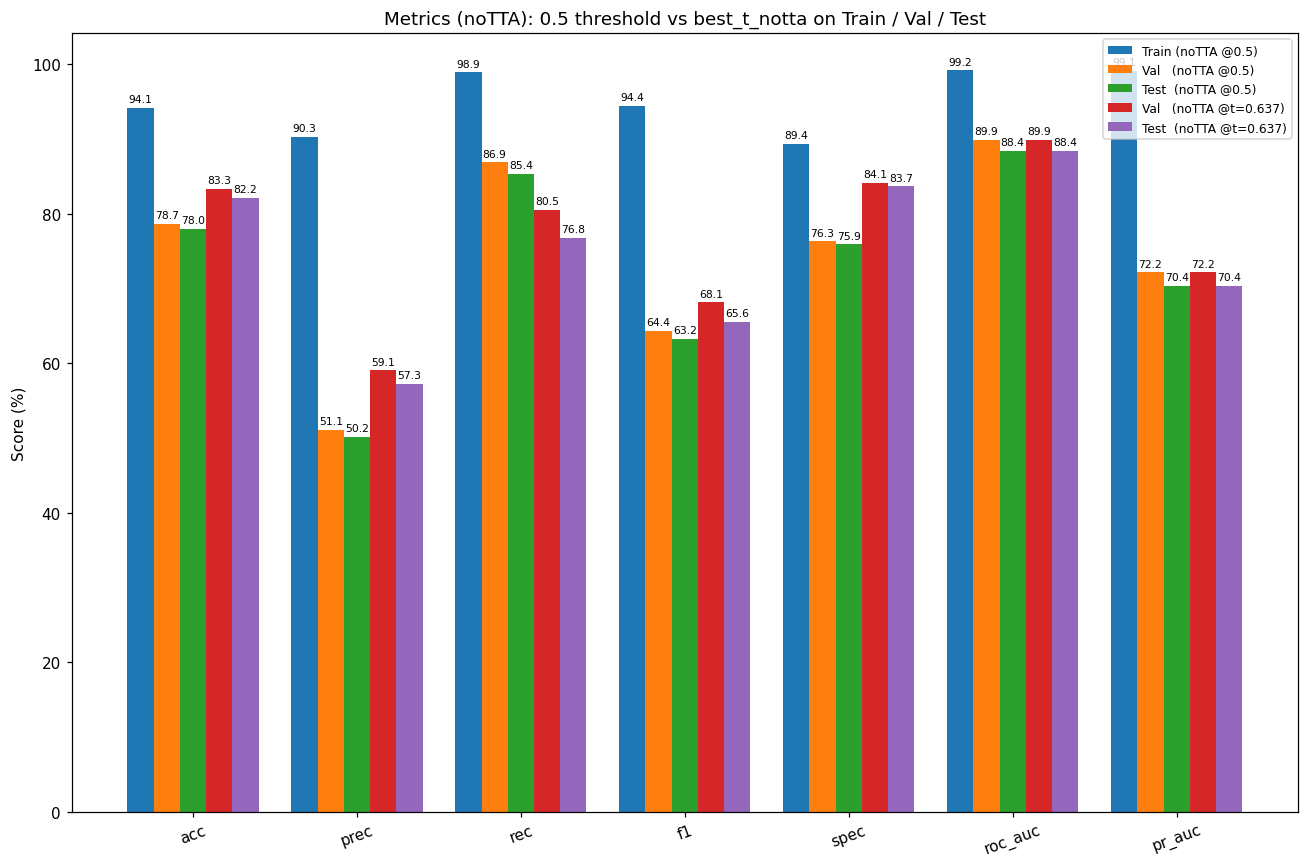

[Debug] metrics_df_val columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
                  Split     acc    prec     rec      f1    spec  roc_auc  \
0      Val (noTTA @0.5)  78.672  51.101  86.891  64.355  76.333   89.872   
1  Val (noTTA @t=0.637)  83.320  59.066  80.524  68.146  84.115   89.872   
2        Val (TTA @0.5)  79.336  52.000  87.640  65.272  76.972   90.478   
3    Val (TTA @t=0.689)  85.892  65.495  76.779  70.690  88.486   90.478   

   pr_auc  
0  72.157  
1  72.157  
2  72.760  
3  72.760  
[Info] Saved val metrics summary to: ./Baseline+ECA(7000,256)_Output\metrics_summary_val_notta_tta_bestt.csv


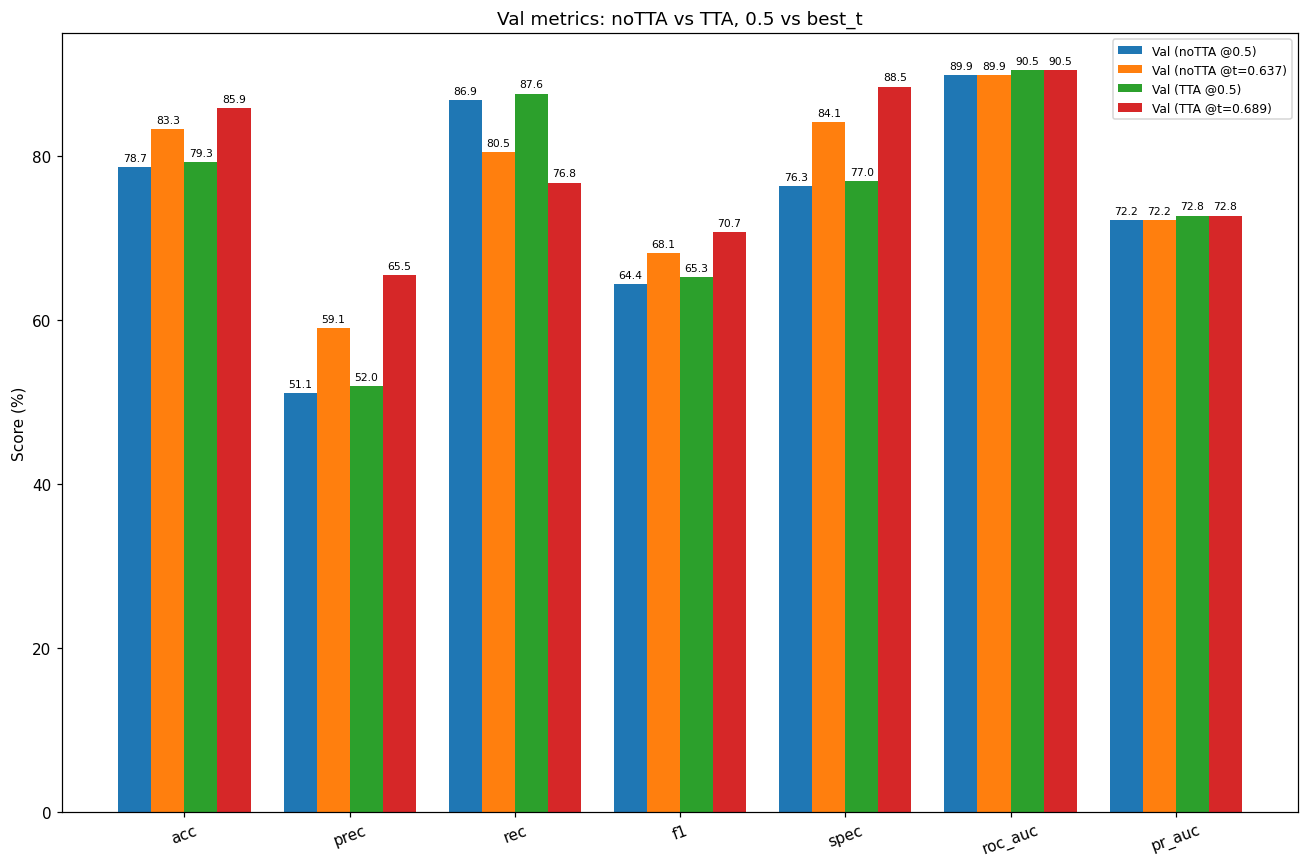

[Debug] metrics_df_test columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
                   Split     acc    prec     rec      f1    spec  roc_auc  \
0      Test (noTTA @0.5)  78.008  50.220  85.393  63.245  75.906   88.376   
1  Test (noTTA @t=0.637)  82.158  57.263  76.779  65.600  83.689   88.376   
2        Test (TTA @0.5)  79.004  51.606  84.270  64.011  77.505   88.914   
3    Test (TTA @t=0.689)  84.398  63.211  70.787  66.784  88.273   88.914   

   pr_auc  
0  70.393  
1  70.393  
2  71.029  
3  71.029  
[Info] Saved test metrics summary to: ./Baseline+ECA(7000,256)_Output\metrics_summary_test_notta_tta_bestt.csv


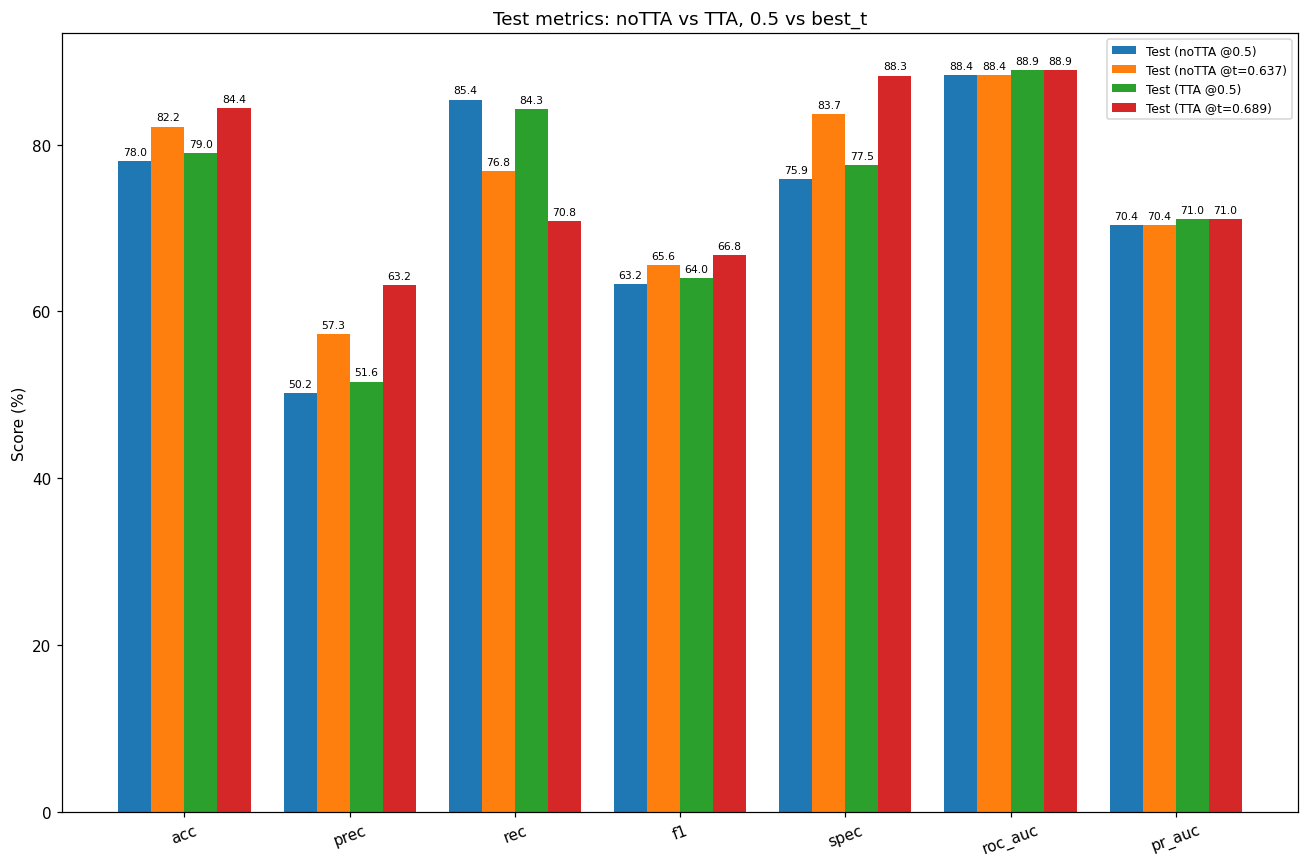

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# noTTA @ best_t_notta
val_pct_best_notta = {
    "acc":     round(val_acc_n  * 100, 3),
    "prec":    round(val_prec_n * 100, 3),
    "rec":     round(val_rec_n  * 100, 3),
    "f1":      round(val_f1_n   * 100, 3),
    "spec":    round(val_spec_n * 100, 3),
    "roc_auc": round(val_roc_n  * 100, 3),
    "pr_auc":  round(val_pr_n   * 100, 3),
}

test_pct_best_notta = {
    "acc":     round(test_acc_n  * 100, 3),
    "prec":    round(test_prec_n * 100, 3),
    "rec":     round(test_rec_n  * 100, 3),
    "f1":      round(test_f1_n   * 100, 3),
    "spec":    round(test_spec_n * 100, 3),
    "roc_auc": round(test_roc_n  * 100, 3),
    "pr_auc":  round(test_pr_n   * 100, 3),
}

# TTA @ best_t_tta
val_pct_best_tta = {
    "acc":     round(val_acc_t  * 100, 3),
    "prec":    round(val_prec_t * 100, 3),
    "rec":     round(val_rec_t  * 100, 3),
    "f1":      round(val_f1_t   * 100, 3),
    "spec":    round(val_spec_t * 100, 3),
    "roc_auc": round(val_roc_t  * 100, 3),
    "pr_auc":  round(val_pr_t   * 100, 3),
}

test_pct_best_tta = {
    "acc":     round(test_acc_t  * 100, 3),
    "prec":    round(test_prec_t * 100, 3),
    "rec":     round(test_rec_t  * 100, 3),
    "f1":      round(test_f1_t   * 100, 3),
    "spec":    round(test_spec_t * 100, 3),
    "roc_auc": round(test_roc_t  * 100, 3),
    "pr_auc":  round(test_pr_t   * 100, 3),
}

rows_overall = [
    {"Split": "Train (noTTA @0.5)", **train_pct},
    {"Split": "Val   (noTTA @0.5)", **val_pct},
    {"Split": "Test  (noTTA @0.5)", **test_pct},
    {"Split": f"Val   (noTTA @t={best_t_notta:.3f})",  **val_pct_best_notta},
    {"Split": f"Test  (noTTA @t={best_t_notta:.3f})", **test_pct_best_notta},
]

metrics_df_overall = pd.DataFrame(rows_overall)
metric_cols_overall = [c for c in metrics_df_overall.columns if c != "Split"]
metrics_df_overall = metrics_df_overall[["Split"] + metric_cols_overall]

print("[Debug] metrics_df_overall columns:", list(metrics_df_overall.columns))
print(metrics_df_overall)

metrics_csv_path_overall = os.path.join(OUT_DIR, "metrics_summary_overall_notta_bestt.csv")
metrics_df_overall.to_csv(metrics_csv_path_overall, index=False)
print(f"[Info] Saved overall metrics summary to: {metrics_csv_path_overall}")

x = np.arange(len(metric_cols_overall))
n_splits_overall = len(metrics_df_overall)
width = 0.8 / n_splits_overall

plt.figure(figsize=(12, 8))
for i, split in enumerate(metrics_df_overall["Split"]):
    values = metrics_df_overall.loc[i, metric_cols_overall].values.astype(float)
    offset = (i - (n_splits_overall - 1) / 2) * width
    plt.bar(x + offset, values, width, label=split)
    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=7)

xtick_labels_overall = [c.replace("(%)", "").replace("%", "").strip()
                        for c in metric_cols_overall]
plt.xticks(x, xtick_labels_overall, rotation=20)
plt.ylabel("Score (%)")
plt.title("Metrics (noTTA): 0.5 threshold vs best_t_notta on Train / Val / Test")
plt.legend(fontsize=8)
plt.tight_layout()

bar_fig_path_overall = os.path.join(OUT_DIR, "metrics_bar_overall_notta_bestt.png")
plt.savefig(bar_fig_path_overall, dpi=300)
plt.show()

rows_val = [
    {"Split": "Val (noTTA @0.5)",            **val_pct},
    {"Split": f"Val (noTTA @t={best_t_notta:.3f})", **val_pct_best_notta},
    {"Split": "Val (TTA @0.5)",              **val_pct_TTA},
    {"Split": f"Val (TTA @t={best_t_tta:.3f})",     **val_pct_best_tta},
]

metrics_df_val = pd.DataFrame(rows_val)
metric_cols_val = [c for c in metrics_df_val.columns if c != "Split"]
metrics_df_val = metrics_df_val[["Split"] + metric_cols_val]

print("[Debug] metrics_df_val columns:", list(metrics_df_val.columns))
print(metrics_df_val)

metrics_csv_path_val = os.path.join(OUT_DIR, "metrics_summary_val_notta_tta_bestt.csv")
metrics_df_val.to_csv(metrics_csv_path_val, index=False)
print(f"[Info] Saved val metrics summary to: {metrics_csv_path_val}")

x = np.arange(len(metric_cols_val))
n_splits_val = len(metrics_df_val)
width = 0.8 / n_splits_val

plt.figure(figsize=(12, 8))
for i, split in enumerate(metrics_df_val["Split"]):
    values = metrics_df_val.loc[i, metric_cols_val].values.astype(float)
    offset = (i - (n_splits_val - 1) / 2) * width
    plt.bar(x + offset, values, width, label=split)
    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=7)

xtick_labels_val = [c.replace("(%)", "").replace("%", "").strip()
                    for c in metric_cols_val]
plt.xticks(x, xtick_labels_val, rotation=20)
plt.ylabel("Score (%)")
plt.title("Val metrics: noTTA vs TTA, 0.5 vs best_t")
plt.legend(fontsize=8)
plt.tight_layout()

bar_fig_path_val = os.path.join(OUT_DIR, "metrics_bar_val_notta_tta_bestt.png")
plt.savefig(bar_fig_path_val, dpi=300)
plt.show()

rows_test = [
    {"Split": "Test (noTTA @0.5)",            **test_pct},
    {"Split": f"Test (noTTA @t={best_t_notta:.3f})", **test_pct_best_notta},
    {"Split": "Test (TTA @0.5)",              **test_pct_TTA},
    {"Split": f"Test (TTA @t={best_t_tta:.3f})",     **test_pct_best_tta},
]

metrics_df_test = pd.DataFrame(rows_test)
metric_cols_test = [c for c in metrics_df_test.columns if c != "Split"]
metrics_df_test = metrics_df_test[["Split"] + metric_cols_test]

print("[Debug] metrics_df_test columns:", list(metrics_df_test.columns))
print(metrics_df_test)

metrics_csv_path_test = os.path.join(OUT_DIR, "metrics_summary_test_notta_tta_bestt.csv")
metrics_df_test.to_csv(metrics_csv_path_test, index=False)
print(f"[Info] Saved test metrics summary to: {metrics_csv_path_test}")

x = np.arange(len(metric_cols_test))
n_splits_test = len(metrics_df_test)
width = 0.8 / n_splits_test

plt.figure(figsize=(12, 8))
for i, split in enumerate(metrics_df_test["Split"]):
    values = metrics_df_test.loc[i, metric_cols_test].values.astype(float)
    offset = (i - (n_splits_test - 1) / 2) * width
    plt.bar(x + offset, values, width, label=split)
    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=7)

xtick_labels_test = [c.replace("(%)", "").replace("%", "").strip()
                     for c in metric_cols_test]
plt.xticks(x, xtick_labels_test, rotation=20)
plt.ylabel("Score (%)")
plt.title("Test metrics: noTTA vs TTA, 0.5 vs best_t")
plt.legend(fontsize=8)
plt.tight_layout()

bar_fig_path_test = os.path.join(OUT_DIR, "metrics_bar_test_notta_tta_bestt.png")
plt.savefig(bar_fig_path_test, dpi=300)
plt.show()

### 19.2 Find best threshold after calibration
Compare noTTA vs TTA threshold sweep AFTER calibration


=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.637 83.402 59.229 80.524 68.254 84.222
    0.584 81.992 56.313 83.521 67.270 81.557
    0.689 83.734 60.725 75.281 67.224 86.141
    0.741 84.066 62.887 68.539 65.591 88.486
    0.532 79.751 52.656 85.393 65.143 78.145
    0.793 85.145 68.966 59.925 64.128 92.324
    0.480 78.091 50.323 87.640 63.934 75.373
    0.428 74.855 46.552 91.011 61.597 70.256
    0.376 72.282 44.133 94.382 60.143 65.991
    0.323 69.793 42.036 95.880 58.447 62.367

Best threshold on validation set (by f1):
t = 0.637, Acc=83.402%, Prec=59.229%, Rec=80.524%, F1=68.254%, Spec=84.222%


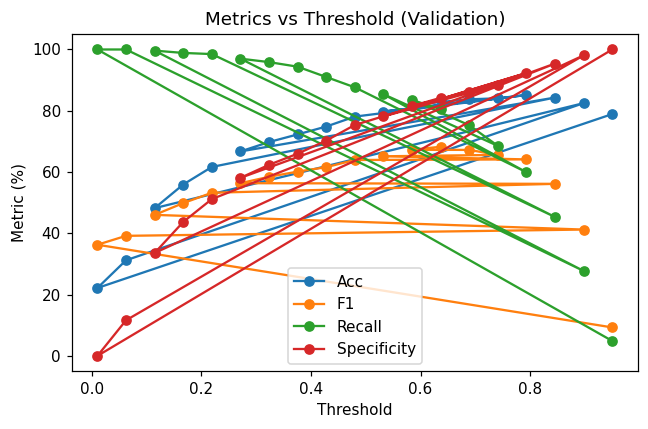


>>> [noTTA] Best threshold on validation set AFTER calibration: best_t_notta_cal = 0.637
[Info] Saved calibrated best threshold (noTTA) to: ./Baseline+ECA(7000,256)_Output\best_threshold_notta_calibrated.txt

[noTTA Val @ T_opt + best_t_notta_cal]
Accuracy (%)        : 83.402
Precision (%)       : 59.229
Recall (%)          : 80.524
F1-Score (%)        : 68.254
Specificity (%)     : 84.222
ROC-AUC (%)         : 89.872
Precision-recall (%): 72.157

[noTTA Test @ T_opt + best_t_notta_cal]
Accuracy (%)        : 82.158
Precision (%)       : 57.263
Recall (%)          : 76.779
F1-Score (%)        : 65.600
Specificity (%)     : 83.689
ROC-AUC (%)         : 88.376
Precision-recall (%): 70.392


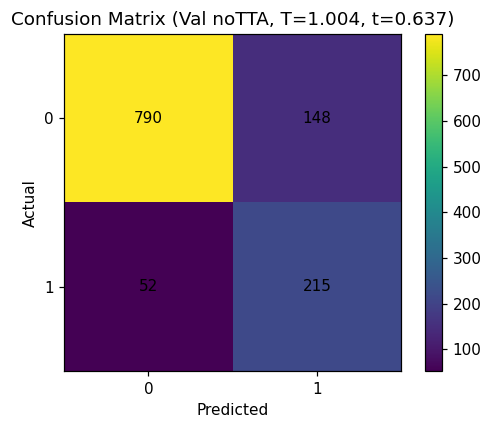

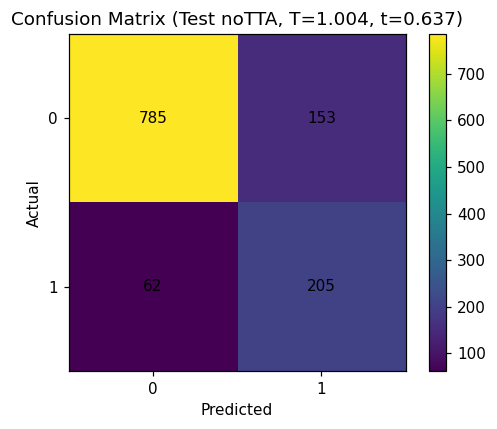


=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.689 85.892 65.495 76.779 70.690 88.486
    0.637 83.817 60.000 80.899 68.900 84.648
    0.741 85.809 68.045 67.790 67.917 90.938
    0.584 82.324 56.888 83.521 67.678 81.983
    0.532 80.664 53.972 86.517 66.475 78.998
    0.480 78.755 51.198 88.015 64.738 76.119
    0.428 76.515 48.394 90.262 63.007 72.601
    0.793 85.394 73.575 53.184 61.739 94.563
    0.376 73.527 45.273 93.258 60.955 67.910
    0.323 69.876 42.027 94.757 58.228 62.793

Best threshold on validation set (by f1):
t = 0.689, Acc=85.892%, Prec=65.495%, Rec=76.779%, F1=70.690%, Spec=88.486%


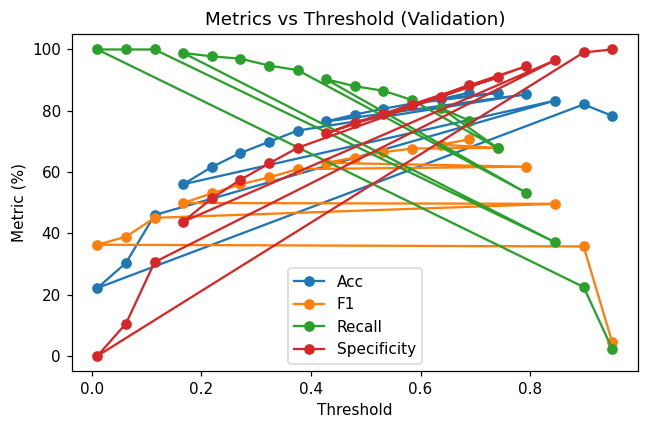


>>> [TTA] Best threshold on validation set AFTER calibration: best_t_tta_cal = 0.689
[Info] Saved calibrated best threshold (TTA) to: ./Baseline+ECA(7000,256)_Output\best_threshold_tta_calibrated.txt

[TTA Val @ T_opt + best_t_tta_cal]
Accuracy (%)        : 85.892
Precision (%)       : 65.495
Recall (%)          : 76.779
F1-Score (%)        : 70.690
Specificity (%)     : 88.486
ROC-AUC (%)         : 90.478
Precision-recall (%): 72.760

[TTA Test @ T_opt + best_t_tta_cal]
Accuracy (%)        : 84.315
Precision (%)       : 63.087
Recall (%)          : 70.412
F1-Score (%)        : 66.549
Specificity (%)     : 88.273
ROC-AUC (%)         : 88.914
Precision-recall (%): 71.029


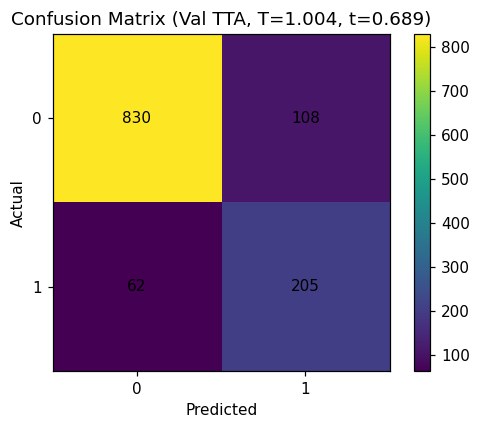

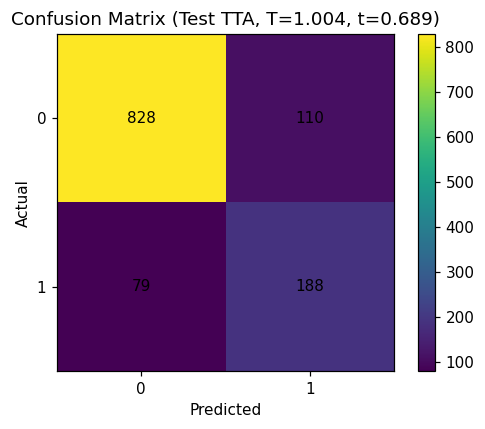

In [52]:
# ============================================
# 19.2 Find best threshold after calibration
# Compare noTTA vs TTA threshold sweep AFTER calibration
# ============================================

df_thr_val_notta_cal = sweep_thresholds(
    yv_cal_notta,
    sv_cal_notta,
    sort_by="f1",
    verbose=True,
)
plot_threshold_metrics(
    df_thr_val_notta_cal,
    OUT_DIR,
    prefix="val_thr_notta_calibrated",
)

best_t_notta_cal = float(df_thr_val_notta_cal.iloc[0]["threshold"])
print(f"\n>>> [noTTA] Best threshold on validation set AFTER calibration: best_t_notta_cal = {best_t_notta_cal:.3f}")

thr_path_notta_cal = os.path.join(OUT_DIR, "best_threshold_notta_calibrated.txt")
with open(thr_path_notta_cal, "w") as f:
    f.write(f"{best_t_notta_cal:.6f}\n")
print(f"[Info] Saved calibrated best threshold (noTTA) to: {thr_path_notta_cal}")

yv_arr_n = np.asarray(yv_cal_notta).astype(int).ravel()
sv_arr_n = np.asarray(sv_cal_notta).ravel()

yt_arr_n = np.asarray(yt_cal_notta).astype(int).ravel()
st_arr_n = np.asarray(st_cal_notta).ravel()

# Using best_t_notta_cal to get predictions
y_val_pred_notta_cal_t  = (sv_arr_n >= best_t_notta_cal).astype(int)
y_test_pred_notta_cal_t = (st_arr_n >= best_t_notta_cal).astype(int)

# Val metrics @ T_opt + best_t_notta_cal
val_acc_notta_cal   = accuracy_score(yv_arr_n, y_val_pred_notta_cal_t)
val_prec_notta_cal  = precision_score(yv_arr_n, y_val_pred_notta_cal_t, zero_division=0)
val_rec_notta_cal   = recall_score(yv_arr_n, y_val_pred_notta_cal_t, zero_division=0)
val_f1_notta_cal    = f1_score(yv_arr_n, y_val_pred_notta_cal_t, zero_division=0)

cm_val_notta_cal = confusion_matrix(yv_arr_n, y_val_pred_notta_cal_t)
if cm_val_notta_cal.shape == (2, 2):
    tn, fp, fn, tp = cm_val_notta_cal.ravel()
    val_spec_notta_cal = tn / (tn + fp + 1e-8)
else:
    val_spec_notta_cal = float("nan")

val_roc_notta_cal = roc_auc_score(yv_arr_n, sv_arr_n)
val_pr_notta_cal  = average_precision_score(yv_arr_n, sv_arr_n)

# Test metrics @ T_opt + best_t_notta_cal
test_acc_notta_cal  = accuracy_score(yt_arr_n, y_test_pred_notta_cal_t)
test_prec_notta_cal = precision_score(yt_arr_n, y_test_pred_notta_cal_t, zero_division=0)
test_rec_notta_cal  = recall_score(yt_arr_n, y_test_pred_notta_cal_t, zero_division=0)
test_f1_notta_cal   = f1_score(yt_arr_n, y_test_pred_notta_cal_t, zero_division=0)

cm_test_notta_cal = confusion_matrix(yt_arr_n, y_test_pred_notta_cal_t)
if cm_test_notta_cal.shape == (2, 2):
    tn, fp, fn, tp = cm_test_notta_cal.ravel()
    test_spec_notta_cal = tn / (tn + fp + 1e-8)
else:
    test_spec_notta_cal = float("nan")

test_roc_notta_cal = roc_auc_score(yt_arr_n, st_arr_n)
test_pr_notta_cal  = average_precision_score(yt_arr_n, st_arr_n)

print("\n[noTTA Val @ T_opt + best_t_notta_cal]")
print(f"Accuracy (%)        : {val_acc_notta_cal*100:.3f}")
print(f"Precision (%)       : {val_prec_notta_cal*100:.3f}")
print(f"Recall (%)          : {val_rec_notta_cal*100:.3f}")
print(f"F1-Score (%)        : {val_f1_notta_cal*100:.3f}")
print(f"Specificity (%)     : {val_spec_notta_cal*100:.3f}")
print(f"ROC-AUC (%)         : {val_roc_notta_cal*100:.3f}")
print(f"Precision-recall (%): {val_pr_notta_cal*100:.3f}")

print("\n[noTTA Test @ T_opt + best_t_notta_cal]")
print(f"Accuracy (%)        : {test_acc_notta_cal*100:.3f}")
print(f"Precision (%)       : {test_prec_notta_cal*100:.3f}")
print(f"Recall (%)          : {test_rec_notta_cal*100:.3f}")
print(f"F1-Score (%)        : {test_f1_notta_cal*100:.3f}")
print(f"Specificity (%)     : {test_spec_notta_cal*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc_notta_cal*100:.3f}")
print(f"Precision-recall (%): {test_pr_notta_cal*100:.3f}")

# CM（noTTA）
plot_confusion_matrix(
    y_true=yv_arr_n,
    y_pred=y_val_pred_notta_cal_t,
    out_path=os.path.join(OUT_DIR, f"confmat_val_notta_T{T_opt:.3f}_t{best_t_notta_cal:.3f}.png"),
    title=f"Confusion Matrix (Val noTTA, T={T_opt:.3f}, t={best_t_notta_cal:.3f})"
)

plot_confusion_matrix(
    y_true=yt_arr_n,
    y_pred=y_test_pred_notta_cal_t,
    out_path=os.path.join(OUT_DIR, f"confmat_test_notta_T{T_opt:.3f}_t{best_t_notta_cal:.3f}.png"),
    title=f"Confusion Matrix (Test noTTA, T={T_opt:.3f}, t={best_t_notta_cal:.3f})"
)

df_thr_val_tta_cal = sweep_thresholds(
    yv_tta,
    sv_val_tta_cal, 
    sort_by="f1",
    verbose=True,
)
plot_threshold_metrics(
    df_thr_val_tta_cal,
    OUT_DIR,
    prefix="val_thr_tta_calibrated",
)

best_t_tta_cal = float(df_thr_val_tta_cal.iloc[0]["threshold"])
print(f"\n>>> [TTA] Best threshold on validation set AFTER calibration: best_t_tta_cal = {best_t_tta_cal:.3f}")

thr_path_tta_cal = os.path.join(OUT_DIR, "best_threshold_tta_calibrated.txt")
with open(thr_path_tta_cal, "w") as f:
    f.write(f"{best_t_tta_cal:.6f}\n")
print(f"[Info] Saved calibrated best threshold (TTA) to: {thr_path_tta_cal}")

yv_arr_t = np.asarray(yv_tta).astype(int).ravel()
sv_arr_t = np.asarray(sv_val_tta_cal).ravel()

yt_arr_t = np.asarray(yt_tta).astype(int).ravel()
st_arr_t = np.asarray(st_test_tta_cal).ravel()

y_val_pred_tta_cal_t  = (sv_arr_t >= best_t_tta_cal).astype(int)
y_test_pred_tta_cal_t = (st_arr_t >= best_t_tta_cal).astype(int)

# Val metrics @ T_opt + best_t_tta_cal
val_acc_tta_cal   = accuracy_score(yv_arr_t, y_val_pred_tta_cal_t)
val_prec_tta_cal  = precision_score(yv_arr_t, y_val_pred_tta_cal_t, zero_division=0)
val_rec_tta_cal   = recall_score(yv_arr_t, y_val_pred_tta_cal_t, zero_division=0)
val_f1_tta_cal    = f1_score(yv_arr_t, y_val_pred_tta_cal_t, zero_division=0)

cm_val_tta_cal = confusion_matrix(yv_arr_t, y_val_pred_tta_cal_t)
if cm_val_tta_cal.shape == (2, 2):
    tn, fp, fn, tp = cm_val_tta_cal.ravel()
    val_spec_tta_cal = tn / (tn + fp + 1e-8)
else:
    val_spec_tta_cal = float("nan")

val_roc_tta_cal = roc_auc_score(yv_arr_t, sv_arr_t)
val_pr_tta_cal  = average_precision_score(yv_arr_t, sv_arr_t)

# Test metrics @ T_opt + best_t_tta_cal
test_acc_tta_cal  = accuracy_score(yt_arr_t, y_test_pred_tta_cal_t)
test_prec_tta_cal = precision_score(yt_arr_t, y_test_pred_tta_cal_t, zero_division=0)
test_rec_tta_cal  = recall_score(yt_arr_t, y_test_pred_tta_cal_t, zero_division=0)
test_f1_tta_cal   = f1_score(yt_arr_t, y_test_pred_tta_cal_t, zero_division=0)

cm_test_tta_cal = confusion_matrix(yt_arr_t, y_test_pred_tta_cal_t)
if cm_test_tta_cal.shape == (2, 2):
    tn, fp, fn, tp = cm_test_tta_cal.ravel()
    test_spec_tta_cal = tn / (tn + fp + 1e-8)
else:
    test_spec_tta_cal = float("nan")

test_roc_tta_cal = roc_auc_score(yt_arr_t, st_arr_t)
test_pr_tta_cal  = average_precision_score(yt_arr_t, st_arr_t)

print("\n[TTA Val @ T_opt + best_t_tta_cal]")
print(f"Accuracy (%)        : {val_acc_tta_cal*100:.3f}")
print(f"Precision (%)       : {val_prec_tta_cal*100:.3f}")
print(f"Recall (%)          : {val_rec_tta_cal*100:.3f}")
print(f"F1-Score (%)        : {val_f1_tta_cal*100:.3f}")
print(f"Specificity (%)     : {val_spec_tta_cal*100:.3f}")
print(f"ROC-AUC (%)         : {val_roc_tta_cal*100:.3f}")
print(f"Precision-recall (%): {val_pr_tta_cal*100:.3f}")

print("\n[TTA Test @ T_opt + best_t_tta_cal]")
print(f"Accuracy (%)        : {test_acc_tta_cal*100:.3f}")
print(f"Precision (%)       : {test_prec_tta_cal*100:.3f}")
print(f"Recall (%)          : {test_rec_tta_cal*100:.3f}")
print(f"F1-Score (%)        : {test_f1_tta_cal*100:.3f}")
print(f"Specificity (%)     : {test_spec_tta_cal*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc_tta_cal*100:.3f}")
print(f"Precision-recall (%): {test_pr_tta_cal*100:.3f}")

# CM（TTA）
plot_confusion_matrix(
    y_true=yv_arr_t,
    y_pred=y_val_pred_tta_cal_t,
    out_path=os.path.join(OUT_DIR, f"confmat_val_tta_T{T_opt:.3f}_t{best_t_tta_cal:.3f}.png"),
    title=f"Confusion Matrix (Val TTA, T={T_opt:.3f}, t={best_t_tta_cal:.3f})"
)

plot_confusion_matrix(
    y_true=yt_arr_t,
    y_pred=y_test_pred_tta_cal_t,
    out_path=os.path.join(OUT_DIR, f"confmat_test_tta_T{T_opt:.3f}_t{best_t_tta_cal:.3f}.png"),
    title=f"Confusion Matrix (Test TTA, T={T_opt:.3f}, t={best_t_tta_cal:.3f})"
)


[Debug] metrics_df_val columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
                        Split     acc    prec     rec      f1    spec  \
0  Val (noTTA Raw,   t=0.637)  83.320  59.066  80.524  68.146  84.115   
1  Val (noTTA Calib, t=0.637)  83.402  59.229  80.524  68.254  84.222   
2  Val (TTA Raw,     t=0.689)  85.892  65.495  76.779  70.690  88.486   
3  Val (TTA Calib,   t=0.689)  85.892  65.495  76.779  70.690  88.486   

   roc_auc  pr_auc  
0   89.872  72.157  
1   89.872  72.157  
2   90.478  72.760  
3   90.478  72.760  
[Info] Saved VAL metrics summary to: ./Baseline+ECA(7000,256)_Output\metrics_summary_val_notta_tta_raw_vs_calibrated_bestt.csv


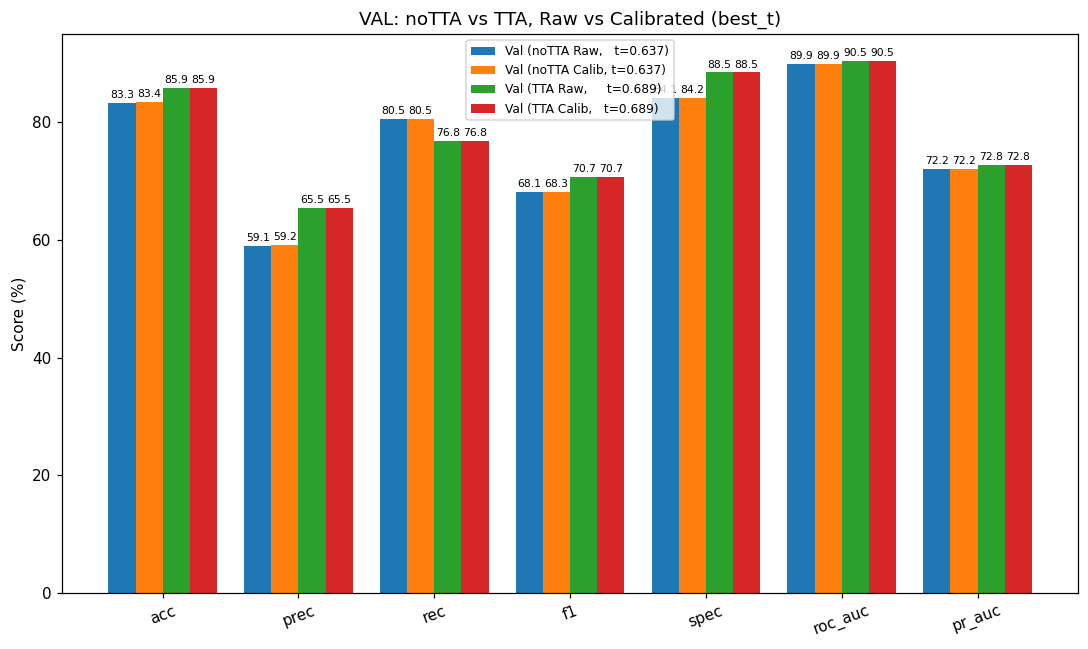

[Debug] metrics_df_test columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
                         Split     acc    prec     rec      f1    spec  \
0  Test (noTTA Raw,   t=0.637)  82.158  57.263  76.779  65.600  83.689   
1  Test (noTTA Calib, t=0.637)  82.158  57.263  76.779  65.600  83.689   
2  Test (TTA Raw,     t=0.689)  84.398  63.211  70.787  66.784  88.273   
3  Test (TTA Calib,   t=0.689)  84.315  63.087  70.412  66.549  88.273   

   roc_auc  pr_auc  
0   88.376  70.393  
1   88.376  70.392  
2   88.914  71.029  
3   88.914  71.029  
[Info] Saved TEST metrics summary to: ./Baseline+ECA(7000,256)_Output\metrics_summary_test_notta_tta_raw_vs_calibrated_bestt.csv


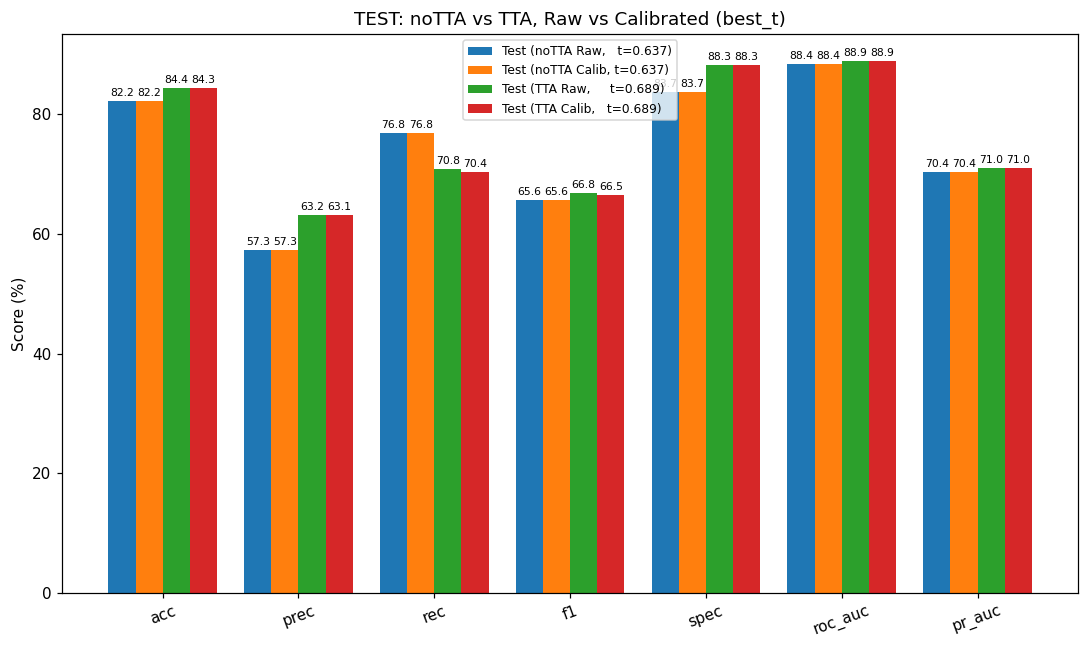

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def _metrics_from_probs(y_true, y_prob, thr):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_prob = np.asarray(y_prob).ravel()
    y_pred = (y_prob >= thr).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        spec = tn / (tn + fp + 1e-8)
    else:
        spec = float("nan")

    roc = roc_auc_score(y_true, y_prob)
    pr  = average_precision_score(y_true, y_prob)

    return {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "spec": spec,
        "roc_auc": roc,
        "pr_auc": pr,
    }

# ---- ① noTTA Raw @ best_t_notta ----
val_notta_raw  = _metrics_from_probs(yv_notta, sv_notta,        best_t_notta)
test_notta_raw = _metrics_from_probs(yt_notta, st_notta,        best_t_notta)

# ---- ② noTTA Calibrated @ best_t_notta_cal ----
val_notta_cal  = _metrics_from_probs(yv_cal_notta, sv_cal_notta, best_t_notta_cal)
test_notta_cal = _metrics_from_probs(yt_cal_notta, st_cal_notta, best_t_notta_cal)

# ---- ③ TTA Raw @ best_t_tta ----
val_tta_raw  = _metrics_from_probs(yv_tta, sv_tta,            best_t_tta)
test_tta_raw = _metrics_from_probs(yt_tta, st_tta,            best_t_tta)

val_tta_cal  = _metrics_from_probs(yv_tta, sv_val_tta_cal,    best_t_tta_cal)
test_tta_cal = _metrics_from_probs(yt_tta, st_test_tta_cal,   best_t_tta_cal)


def _pct_dict(m):
    return {k: round(v * 100, 3) for k, v in m.items()}

val_pct_notta_raw   = _pct_dict(val_notta_raw)
val_pct_notta_cal   = _pct_dict(val_notta_cal)
val_pct_tta_raw     = _pct_dict(val_tta_raw)
val_pct_tta_cal     = _pct_dict(val_tta_cal)

test_pct_notta_raw  = _pct_dict(test_notta_raw)
test_pct_notta_cal  = _pct_dict(test_notta_cal)
test_pct_tta_raw    = _pct_dict(test_tta_raw)
test_pct_tta_cal    = _pct_dict(test_tta_cal)

rows_val = [
    {"Split": f"Val (noTTA Raw,   t={best_t_notta:.3f})",      **val_pct_notta_raw},
    {"Split": f"Val (noTTA Calib, t={best_t_notta_cal:.3f})", **val_pct_notta_cal},
    {"Split": f"Val (TTA Raw,     t={best_t_tta:.3f})",       **val_pct_tta_raw},
    {"Split": f"Val (TTA Calib,   t={best_t_tta_cal:.3f})",   **val_pct_tta_cal},
]

metrics_df_val = pd.DataFrame(rows_val)
metric_cols_val = [c for c in metrics_df_val.columns if c != "Split"]
metrics_df_val = metrics_df_val[["Split"] + metric_cols_val]

print("[Debug] metrics_df_val columns:", list(metrics_df_val.columns))
print(metrics_df_val)

metrics_csv_path_val = os.path.join(OUT_DIR, "metrics_summary_val_notta_tta_raw_vs_calibrated_bestt.csv")
metrics_df_val.to_csv(metrics_csv_path_val, index=False)
print(f"[Info] Saved VAL metrics summary to: {metrics_csv_path_val}")

x = np.arange(len(metric_cols_val))
n_splits_val = len(metrics_df_val)
width = 0.8 / n_splits_val

plt.figure(figsize=(10, 6))
for i, split in enumerate(metrics_df_val["Split"]):
    values = metrics_df_val.loc[i, metric_cols_val].values.astype(float)
    offset = (i - (n_splits_val - 1) / 2) * width
    plt.bar(x + offset, values, width, label=split)
    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=7)

xtick_labels_val = [c.replace("(%)", "").replace("%", "").strip()
                    for c in metric_cols_val]
plt.xticks(x, xtick_labels_val, rotation=20)
plt.ylabel("Score (%)")
plt.title("VAL: noTTA vs TTA, Raw vs Calibrated (best_t)")
plt.legend(fontsize=8)
plt.tight_layout()

bar_fig_path_val = os.path.join(OUT_DIR, "metrics_bar_val_notta_tta_raw_vs_calibrated_bestt.png")
plt.savefig(bar_fig_path_val, dpi=300)
plt.show()


rows_test = [
    {"Split": f"Test (noTTA Raw,   t={best_t_notta:.3f})",      **test_pct_notta_raw},
    {"Split": f"Test (noTTA Calib, t={best_t_notta_cal:.3f})", **test_pct_notta_cal},
    {"Split": f"Test (TTA Raw,     t={best_t_tta:.3f})",       **test_pct_tta_raw},
    {"Split": f"Test (TTA Calib,   t={best_t_tta_cal:.3f})",   **test_pct_tta_cal},
]

metrics_df_test = pd.DataFrame(rows_test)
metric_cols_test = [c for c in metrics_df_test.columns if c != "Split"]
metrics_df_test = metrics_df_test[["Split"] + metric_cols_test]

print("[Debug] metrics_df_test columns:", list(metrics_df_test.columns))
print(metrics_df_test)

metrics_csv_path_test = os.path.join(OUT_DIR, "metrics_summary_test_notta_tta_raw_vs_calibrated_bestt.csv")
metrics_df_test.to_csv(metrics_csv_path_test, index=False)
print(f"[Info] Saved TEST metrics summary to: {metrics_csv_path_test}")

x = np.arange(len(metric_cols_test))
n_splits_test = len(metrics_df_test)
width = 0.8 / n_splits_test

plt.figure(figsize=(10, 6))
for i, split in enumerate(metrics_df_test["Split"]):
    values = metrics_df_test.loc[i, metric_cols_test].values.astype(float)
    offset = (i - (n_splits_test - 1) / 2) * width
    plt.bar(x + offset, values, width, label=split)
    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=7)

xtick_labels_test = [c.replace("(%)", "").replace("%", "").strip()
                     for c in metric_cols_test]
plt.xticks(x, xtick_labels_test, rotation=20)
plt.ylabel("Score (%)")
plt.title("TEST: noTTA vs TTA, Raw vs Calibrated (best_t)")
plt.legend(fontsize=8)
plt.tight_layout()

bar_fig_path_test = os.path.join(OUT_DIR, "metrics_bar_test_notta_tta_raw_vs_calibrated_bestt.png")
plt.savefig(bar_fig_path_test, dpi=300)
plt.show()


In [54]:
temp_path = os.path.join(OUT_DIR, "best_temperature.txt")
if os.path.exists(temp_path):
    with open(temp_path, "r") as f:
        T_opt = float(f.read().strip())
    print(f"[Calib] Loaded temperature T_opt = {T_opt:.4f} from {temp_path}")
else:
    T_opt = 1.0
    print("[Calib] best_temperature.txt not found, use T_opt = 1.0 (no scaling).")

thr_cal_path = os.path.join(OUT_DIR, "best_threshold_calibrated.txt")
if os.path.exists(thr_cal_path):
    with open(thr_cal_path, "r") as f:
        best_t_cal = float(f.read().strip())
    print(f"[Calib] Loaded best_t_cal = {best_t_cal:.4f} from {thr_cal_path}")
else:
    best_t_cal = 0.5
    print("[Calib] best_threshold_calibrated.txt not found, use best_t_cal = 0.5.")


[Calib] Loaded temperature T_opt = 1.0041 from ./Baseline+ECA(7000,256)_Output\best_temperature.txt
[Calib] best_threshold_calibrated.txt not found, use best_t_cal = 0.5.


## 20. Model explainability

### 20.1 Model explainability function

In [55]:
class GradCAM:

    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            # Save the activations of the target layer
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            # Save the gradients of the target layer
            self.gradients = grad_output[0].detach()

        self.hooks.append(
            self.target_layer.register_forward_hook(forward_hook)
        )

        if hasattr(self.target_layer, "register_full_backward_hook"):
            self.hooks.append(
                self.target_layer.register_full_backward_hook(backward_hook)
            )
        else:
            self.hooks.append(
                self.target_layer.register_backward_hook(backward_hook)
            )

    def remove_hooks(self):
        for h in self.hooks:
            h.remove()
        self.hooks = []

    def __call__(self, x, class_idx=None):
        
        device = next(self.model.parameters()).device
        x = x.to(device)

        self.model.eval()
        self.model.zero_grad()

        # forward propagation
        out = self.model(x)
        if isinstance(out, tuple):
            cls_logits, _ = out       # (cls_logits, seg_logits)
        else:
            cls_logits = out

        if class_idx is None:
            scores = cls_logits
        else:
            scores = cls_logits[:, class_idx]

        loss = scores.sum()
        loss.backward()

        grads = self.gradients       # [B, C, H', W']
        activs = self.activations    # [B, C, H', W']

        weights = grads.mean(dim=(2, 3), keepdim=True)       # [B, C, 1, 1]
        cam = (weights * activs).sum(dim=1, keepdim=True)    # [B, 1, H', W']
        cam = F.relu(cam)

        cam = F.interpolate(
            cam,
            size=x.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        cam_min = cam.amin(dim=(2, 3), keepdim=True)
        cam_max = cam.amax(dim=(2, 3), keepdim=True)
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)

        return cam

In [56]:
# Initialize GradCAM with the model and target layer
target_layer = model.eca4 
gradcam = GradCAM(model, target_layer)
print("[Info] GradCAM initialized on:", target_layer)

[Info] GradCAM initialized on: ECALayer(
  (avg_pool): AdaptiveAvgPool2d(output_size=1)
  (conv): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (sigmoid): Sigmoid()
)


### 20.2 CAM plot

In [57]:
def visualize_gradcam_example(
    img_tensor: torch.Tensor, 
    cam_tensor: torch.Tensor, 
    title: str = None,
    out_path: str = None,
):
    img_np = denormalize(img_tensor)               # [H,W], 0~1
    cam_np = cam_tensor.detach().cpu().numpy()     # [H,W], 0~1

    plt.figure(figsize=(10, 4))

    # 1) Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_np, cmap="gray")
    plt.axis("off")
    plt.title("Original X-ray", fontsize=10)

    # 2) Grad-CAM
    plt.subplot(1, 3, 2)
    plt.imshow(cam_np, cmap="jet")
    plt.axis("off")
    plt.title("Grad-CAM", fontsize=10)

    # 3) Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(img_np, cmap="gray")
    plt.imshow(cam_np, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.title("Overlay", fontsize=10)

    if title is not None:
        plt.suptitle(title, fontsize=12)

    plt.tight_layout()
    if out_path is not None:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=300)
    plt.show()

### 20.3 Interpretability

In [58]:
def get_one_batch(loader):
    for xb, yb in loader:
        return xb, yb
    return None, None


def explain_with_gradcam_on_batch(
    model,
    gradcam,
    xb,         
    yb,          
    device,
    T_opt: float,
    best_t_cal: float,
    save_dir: str,
    prefix: str = "gradcam_explain",
    max_examples: int = 4,
):
    model.eval()
    xb = xb.to(device, non_blocking=True)
    yb = yb.to(device, non_blocking=True)

    # 1) Classification logits
    with torch.no_grad():
        out = model(xb)
        if isinstance(out, tuple):
            cls_logits, _ = out
        else:
            cls_logits = out

    # 2) Outputs before and after calibration
    logits_raw = cls_logits
    probs_raw  = torch.sigmoid(logits_raw)

    logits_cal = logits_raw / T_opt
    probs_cal  = torch.sigmoid(logits_cal)

    # 3) Grad-CAM
    cam = gradcam(xb)    # [B,1,H,W]

    os.makedirs(save_dir, exist_ok=True)

    B = xb.size(0)
    num_to_show = min(B, max_examples)

    for i in range(num_to_show):
        img_i  = xb[i]           # [1,H,W]
        cam_i  = cam[i, 0]       # [H,W]
        y_true = int(yb[i].cpu().item())

        p_raw = float(probs_raw[i].cpu().item())
        p_cal = float(probs_cal[i].cpu().item())

        y_pred_cal = int(p_cal >= best_t_cal)

        title = (
            f"y_true={y_true}, y_pred_cal={y_pred_cal}\n"
            f"p_raw={p_raw:.3f}, p_cal={p_cal:.3f} (T={T_opt:.3f}, t={best_t_cal:.3f})"
        )

        out_path = os.path.join(
            save_dir,
            f"{prefix}_idx{i}_y{y_true}_pred{y_pred_cal}.png"
        )

        visualize_gradcam_example(
            img_tensor=img_i,
            cam_tensor=cam_i,
            title=title,
            out_path=out_path,
        )

    print(f"[Info] Saved {num_to_show} Grad-CAM explainability examples to {save_dir}")

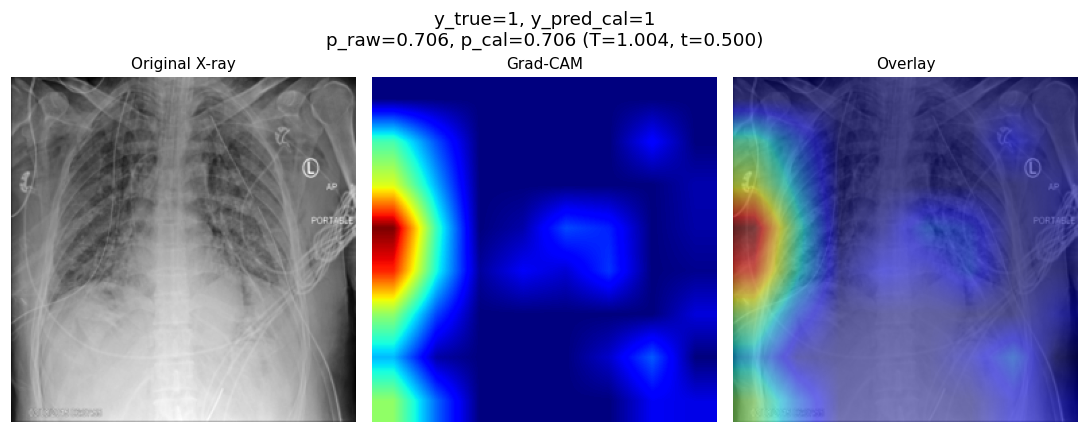

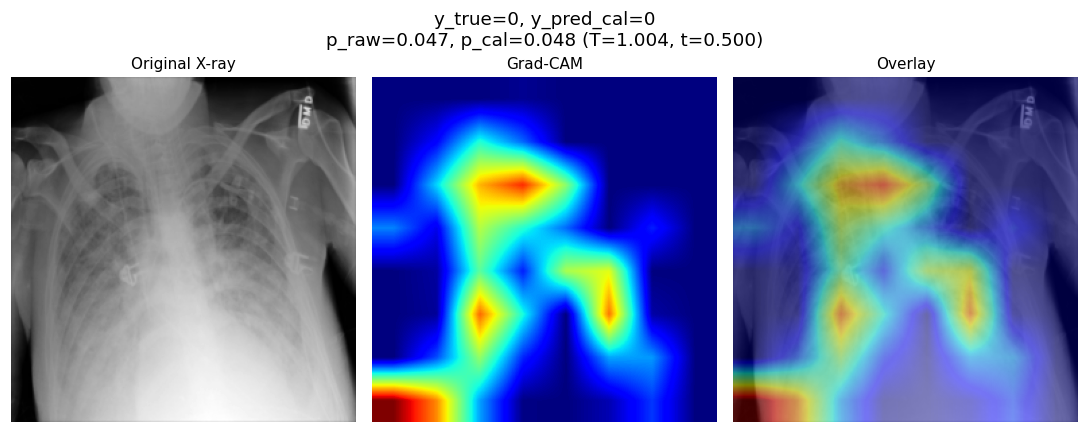

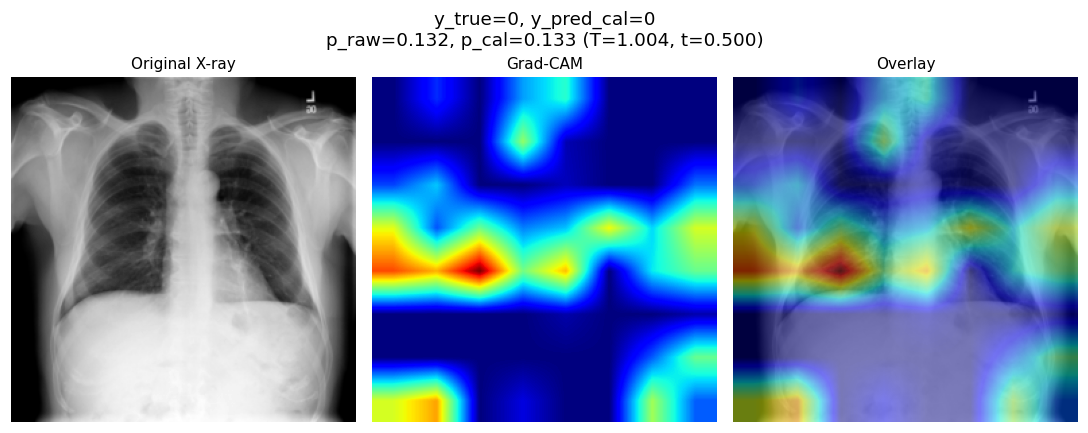

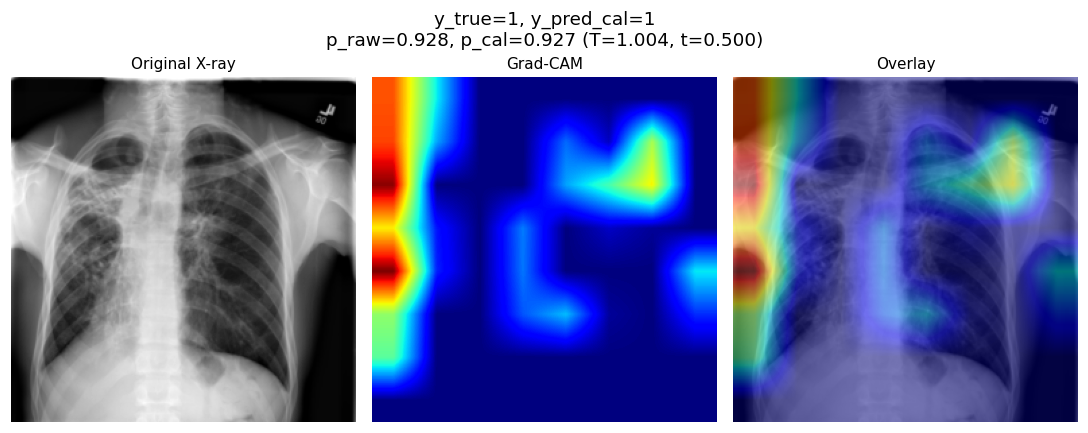

[Info] Saved 4 Grad-CAM explainability examples to ./Baseline+ECA(7000,256)_Output\explainability_val


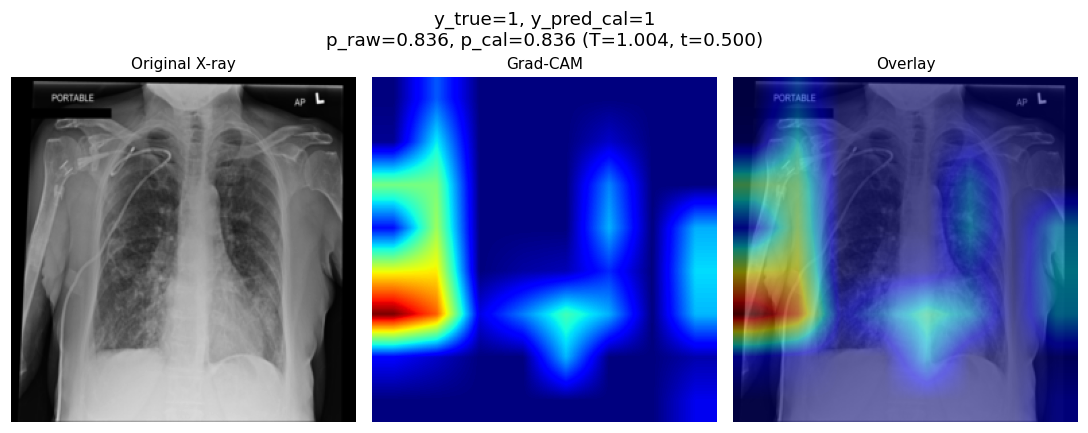

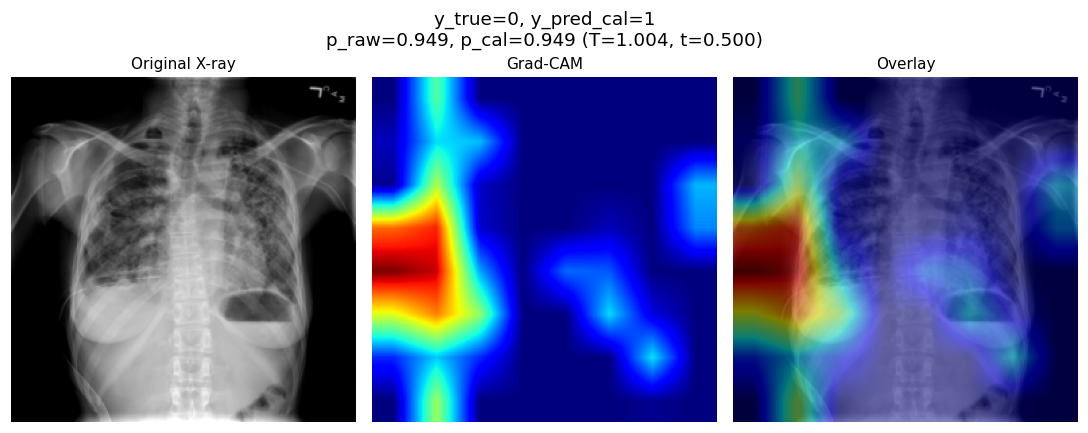

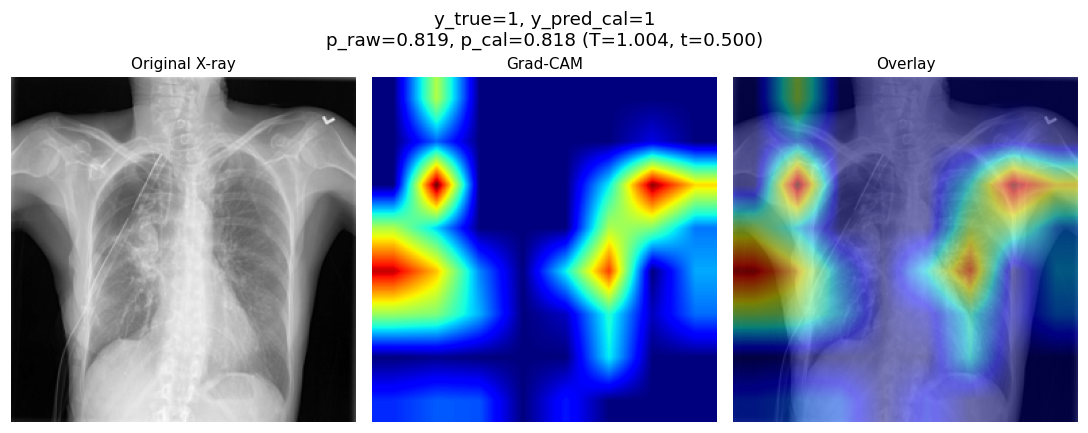

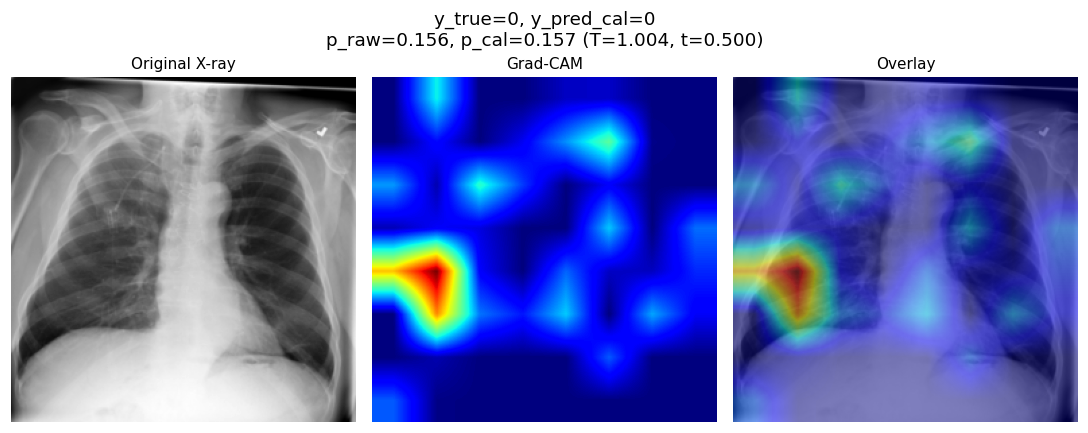

[Info] Saved 4 Grad-CAM explainability examples to ./Baseline+ECA(7000,256)_Output\explainability_test


In [59]:
xb_val, yb_val = get_one_batch(dl_val)
explain_with_gradcam_on_batch(
    model=model,
    gradcam=gradcam,
    xb=xb_val,
    yb=yb_val,
    device=device,
    T_opt=T_opt,
    best_t_cal=best_t_cal,
    save_dir=os.path.join(OUT_DIR, "explainability_val"),
    prefix="val_gradcam",
    max_examples=4,  
)

xb_test, yb_test = get_one_batch(dl_test)
explain_with_gradcam_on_batch(
    model=model,
    gradcam=gradcam,
    xb=xb_test,
    yb=yb_test,
    device=device,
    T_opt=T_opt,
    best_t_cal=best_t_cal,
    save_dir=os.path.join(OUT_DIR, "explainability_test"),
    prefix="test_gradcam",
    max_examples=4,
)